In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, Concatenate, RepeatVector, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
import nltk

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

2022-09-29 09:40:18.284912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 09:40:18.450841: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-29 09:40:18.513586: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 09:40:19.514914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
token = 'datasets/Flickr8k/Flickr8k.token.txt'

In [3]:
captions = open(token, 'r').read().strip().split('\n')

In [4]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [5]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
images = 'datasets/Flickr8k/Flicker8k_Dataset/'

In [7]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [8]:
img[:5]

['datasets/Flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'datasets/Flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'datasets/Flickr8k/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg',
 'datasets/Flickr8k/Flicker8k_Dataset/1003163366_44323f5815.jpg',
 'datasets/Flickr8k/Flicker8k_Dataset/1007129816_e794419615.jpg']

In [9]:
train_images_file = 'datasets/Flickr8k/Flickr_8k.trainImages.txt'

In [10]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [11]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [12]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [13]:
val_images_file = 'datasets/Flickr8k/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [14]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [15]:
test_images_file = 'datasets/Flickr8k/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [16]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

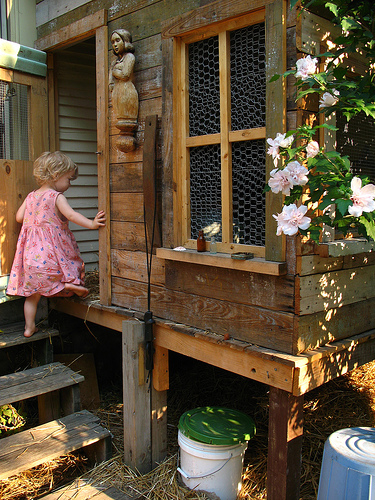

In [17]:
Image.open(train_img[0])

In [18]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [19]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


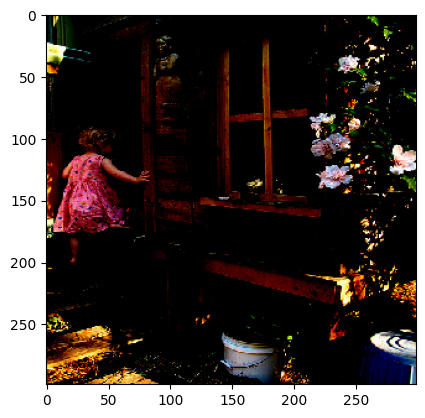

In [20]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [21]:
model = InceptionV3(weights='imagenet')

2022-09-29 09:40:22.225307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 09:40:23.322177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30973 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:09.0, compute capability: 7.0


In [22]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [23]:
tryi = model_new.predict(preprocess(train_img[0]))

2022-09-29 09:40:29.477096: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 5s 5s/step


In [24]:
tryi.shape

(1, 2048)

In [25]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [26]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

  0%|                                                                                                          | 0/6000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  0%|                                                                                                  | 2/6000 [00:00<09:00, 11.09it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                                                                                  | 4/6000 [00:00<08:42, 11.49it/s]

1/1 [==============================] - 0s 70ms/step


  0%|                                                                                                  | 6/6000 [00:00<09:37, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▏                                                                                                 | 8/6000 [00:00<09:00, 11.08it/s]

1/1 [==============================] - 0s 38ms/step


  0%|▏                                                                                                | 10/6000 [00:00<08:45, 11.41it/s]

1/1 [==============================] - 0s 37ms/step


  0%|▏                                                                                                | 12/6000 [00:01<10:21,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▏                                                                                                | 14/6000 [00:01<09:43, 10.25it/s]

1/1 [==============================] - 0s 109ms/step


  0%|▎                                                                                                | 16/6000 [00:01<10:36,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


  0%|▎                                                                                                | 18/6000 [00:01<09:53, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


  0%|▎                                                                                                | 20/6000 [00:01<09:27, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


  0%|▎                                                                                                | 22/6000 [00:02<10:16,  9.70it/s]

1/1 [==============================] - 0s 34ms/step


  0%|▍                                                                                                | 24/6000 [00:02<09:35, 10.38it/s]

1/1 [==============================] - 0s 129ms/step


  0%|▍                                                                                                | 26/6000 [00:02<10:41,  9.32it/s]

1/1 [==============================] - 0s 48ms/step


  0%|▍                                                                                                | 28/6000 [00:02<10:08,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


  0%|▍                                                                                                | 30/6000 [00:02<09:38, 10.33it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▌                                                                                                | 32/6000 [00:03<10:30,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▌                                                                                                | 34/6000 [00:03<09:54, 10.04it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▌                                                                                                | 36/6000 [00:03<10:30,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▌                                                                                                | 38/6000 [00:03<09:48, 10.13it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▋                                                                                                | 40/6000 [00:03<09:17, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▋                                                                                                | 42/6000 [00:04<10:33,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▋                                                                                                | 44/6000 [00:04<09:55, 10.00it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▋                                                                                                | 46/6000 [00:04<10:33,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▊                                                                                                | 48/6000 [00:04<09:51, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▊                                                                                                | 50/6000 [00:04<09:26, 10.51it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▊                                                                                                | 52/6000 [00:05<10:18,  9.62it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▊                                                                                                | 54/6000 [00:05<09:44, 10.17it/s]

1/1 [==============================] - 0s 116ms/step


  1%|▉                                                                                                | 56/6000 [00:05<10:30,  9.42it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▉                                                                                                | 58/6000 [00:05<09:49, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▉                                                                                                | 60/6000 [00:05<09:19, 10.63it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█                                                                                                | 62/6000 [00:06<10:37,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


  1%|█                                                                                                | 64/6000 [00:06<09:58,  9.92it/s]

1/1 [==============================] - 0s 129ms/step


  1%|█                                                                                                | 66/6000 [00:06<10:49,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


  1%|█                                                                                                | 68/6000 [00:06<10:01,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


  1%|█▏                                                                                               | 70/6000 [00:06<09:24, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


  1%|█▏                                                                                               | 72/6000 [00:07<10:36,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


  1%|█▏                                                                                               | 74/6000 [00:07<10:02,  9.84it/s]

1/1 [==============================] - 0s 122ms/step


  1%|█▏                                                                                               | 76/6000 [00:07<10:49,  9.12it/s]

1/1 [==============================] - 0s 34ms/step


  1%|█▎                                                                                               | 78/6000 [00:07<10:03,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


  1%|█▎                                                                                               | 80/6000 [00:08<09:29, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


  1%|█▎                                                                                               | 82/6000 [00:08<10:25,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


  1%|█▎                                                                                               | 84/6000 [00:08<09:43, 10.14it/s]

1/1 [==============================] - 0s 153ms/step


  1%|█▍                                                                                               | 86/6000 [00:08<11:00,  8.96it/s]

1/1 [==============================] - 0s 38ms/step


  1%|█▍                                                                                               | 88/6000 [00:08<10:10,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▍                                                                                               | 90/6000 [00:09<09:40, 10.17it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▍                                                                                               | 92/6000 [00:09<10:55,  9.01it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▌                                                                                               | 94/6000 [00:09<10:09,  9.68it/s]

1/1 [==============================] - 0s 120ms/step


  2%|█▌                                                                                               | 96/6000 [00:09<10:47,  9.12it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▌                                                                                               | 98/6000 [00:09<09:54,  9.93it/s]

1/1 [==============================] - 0s 58ms/step


  2%|█▌                                                                                              | 100/6000 [00:10<09:43, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▋                                                                                              | 102/6000 [00:10<10:30,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▋                                                                                              | 104/6000 [00:10<09:49, 10.01it/s]

1/1 [==============================] - 0s 122ms/step


  2%|█▋                                                                                              | 106/6000 [00:10<10:38,  9.22it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▋                                                                                              | 108/6000 [00:10<09:52,  9.94it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▊                                                                                              | 110/6000 [00:11<09:14, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▊                                                                                              | 112/6000 [00:11<10:17,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▊                                                                                              | 114/6000 [00:11<09:34, 10.24it/s]

1/1 [==============================] - 0s 133ms/step


  2%|█▊                                                                                              | 116/6000 [00:11<10:27,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▉                                                                                              | 118/6000 [00:11<09:42, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▉                                                                                              | 120/6000 [00:12<09:09, 10.71it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▉                                                                                              | 122/6000 [00:12<10:25,  9.40it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▉                                                                                              | 124/6000 [00:12<09:41, 10.10it/s]

1/1 [==============================] - 0s 134ms/step


  2%|██                                                                                              | 126/6000 [00:12<10:38,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


  2%|██                                                                                              | 128/6000 [00:12<09:48,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


  2%|██                                                                                              | 130/6000 [00:13<09:11, 10.64it/s]

1/1 [==============================] - 0s 36ms/step


  2%|██                                                                                              | 132/6000 [00:13<10:27,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


  2%|██▏                                                                                             | 134/6000 [00:13<09:43, 10.04it/s]

1/1 [==============================] - 0s 140ms/step


  2%|██▏                                                                                             | 136/6000 [00:13<10:48,  9.04it/s]

1/1 [==============================] - 0s 38ms/step


  2%|██▏                                                                                             | 138/6000 [00:14<10:04,  9.70it/s]

1/1 [==============================] - 0s 36ms/step


  2%|██▏                                                                                             | 140/6000 [00:14<09:33, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


  2%|██▎                                                                                             | 142/6000 [00:14<10:30,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


  2%|██▎                                                                                             | 144/6000 [00:14<09:38, 10.12it/s]

1/1 [==============================] - 0s 135ms/step


  2%|██▎                                                                                             | 146/6000 [00:14<10:35,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


  2%|██▎                                                                                             | 148/6000 [00:15<09:49,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


  2%|██▍                                                                                             | 150/6000 [00:15<09:22, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


  3%|██▍                                                                                             | 152/6000 [00:15<10:14,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██▍                                                                                             | 154/6000 [00:15<09:30, 10.24it/s]

1/1 [==============================] - 0s 141ms/step


  3%|██▍                                                                                             | 156/6000 [00:15<10:30,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██▌                                                                                             | 158/6000 [00:16<09:36, 10.13it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▌                                                                                             | 160/6000 [00:16<09:14, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


  3%|██▌                                                                                             | 162/6000 [00:16<10:10,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▌                                                                                             | 164/6000 [00:16<09:31, 10.22it/s]

1/1 [==============================] - 0s 123ms/step


  3%|██▋                                                                                             | 166/6000 [00:16<10:26,  9.32it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▋                                                                                             | 168/6000 [00:17<09:46,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▋                                                                                             | 170/6000 [00:17<09:24, 10.33it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▊                                                                                             | 172/6000 [00:17<10:33,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


  3%|██▊                                                                                             | 174/6000 [00:17<10:06,  9.61it/s]

1/1 [==============================] - 0s 56ms/step


  3%|██▊                                                                                             | 175/6000 [00:17<10:20,  9.39it/s]

1/1 [==============================] - 0s 87ms/step


  3%|██▊                                                                                             | 176/6000 [00:17<10:49,  8.96it/s]

1/1 [==============================] - 0s 35ms/step


  3%|██▊                                                                                             | 178/6000 [00:18<09:43,  9.99it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▉                                                                                             | 180/6000 [00:18<09:14, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██▉                                                                                             | 182/6000 [00:18<10:17,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▉                                                                                             | 184/6000 [00:18<09:32, 10.16it/s]

1/1 [==============================] - 0s 137ms/step


  3%|██▉                                                                                             | 186/6000 [00:18<10:34,  9.16it/s]

1/1 [==============================] - 0s 35ms/step


  3%|███                                                                                             | 188/6000 [00:19<09:38, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


  3%|███                                                                                             | 190/6000 [00:19<09:14, 10.47it/s]

1/1 [==============================] - 0s 39ms/step


  3%|███                                                                                             | 192/6000 [00:19<10:33,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


  3%|███                                                                                             | 194/6000 [00:19<09:55,  9.75it/s]

1/1 [==============================] - 0s 119ms/step


  3%|███▏                                                                                            | 196/6000 [00:19<10:35,  9.13it/s]

1/1 [==============================] - 0s 35ms/step


  3%|███▏                                                                                            | 198/6000 [00:20<09:56,  9.72it/s]

1/1 [==============================] - 0s 36ms/step


  3%|███▏                                                                                            | 200/6000 [00:20<09:23, 10.29it/s]

1/1 [==============================] - 0s 33ms/step


  3%|███▏                                                                                            | 202/6000 [00:20<10:01,  9.64it/s]

1/1 [==============================] - 0s 33ms/step


  3%|███▎                                                                                            | 204/6000 [00:20<09:13, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


  3%|███▎                                                                                            | 206/6000 [00:20<08:45, 11.02it/s]

1/1 [==============================] - 0s 35ms/step


  3%|███▎                                                                                            | 208/6000 [00:21<09:13, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


  4%|███▎                                                                                            | 210/6000 [00:21<08:48, 10.95it/s]

1/1 [==============================] - 0s 123ms/step


  4%|███▍                                                                                            | 212/6000 [00:21<09:50,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███▍                                                                                            | 214/6000 [00:21<09:14, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


  4%|███▍                                                                                            | 216/6000 [00:21<08:50, 10.91it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▍                                                                                            | 218/6000 [00:22<10:05,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


  4%|███▌                                                                                            | 220/6000 [00:22<09:22, 10.28it/s]

1/1 [==============================] - 0s 148ms/step


  4%|███▌                                                                                            | 222/6000 [00:22<10:28,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


  4%|███▌                                                                                            | 224/6000 [00:22<09:46,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▌                                                                                            | 226/6000 [00:22<09:19, 10.32it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▋                                                                                            | 228/6000 [00:23<10:26,  9.22it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▋                                                                                            | 230/6000 [00:23<09:57,  9.66it/s]

1/1 [==============================] - 0s 75ms/step


  4%|███▋                                                                                            | 232/6000 [00:23<10:04,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


  4%|███▋                                                                                            | 234/6000 [00:23<09:30, 10.11it/s]

1/1 [==============================] - 0s 48ms/step


  4%|███▊                                                                                            | 236/6000 [00:23<09:20, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███▊                                                                                            | 238/6000 [00:24<10:16,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


  4%|███▊                                                                                            | 240/6000 [00:24<09:36, 10.00it/s]

1/1 [==============================] - 0s 114ms/step


  4%|███▊                                                                                            | 242/6000 [00:24<10:13,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


  4%|███▉                                                                                            | 244/6000 [00:24<09:23, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


  4%|███▉                                                                                            | 246/6000 [00:24<08:58, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███▉                                                                                            | 248/6000 [00:25<10:34,  9.07it/s]

1/1 [==============================] - 0s 34ms/step


  4%|████                                                                                            | 250/6000 [00:25<09:40,  9.91it/s]

1/1 [==============================] - 0s 116ms/step


  4%|████                                                                                            | 252/6000 [00:25<10:16,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


  4%|████                                                                                            | 253/6000 [00:25<10:13,  9.37it/s]

1/1 [==============================] - 0s 37ms/step


  4%|████                                                                                            | 255/6000 [00:25<09:33, 10.02it/s]

1/1 [==============================] - 0s 82ms/step


  4%|████                                                                                            | 257/6000 [00:26<10:00,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


  4%|████▏                                                                                           | 259/6000 [00:26<09:21, 10.23it/s]

1/1 [==============================] - 0s 37ms/step


  4%|████▏                                                                                           | 261/6000 [00:26<08:57, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


  4%|████▏                                                                                           | 263/6000 [00:26<09:51,  9.70it/s]

1/1 [==============================] - 0s 35ms/step


  4%|████▏                                                                                           | 265/6000 [00:26<09:15, 10.33it/s]

1/1 [==============================] - 0s 139ms/step


  4%|████▎                                                                                           | 267/6000 [00:27<10:20,  9.24it/s]

1/1 [==============================] - 0s 33ms/step


  4%|████▎                                                                                           | 269/6000 [00:27<09:27, 10.09it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▎                                                                                           | 271/6000 [00:27<09:04, 10.52it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▎                                                                                           | 273/6000 [00:27<10:04,  9.47it/s]

1/1 [==============================] - 0s 36ms/step


  5%|████▍                                                                                           | 275/6000 [00:27<09:29, 10.04it/s]

1/1 [==============================] - 0s 109ms/step


  5%|████▍                                                                                           | 277/6000 [00:28<10:10,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


  5%|████▍                                                                                           | 279/6000 [00:28<09:22, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


  5%|████▍                                                                                           | 281/6000 [00:28<08:48, 10.82it/s]

1/1 [==============================] - 0s 75ms/step


  5%|████▌                                                                                           | 283/6000 [00:28<09:04, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


  5%|████▌                                                                                           | 285/6000 [00:28<08:43, 10.91it/s]

1/1 [==============================] - 0s 36ms/step


  5%|████▌                                                                                           | 287/6000 [00:28<08:31, 11.17it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▌                                                                                           | 289/6000 [00:29<09:30, 10.01it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▋                                                                                           | 291/6000 [00:29<09:00, 10.57it/s]

1/1 [==============================] - 0s 128ms/step


  5%|████▋                                                                                           | 293/6000 [00:29<09:58,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


  5%|████▋                                                                                           | 295/6000 [00:29<09:23, 10.12it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████▊                                                                                           | 297/6000 [00:29<08:54, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


  5%|████▊                                                                                           | 299/6000 [00:30<10:01,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


  5%|████▊                                                                                           | 301/6000 [00:30<09:20, 10.16it/s]

1/1 [==============================] - 0s 113ms/step


  5%|████▊                                                                                           | 303/6000 [00:30<10:21,  9.17it/s]

1/1 [==============================] - 0s 47ms/step


  5%|████▊                                                                                           | 304/6000 [00:30<10:13,  9.28it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▉                                                                                           | 306/6000 [00:30<09:31,  9.97it/s]

1/1 [==============================] - 0s 86ms/step


  5%|████▉                                                                                           | 308/6000 [00:31<09:50,  9.65it/s]

1/1 [==============================] - 0s 33ms/step


  5%|████▉                                                                                           | 310/6000 [00:31<09:05, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▉                                                                                           | 312/6000 [00:31<08:35, 11.04it/s]

1/1 [==============================] - 0s 36ms/step


  5%|█████                                                                                           | 314/6000 [00:31<09:56,  9.53it/s]

1/1 [==============================] - 0s 33ms/step


  5%|█████                                                                                           | 316/6000 [00:31<09:11, 10.31it/s]

1/1 [==============================] - 0s 140ms/step


  5%|█████                                                                                           | 318/6000 [00:32<10:17,  9.21it/s]

1/1 [==============================] - 0s 36ms/step


  5%|█████                                                                                           | 320/6000 [00:32<09:34,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


  5%|█████▏                                                                                          | 322/6000 [00:32<09:03, 10.45it/s]

1/1 [==============================] - 0s 37ms/step


  5%|█████▏                                                                                          | 324/6000 [00:32<10:02,  9.42it/s]

1/1 [==============================] - 0s 34ms/step


  5%|█████▏                                                                                          | 326/6000 [00:32<09:19, 10.15it/s]

1/1 [==============================] - 0s 139ms/step


  5%|█████▏                                                                                          | 328/6000 [00:33<10:17,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


  6%|█████▎                                                                                          | 330/6000 [00:33<09:34,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


  6%|█████▎                                                                                          | 332/6000 [00:33<09:15, 10.20it/s]

1/1 [==============================] - 0s 43ms/step


  6%|█████▎                                                                                          | 334/6000 [00:33<10:01,  9.41it/s]

1/1 [==============================] - 0s 35ms/step


  6%|█████▍                                                                                          | 336/6000 [00:33<09:17, 10.17it/s]

1/1 [==============================] - 0s 114ms/step


  6%|█████▍                                                                                          | 338/6000 [00:34<10:02,  9.40it/s]

1/1 [==============================] - 0s 35ms/step


  6%|█████▍                                                                                          | 340/6000 [00:34<09:23, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


  6%|█████▍                                                                                          | 342/6000 [00:34<08:57, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


  6%|█████▌                                                                                          | 344/6000 [00:34<09:43,  9.70it/s]

1/1 [==============================] - 0s 34ms/step


  6%|█████▌                                                                                          | 346/6000 [00:34<09:03, 10.40it/s]

1/1 [==============================] - 0s 127ms/step


  6%|█████▌                                                                                          | 348/6000 [00:35<10:01,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


  6%|█████▌                                                                                          | 350/6000 [00:35<09:22, 10.05it/s]

1/1 [==============================] - 0s 38ms/step


  6%|█████▋                                                                                          | 352/6000 [00:35<09:05, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


  6%|█████▋                                                                                          | 354/6000 [00:35<09:55,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


  6%|█████▋                                                                                          | 356/6000 [00:35<09:17, 10.12it/s]

1/1 [==============================] - 0s 126ms/step


  6%|█████▋                                                                                          | 358/6000 [00:36<10:02,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


  6%|█████▊                                                                                          | 360/6000 [00:36<09:15, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


  6%|█████▊                                                                                          | 362/6000 [00:36<08:55, 10.53it/s]

1/1 [==============================] - 0s 35ms/step


  6%|█████▊                                                                                          | 364/6000 [00:36<09:54,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


  6%|█████▊                                                                                          | 366/6000 [00:37<09:20, 10.04it/s]

1/1 [==============================] - 0s 113ms/step


  6%|█████▉                                                                                          | 368/6000 [00:37<10:02,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


  6%|█████▉                                                                                          | 370/6000 [00:37<09:23, 10.00it/s]

1/1 [==============================] - 0s 35ms/step


  6%|█████▉                                                                                          | 372/6000 [00:37<08:59, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


  6%|█████▉                                                                                          | 374/6000 [00:37<09:36,  9.76it/s]

1/1 [==============================] - 0s 41ms/step


  6%|██████                                                                                          | 376/6000 [00:38<09:13, 10.17it/s]

1/1 [==============================] - 0s 109ms/step


  6%|██████                                                                                          | 378/6000 [00:38<09:51,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


  6%|██████                                                                                          | 380/6000 [00:38<09:17, 10.08it/s]

1/1 [==============================] - 0s 38ms/step


  6%|██████                                                                                          | 382/6000 [00:38<09:10, 10.21it/s]

1/1 [==============================] - 0s 46ms/step


  6%|██████▏                                                                                         | 384/6000 [00:38<09:54,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


  6%|██████▏                                                                                         | 386/6000 [00:39<09:26,  9.90it/s]

1/1 [==============================] - 0s 77ms/step


  6%|██████▏                                                                                         | 388/6000 [00:39<09:38,  9.71it/s]

1/1 [==============================] - 0s 44ms/step


  6%|██████▏                                                                                         | 390/6000 [00:39<09:13, 10.13it/s]

1/1 [==============================] - 0s 46ms/step


  7%|██████▎                                                                                         | 392/6000 [00:39<13:28,  6.93it/s]

1/1 [==============================] - 0s 47ms/step


  7%|██████▎                                                                                         | 394/6000 [00:40<12:15,  7.62it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██████▎                                                                                         | 395/6000 [00:40<12:31,  7.46it/s]

1/1 [==============================] - 0s 42ms/step


  7%|██████▎                                                                                         | 397/6000 [00:40<11:20,  8.24it/s]

1/1 [==============================] - 0s 48ms/step


  7%|██████▎                                                                                         | 398/6000 [00:40<10:57,  8.52it/s]

1/1 [==============================] - 0s 133ms/step


  7%|██████▍                                                                                         | 399/6000 [00:40<12:20,  7.57it/s]

1/1 [==============================] - 0s 44ms/step


  7%|██████▍                                                                                         | 400/6000 [00:40<11:44,  7.95it/s]

1/1 [==============================] - 0s 55ms/step


  7%|██████▍                                                                                         | 401/6000 [00:40<11:31,  8.10it/s]

1/1 [==============================] - 0s 51ms/step


  7%|██████▍                                                                                         | 402/6000 [00:41<11:12,  8.33it/s]

1/1 [==============================] - 0s 133ms/step


  7%|██████▍                                                                                         | 403/6000 [00:41<12:56,  7.20it/s]

1/1 [==============================] - 0s 42ms/step


  7%|██████▍                                                                                         | 405/6000 [00:41<11:17,  8.26it/s]

1/1 [==============================] - 0s 153ms/step


  7%|██████▌                                                                                         | 407/6000 [00:41<12:27,  7.48it/s]

1/1 [==============================] - 0s 59ms/step


  7%|██████▌                                                                                         | 409/6000 [00:42<11:50,  7.87it/s]

1/1 [==============================] - 0s 46ms/step


  7%|██████▌                                                                                         | 410/6000 [00:42<11:22,  8.19it/s]

1/1 [==============================] - 0s 119ms/step


  7%|██████▌                                                                                         | 411/6000 [00:42<12:24,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


  7%|██████▌                                                                                         | 413/6000 [00:42<10:44,  8.66it/s]

1/1 [==============================] - 0s 47ms/step


  7%|██████▋                                                                                         | 415/6000 [00:42<10:10,  9.15it/s]

1/1 [==============================] - 0s 81ms/step


  7%|██████▋                                                                                         | 416/6000 [00:42<10:40,  8.72it/s]

1/1 [==============================] - 0s 39ms/step


  7%|██████▋                                                                                         | 418/6000 [00:42<09:47,  9.51it/s]

1/1 [==============================] - 0s 44ms/step


  7%|██████▋                                                                                         | 419/6000 [00:43<09:48,  9.49it/s]

1/1 [==============================] - 0s 74ms/step


  7%|██████▋                                                                                         | 421/6000 [00:43<09:54,  9.38it/s]

1/1 [==============================] - 0s 41ms/step


  7%|██████▊                                                                                         | 423/6000 [00:43<09:18,  9.99it/s]

1/1 [==============================] - 0s 42ms/step


  7%|██████▊                                                                                         | 425/6000 [00:43<08:58, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


  7%|██████▊                                                                                         | 427/6000 [00:43<09:24,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


  7%|██████▊                                                                                         | 429/6000 [00:44<09:03, 10.25it/s]

1/1 [==============================] - 0s 111ms/step


  7%|██████▉                                                                                         | 431/6000 [00:44<09:47,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


  7%|██████▉                                                                                         | 433/6000 [00:44<09:08, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


  7%|██████▉                                                                                         | 435/6000 [00:44<08:44, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


  7%|██████▉                                                                                         | 437/6000 [00:44<09:46,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


  7%|███████                                                                                         | 439/6000 [00:45<09:14, 10.04it/s]

1/1 [==============================] - 0s 104ms/step


  7%|███████                                                                                         | 441/6000 [00:45<09:48,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


  7%|███████                                                                                         | 443/6000 [00:45<09:04, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


  7%|███████                                                                                         | 445/6000 [00:45<08:34, 10.80it/s]

1/1 [==============================] - 0s 36ms/step


  7%|███████▏                                                                                        | 447/6000 [00:45<09:52,  9.37it/s]

1/1 [==============================] - 0s 55ms/step


  7%|███████▏                                                                                        | 449/6000 [00:46<09:42,  9.53it/s]

1/1 [==============================] - 0s 71ms/step


  8%|███████▏                                                                                        | 451/6000 [00:46<09:43,  9.51it/s]

1/1 [==============================] - 0s 36ms/step


  8%|███████▏                                                                                        | 453/6000 [00:46<09:10, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


  8%|███████▎                                                                                        | 455/6000 [00:46<08:47, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


  8%|███████▎                                                                                        | 457/6000 [00:46<09:39,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


  8%|███████▎                                                                                        | 459/6000 [00:47<09:01, 10.23it/s]

1/1 [==============================] - 0s 133ms/step


  8%|███████▍                                                                                        | 461/6000 [00:47<09:57,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


  8%|███████▍                                                                                        | 463/6000 [00:47<09:12, 10.02it/s]

1/1 [==============================] - 0s 37ms/step


  8%|███████▍                                                                                        | 465/6000 [00:47<08:44, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


  8%|███████▍                                                                                        | 467/6000 [00:47<09:51,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


  8%|███████▌                                                                                        | 469/6000 [00:48<09:11, 10.04it/s]

1/1 [==============================] - 0s 123ms/step


  8%|███████▌                                                                                        | 471/6000 [00:48<09:58,  9.23it/s]

1/1 [==============================] - 0s 33ms/step


  8%|███████▌                                                                                        | 473/6000 [00:48<09:13,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


  8%|███████▌                                                                                        | 475/6000 [00:48<08:39, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


  8%|███████▋                                                                                        | 477/6000 [00:48<09:43,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


  8%|███████▋                                                                                        | 479/6000 [00:49<09:00, 10.21it/s]

1/1 [==============================] - 0s 131ms/step


  8%|███████▋                                                                                        | 481/6000 [00:49<09:57,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


  8%|███████▋                                                                                        | 483/6000 [00:49<09:18,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


  8%|███████▊                                                                                        | 485/6000 [00:49<08:57, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


  8%|███████▊                                                                                        | 487/6000 [00:49<09:27,  9.72it/s]

1/1 [==============================] - 0s 45ms/step


  8%|███████▊                                                                                        | 489/6000 [00:50<08:56, 10.28it/s]

1/1 [==============================] - 0s 126ms/step


  8%|███████▊                                                                                        | 491/6000 [00:50<09:46,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


  8%|███████▉                                                                                        | 493/6000 [00:50<09:06, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


  8%|███████▉                                                                                        | 495/6000 [00:50<08:45, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


  8%|███████▉                                                                                        | 497/6000 [00:50<09:31,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


  8%|███████▉                                                                                        | 499/6000 [00:51<08:57, 10.23it/s]

1/1 [==============================] - 0s 130ms/step


  8%|████████                                                                                        | 501/6000 [00:51<09:53,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


  8%|████████                                                                                        | 503/6000 [00:51<09:13,  9.93it/s]

1/1 [==============================] - 0s 37ms/step


  8%|████████                                                                                        | 505/6000 [00:51<09:00, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


  8%|████████                                                                                        | 507/6000 [00:51<09:36,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


  8%|████████▏                                                                                       | 509/6000 [00:52<08:56, 10.24it/s]

1/1 [==============================] - 0s 134ms/step


  9%|████████▏                                                                                       | 511/6000 [00:52<09:58,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


  9%|████████▏                                                                                       | 513/6000 [00:52<09:17,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


  9%|████████▏                                                                                       | 515/6000 [00:52<09:02, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


  9%|████████▎                                                                                       | 517/6000 [00:53<09:41,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


  9%|████████▎                                                                                       | 519/6000 [00:53<08:59, 10.16it/s]

1/1 [==============================] - 0s 123ms/step


  9%|████████▎                                                                                       | 521/6000 [00:53<09:48,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


  9%|████████▎                                                                                       | 523/6000 [00:53<09:03, 10.08it/s]

1/1 [==============================] - 0s 38ms/step


  9%|████████▍                                                                                       | 525/6000 [00:53<08:40, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


  9%|████████▍                                                                                       | 527/6000 [00:54<09:38,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


  9%|████████▍                                                                                       | 529/6000 [00:54<09:05, 10.02it/s]

1/1 [==============================] - 0s 123ms/step


  9%|████████▍                                                                                       | 531/6000 [00:54<09:54,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


  9%|████████▌                                                                                       | 533/6000 [00:54<09:17,  9.81it/s]

1/1 [==============================] - 0s 36ms/step


  9%|████████▌                                                                                       | 535/6000 [00:54<08:44, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


  9%|████████▌                                                                                       | 537/6000 [00:55<09:29,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


  9%|████████▌                                                                                       | 539/6000 [00:55<08:48, 10.34it/s]

1/1 [==============================] - 0s 139ms/step


  9%|████████▋                                                                                       | 541/6000 [00:55<09:49,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


  9%|████████▋                                                                                       | 543/6000 [00:55<09:13,  9.85it/s]

1/1 [==============================] - 0s 36ms/step


  9%|████████▋                                                                                       | 545/6000 [00:55<08:46, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


  9%|████████▊                                                                                       | 547/6000 [00:56<09:20,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


  9%|████████▊                                                                                       | 549/6000 [00:56<08:41, 10.46it/s]

1/1 [==============================] - 0s 138ms/step


  9%|████████▊                                                                                       | 551/6000 [00:56<09:45,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


  9%|████████▊                                                                                       | 553/6000 [00:56<09:07,  9.95it/s]

1/1 [==============================] - 0s 35ms/step


  9%|████████▉                                                                                       | 555/6000 [00:56<08:34, 10.59it/s]

1/1 [==============================] - 0s 37ms/step


  9%|████████▉                                                                                       | 557/6000 [00:57<09:57,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


  9%|████████▉                                                                                       | 559/6000 [00:57<09:15,  9.79it/s]

1/1 [==============================] - 0s 132ms/step


  9%|████████▉                                                                                       | 561/6000 [00:57<10:04,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


  9%|█████████                                                                                       | 563/6000 [00:57<09:31,  9.51it/s]

1/1 [==============================] - 0s 34ms/step


  9%|█████████                                                                                       | 565/6000 [00:57<08:53, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


  9%|█████████                                                                                       | 567/6000 [00:58<09:51,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


  9%|█████████                                                                                       | 569/6000 [00:58<09:02, 10.00it/s]

1/1 [==============================] - 0s 106ms/step


 10%|█████████▏                                                                                      | 571/6000 [00:58<09:33,  9.47it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█████████▏                                                                                      | 573/6000 [00:58<09:08,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█████████▏                                                                                      | 575/6000 [00:58<08:44, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█████████▏                                                                                      | 577/6000 [00:59<09:47,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█████████▎                                                                                      | 579/6000 [00:59<09:06,  9.92it/s]

1/1 [==============================] - 0s 115ms/step


 10%|█████████▎                                                                                      | 581/6000 [00:59<09:45,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█████████▎                                                                                      | 583/6000 [00:59<09:00, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█████████▎                                                                                      | 585/6000 [00:59<08:32, 10.57it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█████████▍                                                                                      | 587/6000 [01:00<09:36,  9.39it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█████████▍                                                                                      | 589/6000 [01:00<08:59, 10.03it/s]

1/1 [==============================] - 0s 111ms/step


 10%|█████████▍                                                                                      | 591/6000 [01:00<09:42,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█████████▍                                                                                      | 593/6000 [01:00<09:03,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█████████▌                                                                                      | 595/6000 [01:00<08:32, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█████████▌                                                                                      | 597/6000 [01:01<09:35,  9.39it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█████████▌                                                                                      | 599/6000 [01:01<08:54, 10.11it/s]

1/1 [==============================] - 0s 135ms/step


 10%|█████████▌                                                                                      | 601/6000 [01:01<09:58,  9.01it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█████████▋                                                                                      | 603/6000 [01:01<09:12,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█████████▋                                                                                      | 605/6000 [01:01<08:42, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█████████▋                                                                                      | 607/6000 [01:02<09:27,  9.50it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█████████▋                                                                                      | 608/6000 [01:02<09:30,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█████████▊                                                                                      | 610/6000 [01:02<08:54, 10.08it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█████████▊                                                                                      | 612/6000 [01:02<09:27,  9.49it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█████████▊                                                                                      | 614/6000 [01:02<08:46, 10.24it/s]

1/1 [==============================] - 0s 118ms/step


 10%|█████████▊                                                                                      | 616/6000 [01:03<09:30,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█████████▉                                                                                      | 618/6000 [01:03<08:49, 10.16it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█████████▉                                                                                      | 620/6000 [01:03<08:31, 10.52it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█████████▉                                                                                      | 622/6000 [01:03<09:46,  9.17it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█████████▉                                                                                      | 624/6000 [01:03<09:11,  9.74it/s]

1/1 [==============================] - 0s 74ms/step


 10%|██████████                                                                                      | 626/6000 [01:04<09:17,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


 10%|██████████                                                                                      | 628/6000 [01:04<08:42, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


 10%|██████████                                                                                      | 630/6000 [01:04<08:26, 10.60it/s]

1/1 [==============================] - 0s 37ms/step


 11%|██████████                                                                                      | 632/6000 [01:04<09:23,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 11%|██████████▏                                                                                     | 634/6000 [01:04<08:46, 10.18it/s]

1/1 [==============================] - 0s 139ms/step


 11%|██████████▏                                                                                     | 636/6000 [01:05<09:47,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 11%|██████████▏                                                                                     | 638/6000 [01:05<09:03,  9.87it/s]

1/1 [==============================] - 0s 35ms/step


 11%|██████████▏                                                                                     | 640/6000 [01:05<08:37, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 11%|██████████▎                                                                                     | 642/6000 [01:05<09:26,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 11%|██████████▎                                                                                     | 644/6000 [01:05<08:40, 10.28it/s]

1/1 [==============================] - 0s 140ms/step


 11%|██████████▎                                                                                     | 646/6000 [01:06<09:37,  9.27it/s]

1/1 [==============================] - 0s 39ms/step


 11%|██████████▎                                                                                     | 648/6000 [01:06<09:08,  9.76it/s]

1/1 [==============================] - 0s 36ms/step


 11%|██████████▍                                                                                     | 650/6000 [01:06<08:40, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 11%|██████████▍                                                                                     | 652/6000 [01:06<09:06,  9.79it/s]

1/1 [==============================] - 0s 34ms/step


 11%|██████████▍                                                                                     | 654/6000 [01:06<08:29, 10.49it/s]

1/1 [==============================] - 0s 137ms/step


 11%|██████████▍                                                                                     | 656/6000 [01:07<09:26,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


 11%|██████████▌                                                                                     | 658/6000 [01:07<08:49, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 11%|██████████▌                                                                                     | 660/6000 [01:07<08:28, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 11%|██████████▌                                                                                     | 662/6000 [01:07<09:27,  9.41it/s]

1/1 [==============================] - 0s 35ms/step


 11%|██████████▌                                                                                     | 664/6000 [01:07<08:49, 10.07it/s]

1/1 [==============================] - 0s 120ms/step


 11%|██████████▋                                                                                     | 666/6000 [01:08<09:33,  9.29it/s]

1/1 [==============================] - 0s 38ms/step


 11%|██████████▋                                                                                     | 668/6000 [01:08<09:04,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 11%|██████████▋                                                                                     | 670/6000 [01:08<08:36, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 11%|██████████▊                                                                                     | 672/6000 [01:08<09:13,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


 11%|██████████▊                                                                                     | 674/6000 [01:08<08:34, 10.36it/s]

1/1 [==============================] - 0s 131ms/step


 11%|██████████▊                                                                                     | 676/6000 [01:09<09:29,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 11%|██████████▊                                                                                     | 678/6000 [01:09<08:56,  9.91it/s]

1/1 [==============================] - 0s 37ms/step


 11%|██████████▉                                                                                     | 680/6000 [01:09<08:34, 10.34it/s]

1/1 [==============================] - 0s 35ms/step


 11%|██████████▉                                                                                     | 682/6000 [01:09<09:16,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 11%|██████████▉                                                                                     | 684/6000 [01:09<08:43, 10.16it/s]

1/1 [==============================] - 0s 121ms/step


 11%|██████████▉                                                                                     | 686/6000 [01:10<09:24,  9.42it/s]

1/1 [==============================] - 0s 34ms/step


 11%|███████████                                                                                     | 688/6000 [01:10<08:49, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 12%|███████████                                                                                     | 690/6000 [01:10<08:25, 10.49it/s]

1/1 [==============================] - 0s 48ms/step


 12%|███████████                                                                                     | 692/6000 [01:10<09:43,  9.09it/s]

1/1 [==============================] - 0s 39ms/step


 12%|███████████                                                                                     | 694/6000 [01:11<09:07,  9.70it/s]

1/1 [==============================] - 0s 78ms/step


 12%|███████████▏                                                                                    | 696/6000 [01:11<09:20,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 12%|███████████▏                                                                                    | 698/6000 [01:11<08:44, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 12%|███████████▏                                                                                    | 700/6000 [01:11<08:19, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 12%|███████████▏                                                                                    | 702/6000 [01:11<09:07,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 12%|███████████▎                                                                                    | 704/6000 [01:12<08:49, 10.01it/s]

1/1 [==============================] - 0s 108ms/step


 12%|███████████▎                                                                                    | 706/6000 [01:12<09:25,  9.35it/s]

1/1 [==============================] - 0s 37ms/step


 12%|███████████▎                                                                                    | 708/6000 [01:12<09:00,  9.79it/s]

1/1 [==============================] - 0s 40ms/step


 12%|███████████▎                                                                                    | 710/6000 [01:12<08:41, 10.14it/s]

1/1 [==============================] - 0s 37ms/step


 12%|███████████▍                                                                                    | 712/6000 [01:12<09:10,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 12%|███████████▍                                                                                    | 714/6000 [01:13<08:41, 10.14it/s]

1/1 [==============================] - 0s 115ms/step


 12%|███████████▍                                                                                    | 716/6000 [01:13<09:25,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 12%|███████████▍                                                                                    | 718/6000 [01:13<08:49,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 12%|███████████▌                                                                                    | 720/6000 [01:13<08:34, 10.27it/s]

1/1 [==============================] - 0s 37ms/step


 12%|███████████▌                                                                                    | 722/6000 [01:13<09:26,  9.32it/s]

1/1 [==============================] - 0s 53ms/step


 12%|███████████▌                                                                                    | 723/6000 [01:14<09:22,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


 12%|███████████▌                                                                                    | 725/6000 [01:14<08:55,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 12%|███████████▋                                                                                    | 727/6000 [01:14<08:57,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


 12%|███████████▋                                                                                    | 729/6000 [01:14<08:32, 10.29it/s]

1/1 [==============================] - 0s 110ms/step


 12%|███████████▋                                                                                    | 731/6000 [01:14<09:06,  9.64it/s]

1/1 [==============================] - 0s 33ms/step


 12%|███████████▋                                                                                    | 733/6000 [01:14<08:26, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 12%|███████████▊                                                                                    | 735/6000 [01:15<08:08, 10.78it/s]

1/1 [==============================] - 0s 37ms/step


 12%|███████████▊                                                                                    | 737/6000 [01:15<09:06,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


 12%|███████████▊                                                                                    | 739/6000 [01:15<08:33, 10.24it/s]

1/1 [==============================] - 0s 119ms/step


 12%|███████████▊                                                                                    | 741/6000 [01:15<09:19,  9.40it/s]

1/1 [==============================] - 0s 35ms/step


 12%|███████████▉                                                                                    | 743/6000 [01:16<08:48,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 12%|███████████▉                                                                                    | 745/6000 [01:16<08:35, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 12%|███████████▉                                                                                    | 747/6000 [01:16<08:54,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 12%|███████████▉                                                                                    | 749/6000 [01:16<08:21, 10.47it/s]

1/1 [==============================] - 0s 124ms/step


 13%|████████████                                                                                    | 751/6000 [01:16<09:15,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 13%|████████████                                                                                    | 753/6000 [01:16<08:39, 10.10it/s]

1/1 [==============================] - 0s 39ms/step


 13%|████████████                                                                                    | 755/6000 [01:17<08:26, 10.35it/s]

1/1 [==============================] - 0s 38ms/step


 13%|████████████                                                                                    | 757/6000 [01:17<09:04,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


 13%|████████████▏                                                                                   | 759/6000 [01:17<08:30, 10.26it/s]

1/1 [==============================] - 0s 118ms/step


 13%|████████████▏                                                                                   | 761/6000 [01:17<09:10,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 13%|████████████▏                                                                                   | 763/6000 [01:17<08:31, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 13%|████████████▏                                                                                   | 765/6000 [01:18<08:10, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 13%|████████████▎                                                                                   | 767/6000 [01:18<08:59,  9.69it/s]

1/1 [==============================] - 0s 37ms/step


 13%|████████████▎                                                                                   | 769/6000 [01:18<08:26, 10.33it/s]

1/1 [==============================] - 0s 122ms/step


 13%|████████████▎                                                                                   | 771/6000 [01:18<09:18,  9.37it/s]

1/1 [==============================] - 0s 39ms/step


 13%|████████████▎                                                                                   | 773/6000 [01:19<08:47,  9.91it/s]

1/1 [==============================] - 0s 37ms/step


 13%|████████████▍                                                                                   | 775/6000 [01:19<08:24, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 13%|████████████▍                                                                                   | 777/6000 [01:19<08:54,  9.77it/s]

1/1 [==============================] - 0s 34ms/step


 13%|████████████▍                                                                                   | 779/6000 [01:19<08:17, 10.50it/s]

1/1 [==============================] - 0s 133ms/step


 13%|████████████▍                                                                                   | 781/6000 [01:19<09:17,  9.36it/s]

1/1 [==============================] - 0s 39ms/step


 13%|████████████▌                                                                                   | 783/6000 [01:20<08:49,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


 13%|████████████▌                                                                                   | 785/6000 [01:20<08:16, 10.50it/s]

1/1 [==============================] - 0s 37ms/step


 13%|████████████▌                                                                                   | 787/6000 [01:20<09:09,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 13%|████████████▌                                                                                   | 789/6000 [01:20<08:32, 10.16it/s]

1/1 [==============================] - 0s 118ms/step


 13%|████████████▋                                                                                   | 791/6000 [01:20<09:20,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 13%|████████████▋                                                                                   | 793/6000 [01:21<08:43,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 13%|████████████▋                                                                                   | 795/6000 [01:21<08:13, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 13%|████████████▊                                                                                   | 797/6000 [01:21<09:05,  9.54it/s]

1/1 [==============================] - 0s 39ms/step


 13%|████████████▊                                                                                   | 799/6000 [01:21<08:33, 10.13it/s]

1/1 [==============================] - 0s 125ms/step


 13%|████████████▊                                                                                   | 801/6000 [01:21<09:18,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


 13%|████████████▊                                                                                   | 803/6000 [01:22<08:48,  9.83it/s]

1/1 [==============================] - 0s 37ms/step


 13%|████████████▉                                                                                   | 805/6000 [01:22<08:24, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 13%|████████████▉                                                                                   | 807/6000 [01:22<08:54,  9.71it/s]

1/1 [==============================] - 0s 36ms/step


 13%|████████████▉                                                                                   | 809/6000 [01:22<08:17, 10.44it/s]

1/1 [==============================] - 0s 133ms/step


 14%|████████████▉                                                                                   | 811/6000 [01:22<09:07,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████████████                                                                                   | 813/6000 [01:23<08:33, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████████████                                                                                   | 815/6000 [01:23<08:15, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█████████████                                                                                   | 817/6000 [01:23<09:04,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█████████████                                                                                   | 819/6000 [01:23<08:27, 10.22it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█████████████▏                                                                                  | 821/6000 [01:23<09:14,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█████████████▏                                                                                  | 823/6000 [01:24<08:31, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█████████████▏                                                                                  | 825/6000 [01:24<07:56, 10.87it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█████████████▏                                                                                  | 827/6000 [01:24<08:55,  9.65it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█████████████▎                                                                                  | 829/6000 [01:24<08:14, 10.47it/s]

1/1 [==============================] - 0s 143ms/step


 14%|█████████████▎                                                                                  | 831/6000 [01:24<09:45,  8.83it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█████████████▎                                                                                  | 833/6000 [01:25<09:00,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█████████████▎                                                                                  | 835/6000 [01:25<08:24, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█████████████▍                                                                                  | 837/6000 [01:25<09:18,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████████████▍                                                                                  | 839/6000 [01:25<08:35, 10.01it/s]

1/1 [==============================] - 0s 138ms/step


 14%|█████████████▍                                                                                  | 841/6000 [01:25<09:33,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█████████████▍                                                                                  | 843/6000 [01:26<08:45,  9.81it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█████████████▌                                                                                  | 845/6000 [01:26<08:12, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█████████████▌                                                                                  | 847/6000 [01:26<09:18,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█████████████▌                                                                                  | 849/6000 [01:26<08:40,  9.90it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████████████▌                                                                                  | 851/6000 [01:26<09:21,  9.17it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████████████▋                                                                                  | 853/6000 [01:27<08:37,  9.94it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████████████▋                                                                                  | 855/6000 [01:27<08:05, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█████████████▋                                                                                  | 857/6000 [01:27<09:08,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████████████▋                                                                                  | 859/6000 [01:27<08:23, 10.20it/s]

1/1 [==============================] - 0s 148ms/step


 14%|█████████████▊                                                                                  | 861/6000 [01:28<09:36,  8.92it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█████████████▊                                                                                  | 863/6000 [01:28<08:52,  9.65it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█████████████▊                                                                                  | 865/6000 [01:28<08:24, 10.17it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█████████████▊                                                                                  | 867/6000 [01:28<09:10,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████████████▉                                                                                  | 869/6000 [01:28<08:35,  9.96it/s]

1/1 [==============================] - 0s 155ms/step


 15%|█████████████▉                                                                                  | 871/6000 [01:29<09:39,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█████████████▉                                                                                  | 873/6000 [01:29<08:49,  9.68it/s]

1/1 [==============================] - 0s 37ms/step


 15%|██████████████                                                                                  | 875/6000 [01:29<08:18, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


 15%|██████████████                                                                                  | 877/6000 [01:29<09:19,  9.16it/s]

1/1 [==============================] - 0s 39ms/step


 15%|██████████████                                                                                  | 879/6000 [01:29<08:49,  9.67it/s]

1/1 [==============================] - 0s 111ms/step


 15%|██████████████                                                                                  | 881/6000 [01:30<09:27,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


 15%|██████████████▏                                                                                 | 883/6000 [01:30<08:43,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 15%|██████████████▏                                                                                 | 885/6000 [01:30<08:19, 10.23it/s]

1/1 [==============================] - 0s 38ms/step


 15%|██████████████▏                                                                                 | 887/6000 [01:30<09:02,  9.42it/s]

1/1 [==============================] - 0s 39ms/step


 15%|██████████████▏                                                                                 | 889/6000 [01:30<08:40,  9.82it/s]

1/1 [==============================] - 0s 119ms/step


 15%|██████████████▎                                                                                 | 891/6000 [01:31<09:24,  9.05it/s]

1/1 [==============================] - 0s 39ms/step


 15%|██████████████▎                                                                                 | 893/6000 [01:31<08:44,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 15%|██████████████▎                                                                                 | 895/6000 [01:31<08:18, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 15%|██████████████▎                                                                                 | 897/6000 [01:31<09:12,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 15%|██████████████▍                                                                                 | 899/6000 [01:31<08:42,  9.77it/s]

1/1 [==============================] - 0s 110ms/step


 15%|██████████████▍                                                                                 | 901/6000 [01:32<09:13,  9.21it/s]

1/1 [==============================] - 0s 33ms/step


 15%|██████████████▍                                                                                 | 903/6000 [01:32<08:31,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


 15%|██████████████▍                                                                                 | 905/6000 [01:32<08:02, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 15%|██████████████▌                                                                                 | 907/6000 [01:32<09:04,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 15%|██████████████▌                                                                                 | 909/6000 [01:32<08:38,  9.82it/s]

1/1 [==============================] - 0s 111ms/step


 15%|██████████████▌                                                                                 | 911/6000 [01:33<09:10,  9.25it/s]

1/1 [==============================] - 0s 34ms/step


 15%|██████████████▌                                                                                 | 913/6000 [01:33<08:26, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 15%|██████████████▋                                                                                 | 915/6000 [01:33<07:54, 10.72it/s]

1/1 [==============================] - 0s 38ms/step


 15%|██████████████▋                                                                                 | 917/6000 [01:33<09:00,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 15%|██████████████▋                                                                                 | 919/6000 [01:33<08:23, 10.10it/s]

1/1 [==============================] - 0s 127ms/step


 15%|██████████████▋                                                                                 | 921/6000 [01:34<09:07,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


 15%|██████████████▊                                                                                 | 923/6000 [01:34<08:27, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 15%|██████████████▊                                                                                 | 925/6000 [01:34<07:56, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 15%|██████████████▊                                                                                 | 927/6000 [01:34<08:59,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 15%|██████████████▊                                                                                 | 929/6000 [01:34<08:18, 10.17it/s]

1/1 [==============================] - 0s 137ms/step


 16%|██████████████▉                                                                                 | 931/6000 [01:35<09:10,  9.21it/s]

1/1 [==============================] - 0s 34ms/step


 16%|██████████████▉                                                                                 | 933/6000 [01:35<08:23, 10.06it/s]

1/1 [==============================] - 0s 35ms/step


 16%|██████████████▉                                                                                 | 935/6000 [01:35<07:54, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 16%|██████████████▉                                                                                 | 937/6000 [01:35<09:01,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 16%|███████████████                                                                                 | 939/6000 [01:35<08:19, 10.13it/s]

1/1 [==============================] - 0s 127ms/step


 16%|███████████████                                                                                 | 941/6000 [01:36<09:05,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 16%|███████████████                                                                                 | 943/6000 [01:36<08:31,  9.89it/s]

1/1 [==============================] - 0s 36ms/step


 16%|███████████████                                                                                 | 945/6000 [01:36<08:05, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 16%|███████████████▏                                                                                | 947/6000 [01:36<08:43,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


 16%|███████████████▏                                                                                | 949/6000 [01:36<08:10, 10.30it/s]

1/1 [==============================] - 0s 122ms/step


 16%|███████████████▏                                                                                | 951/6000 [01:37<08:57,  9.40it/s]

1/1 [==============================] - 0s 35ms/step


 16%|███████████████▏                                                                                | 953/6000 [01:37<08:21, 10.07it/s]

1/1 [==============================] - 0s 38ms/step


 16%|███████████████▎                                                                                | 955/6000 [01:37<08:03, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 16%|███████████████▎                                                                                | 957/6000 [01:37<08:43,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


 16%|███████████████▎                                                                                | 959/6000 [01:37<08:12, 10.24it/s]

1/1 [==============================] - 0s 118ms/step


 16%|███████████████▍                                                                                | 961/6000 [01:38<08:50,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


 16%|███████████████▍                                                                                | 963/6000 [01:38<08:11, 10.25it/s]

1/1 [==============================] - 0s 37ms/step


 16%|███████████████▍                                                                                | 965/6000 [01:38<07:53, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 16%|███████████████▍                                                                                | 967/6000 [01:38<08:47,  9.55it/s]

1/1 [==============================] - 0s 37ms/step


 16%|███████████████▌                                                                                | 969/6000 [01:38<08:17, 10.12it/s]

1/1 [==============================] - 0s 111ms/step


 16%|███████████████▌                                                                                | 971/6000 [01:39<08:53,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 16%|███████████████▌                                                                                | 973/6000 [01:39<08:21, 10.03it/s]

1/1 [==============================] - 0s 38ms/step


 16%|███████████████▌                                                                                | 975/6000 [01:39<08:07, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 16%|███████████████▋                                                                                | 977/6000 [01:39<08:35,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 16%|███████████████▋                                                                                | 979/6000 [01:39<08:01, 10.42it/s]

1/1 [==============================] - 0s 115ms/step


 16%|███████████████▋                                                                                | 981/6000 [01:40<08:49,  9.48it/s]

1/1 [==============================] - 0s 43ms/step


 16%|███████████████▋                                                                                | 983/6000 [01:40<08:28,  9.87it/s]

1/1 [==============================] - 0s 52ms/step


 16%|███████████████▊                                                                                | 985/6000 [01:40<08:31,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 16%|███████████████▊                                                                                | 987/6000 [01:40<08:28,  9.86it/s]

1/1 [==============================] - 0s 38ms/step


 16%|███████████████▊                                                                                | 989/6000 [01:40<08:08, 10.25it/s]

1/1 [==============================] - 0s 97ms/step


 17%|███████████████▊                                                                                | 991/6000 [01:41<08:35,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 17%|███████████████▉                                                                                | 993/6000 [01:41<08:03, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 17%|███████████████▉                                                                                | 995/6000 [01:41<07:49, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 17%|███████████████▉                                                                                | 997/6000 [01:41<08:29,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 17%|███████████████▉                                                                                | 999/6000 [01:41<07:55, 10.51it/s]

1/1 [==============================] - 0s 133ms/step


 17%|███████████████▊                                                                               | 1001/6000 [01:42<09:07,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 17%|███████████████▉                                                                               | 1003/6000 [01:42<08:23,  9.92it/s]

1/1 [==============================] - 0s 35ms/step


 17%|███████████████▉                                                                               | 1005/6000 [01:42<08:08, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 17%|███████████████▉                                                                               | 1007/6000 [01:42<08:44,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 17%|███████████████▉                                                                               | 1009/6000 [01:42<08:08, 10.21it/s]

1/1 [==============================] - 0s 109ms/step


 17%|████████████████                                                                               | 1011/6000 [01:43<08:50,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 17%|████████████████                                                                               | 1013/6000 [01:43<08:20,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 17%|████████████████                                                                               | 1015/6000 [01:43<07:55, 10.48it/s]

1/1 [==============================] - 0s 36ms/step


 17%|████████████████                                                                               | 1017/6000 [01:43<08:34,  9.69it/s]

1/1 [==============================] - 0s 45ms/step


 17%|████████████████▏                                                                              | 1019/6000 [01:44<08:11, 10.13it/s]

1/1 [==============================] - 0s 104ms/step


 17%|████████████████▏                                                                              | 1021/6000 [01:44<08:44,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 17%|████████████████▏                                                                              | 1023/6000 [01:44<08:16, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 17%|████████████████▏                                                                              | 1025/6000 [01:44<07:49, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 17%|████████████████▎                                                                              | 1027/6000 [01:44<08:41,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 17%|████████████████▎                                                                              | 1029/6000 [01:45<08:10, 10.12it/s]

1/1 [==============================] - 0s 125ms/step


 17%|████████████████▎                                                                              | 1031/6000 [01:45<08:56,  9.27it/s]

1/1 [==============================] - 0s 39ms/step


 17%|████████████████▎                                                                              | 1033/6000 [01:45<08:32,  9.70it/s]

1/1 [==============================] - 0s 39ms/step


 17%|████████████████▍                                                                              | 1035/6000 [01:45<08:11, 10.11it/s]

1/1 [==============================] - 0s 34ms/step


 17%|████████████████▍                                                                              | 1037/6000 [01:45<08:25,  9.81it/s]

1/1 [==============================] - 0s 34ms/step


 17%|████████████████▍                                                                              | 1039/6000 [01:46<07:54, 10.46it/s]

1/1 [==============================] - 0s 145ms/step


 17%|████████████████▍                                                                              | 1041/6000 [01:46<08:56,  9.25it/s]

1/1 [==============================] - 0s 44ms/step


 17%|████████████████▌                                                                              | 1043/6000 [01:46<08:30,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 17%|████████████████▌                                                                              | 1045/6000 [01:46<08:07, 10.17it/s]

1/1 [==============================] - 0s 35ms/step


 17%|████████████████▌                                                                              | 1047/6000 [01:46<08:48,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


 17%|████████████████▌                                                                              | 1049/6000 [01:47<08:12, 10.05it/s]

1/1 [==============================] - 0s 116ms/step


 18%|████████████████▋                                                                              | 1051/6000 [01:47<08:53,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 18%|████████████████▋                                                                              | 1053/6000 [01:47<08:23,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


 18%|████████████████▋                                                                              | 1055/6000 [01:47<07:59, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 18%|████████████████▋                                                                              | 1057/6000 [01:47<08:41,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 18%|████████████████▊                                                                              | 1059/6000 [01:48<08:02, 10.23it/s]

1/1 [==============================] - 0s 124ms/step


 18%|████████████████▊                                                                              | 1061/6000 [01:48<08:55,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 18%|████████████████▊                                                                              | 1063/6000 [01:48<08:24,  9.79it/s]

1/1 [==============================] - 0s 41ms/step


 18%|████████████████▊                                                                              | 1065/6000 [01:48<08:01, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 18%|████████████████▉                                                                              | 1067/6000 [01:48<08:27,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 18%|████████████████▉                                                                              | 1069/6000 [01:49<07:52, 10.44it/s]

1/1 [==============================] - 0s 130ms/step


 18%|████████████████▉                                                                              | 1071/6000 [01:49<08:45,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 18%|████████████████▉                                                                              | 1073/6000 [01:49<08:07, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█████████████████                                                                              | 1075/6000 [01:49<07:40, 10.69it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█████████████████                                                                              | 1077/6000 [01:49<08:44,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█████████████████                                                                              | 1079/6000 [01:50<08:09, 10.06it/s]

1/1 [==============================] - 0s 109ms/step


 18%|█████████████████                                                                              | 1081/6000 [01:50<08:50,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█████████████████▏                                                                             | 1083/6000 [01:50<08:11, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█████████████████▏                                                                             | 1085/6000 [01:50<07:48, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█████████████████▏                                                                             | 1087/6000 [01:50<08:28,  9.66it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█████████████████▏                                                                             | 1089/6000 [01:51<07:52, 10.40it/s]

1/1 [==============================] - 0s 133ms/step


 18%|█████████████████▎                                                                             | 1091/6000 [01:51<08:49,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█████████████████▎                                                                             | 1093/6000 [01:51<08:11,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█████████████████▎                                                                             | 1095/6000 [01:51<07:43, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█████████████████▎                                                                             | 1097/6000 [01:51<08:33,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█████████████████▍                                                                             | 1099/6000 [01:52<07:55, 10.32it/s]

1/1 [==============================] - 0s 140ms/step


 18%|█████████████████▍                                                                             | 1101/6000 [01:52<08:54,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█████████████████▍                                                                             | 1103/6000 [01:52<08:09, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█████████████████▍                                                                             | 1105/6000 [01:52<07:40, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█████████████████▌                                                                             | 1107/6000 [01:52<08:37,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█████████████████▌                                                                             | 1109/6000 [01:53<08:04, 10.09it/s]

1/1 [==============================] - 0s 142ms/step


 19%|█████████████████▌                                                                             | 1111/6000 [01:53<08:57,  9.09it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█████████████████▌                                                                             | 1113/6000 [01:53<08:14,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█████████████████▋                                                                             | 1115/6000 [01:53<07:44, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█████████████████▋                                                                             | 1117/6000 [01:53<08:36,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█████████████████▋                                                                             | 1119/6000 [01:54<08:02, 10.11it/s]

1/1 [==============================] - 0s 143ms/step


 19%|█████████████████▋                                                                             | 1121/6000 [01:54<08:56,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█████████████████▊                                                                             | 1123/6000 [01:54<08:17,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█████████████████▊                                                                             | 1125/6000 [01:54<07:47, 10.43it/s]

1/1 [==============================] - 0s 75ms/step


 19%|█████████████████▊                                                                             | 1127/6000 [01:54<07:57, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█████████████████▉                                                                             | 1129/6000 [01:55<07:37, 10.64it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█████████████████▉                                                                             | 1131/6000 [01:55<07:18, 11.10it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█████████████████▉                                                                             | 1133/6000 [01:55<08:16,  9.80it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█████████████████▉                                                                             | 1135/6000 [01:55<07:43, 10.49it/s]

1/1 [==============================] - 0s 132ms/step


 19%|██████████████████                                                                             | 1137/6000 [01:55<08:37,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████                                                                             | 1139/6000 [01:56<08:12,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 19%|██████████████████                                                                             | 1141/6000 [01:56<07:48, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████                                                                             | 1143/6000 [01:56<08:16,  9.79it/s]

1/1 [==============================] - 0s 34ms/step


 19%|██████████████████▏                                                                            | 1145/6000 [01:56<07:44, 10.45it/s]

1/1 [==============================] - 0s 91ms/step


 19%|██████████████████▏                                                                            | 1147/6000 [01:56<08:33,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████▏                                                                            | 1149/6000 [01:57<08:04, 10.00it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████▏                                                                            | 1151/6000 [01:57<07:34, 10.66it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████▎                                                                            | 1153/6000 [01:57<08:30,  9.49it/s]

1/1 [==============================] - 0s 45ms/step


 19%|██████████████████▎                                                                            | 1155/6000 [01:57<08:02, 10.04it/s]

1/1 [==============================] - 0s 117ms/step


 19%|██████████████████▎                                                                            | 1157/6000 [01:58<08:43,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████▎                                                                            | 1159/6000 [01:58<08:08,  9.92it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████▍                                                                            | 1161/6000 [01:58<07:38, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 19%|██████████████████▍                                                                            | 1163/6000 [01:58<08:29,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


 19%|██████████████████▍                                                                            | 1165/6000 [01:58<07:49, 10.29it/s]

1/1 [==============================] - 0s 145ms/step


 19%|██████████████████▍                                                                            | 1167/6000 [01:59<08:49,  9.12it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████▌                                                                            | 1169/6000 [01:59<08:10,  9.84it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██████████████████▌                                                                            | 1171/6000 [01:59<07:43, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██████████████████▌                                                                            | 1173/6000 [01:59<08:24,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██████████████████▌                                                                            | 1175/6000 [01:59<07:47, 10.33it/s]

1/1 [==============================] - 0s 132ms/step


 20%|██████████████████▋                                                                            | 1177/6000 [02:00<08:39,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██████████████████▋                                                                            | 1179/6000 [02:00<08:00, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██████████████████▋                                                                            | 1181/6000 [02:00<07:31, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██████████████████▋                                                                            | 1183/6000 [02:00<08:35,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██████████████████▊                                                                            | 1185/6000 [02:00<08:04,  9.95it/s]

1/1 [==============================] - 0s 104ms/step


 20%|██████████████████▊                                                                            | 1187/6000 [02:01<08:36,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██████████████████▊                                                                            | 1189/6000 [02:01<08:00, 10.00it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██████████████████▊                                                                            | 1191/6000 [02:01<07:28, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██████████████████▉                                                                            | 1193/6000 [02:01<08:20,  9.61it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██████████████████▉                                                                            | 1195/6000 [02:01<07:44, 10.34it/s]

1/1 [==============================] - 0s 135ms/step


 20%|██████████████████▉                                                                            | 1197/6000 [02:02<08:40,  9.23it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██████████████████▉                                                                            | 1199/6000 [02:02<08:09,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 20%|███████████████████                                                                            | 1201/6000 [02:02<07:49, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████                                                                            | 1203/6000 [02:02<08:15,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████                                                                            | 1205/6000 [02:02<07:51, 10.16it/s]

1/1 [==============================] - 0s 108ms/step


 20%|███████████████████                                                                            | 1207/6000 [02:03<08:23,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████▏                                                                           | 1209/6000 [02:03<07:48, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████▏                                                                           | 1211/6000 [02:03<07:23, 10.81it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████████▏                                                                           | 1213/6000 [02:03<08:18,  9.61it/s]

1/1 [==============================] - 0s 39ms/step


 20%|███████████████████▏                                                                           | 1215/6000 [02:03<07:57, 10.03it/s]

1/1 [==============================] - 0s 104ms/step


 20%|███████████████████▎                                                                           | 1217/6000 [02:04<08:26,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 20%|███████████████████▎                                                                           | 1219/6000 [02:04<07:55, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████▎                                                                           | 1221/6000 [02:04<07:29, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████▎                                                                           | 1223/6000 [02:04<08:12,  9.69it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████▍                                                                           | 1225/6000 [02:04<07:47, 10.22it/s]

1/1 [==============================] - 0s 113ms/step


 20%|███████████████████▍                                                                           | 1227/6000 [02:05<08:24,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████▍                                                                           | 1229/6000 [02:05<07:50, 10.15it/s]

1/1 [==============================] - 0s 38ms/step


 21%|███████████████████▍                                                                           | 1231/6000 [02:05<07:30, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 21%|███████████████████▌                                                                           | 1233/6000 [02:05<08:13,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 21%|███████████████████▌                                                                           | 1235/6000 [02:05<07:47, 10.20it/s]

1/1 [==============================] - 0s 115ms/step


 21%|███████████████████▌                                                                           | 1237/6000 [02:06<08:23,  9.46it/s]

1/1 [==============================] - 0s 33ms/step


 21%|███████████████████▌                                                                           | 1239/6000 [02:06<07:44, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 21%|███████████████████▋                                                                           | 1241/6000 [02:06<07:15, 10.92it/s]

1/1 [==============================] - 0s 34ms/step


 21%|███████████████████▋                                                                           | 1243/6000 [02:06<08:14,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 21%|███████████████████▋                                                                           | 1245/6000 [02:06<07:55, 10.00it/s]

1/1 [==============================] - 0s 113ms/step


 21%|███████████████████▋                                                                           | 1247/6000 [02:07<08:27,  9.36it/s]

1/1 [==============================] - 0s 38ms/step


 21%|███████████████████▊                                                                           | 1249/6000 [02:07<07:57,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 21%|███████████████████▊                                                                           | 1251/6000 [02:07<07:39, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 21%|███████████████████▊                                                                           | 1253/6000 [02:07<08:11,  9.67it/s]

1/1 [==============================] - 0s 34ms/step


 21%|███████████████████▊                                                                           | 1255/6000 [02:07<07:43, 10.24it/s]

1/1 [==============================] - 0s 126ms/step


 21%|███████████████████▉                                                                           | 1257/6000 [02:08<08:30,  9.29it/s]

1/1 [==============================] - 0s 43ms/step


 21%|███████████████████▉                                                                           | 1259/6000 [02:08<08:07,  9.72it/s]

1/1 [==============================] - 0s 51ms/step


 21%|███████████████████▉                                                                           | 1261/6000 [02:08<08:02,  9.82it/s]

1/1 [==============================] - 0s 36ms/step


 21%|███████████████████▉                                                                           | 1263/6000 [02:08<08:05,  9.76it/s]

1/1 [==============================] - 0s 36ms/step


 21%|████████████████████                                                                           | 1265/6000 [02:08<07:40, 10.28it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████████████████                                                                           | 1267/6000 [02:09<08:18,  9.49it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████████                                                                           | 1269/6000 [02:09<07:43, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 21%|████████████████████                                                                           | 1271/6000 [02:09<07:19, 10.75it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████████▏                                                                          | 1273/6000 [02:09<08:10,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████████▏                                                                          | 1275/6000 [02:09<07:37, 10.32it/s]

1/1 [==============================] - 0s 133ms/step


 21%|████████████████████▏                                                                          | 1277/6000 [02:10<08:27,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 21%|████████████████████▎                                                                          | 1279/6000 [02:10<07:54,  9.95it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████████▎                                                                          | 1281/6000 [02:10<07:34, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 21%|████████████████████▎                                                                          | 1283/6000 [02:10<08:28,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████████▎                                                                          | 1285/6000 [02:10<07:50, 10.01it/s]

1/1 [==============================] - 0s 134ms/step


 21%|████████████████████▍                                                                          | 1287/6000 [02:11<08:34,  9.16it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████████▍                                                                          | 1289/6000 [02:11<07:57,  9.87it/s]

1/1 [==============================] - 0s 38ms/step


 22%|████████████████████▍                                                                          | 1291/6000 [02:11<07:30, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 22%|████████████████████▍                                                                          | 1293/6000 [02:11<08:20,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 22%|████████████████████▌                                                                          | 1295/6000 [02:11<07:49, 10.02it/s]

1/1 [==============================] - 0s 123ms/step


 22%|████████████████████▌                                                                          | 1297/6000 [02:12<08:33,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 22%|████████████████████▌                                                                          | 1299/6000 [02:12<07:57,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 22%|████████████████████▌                                                                          | 1301/6000 [02:12<07:37, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


 22%|████████████████████▋                                                                          | 1303/6000 [02:12<08:12,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 22%|████████████████████▋                                                                          | 1305/6000 [02:12<07:39, 10.23it/s]

1/1 [==============================] - 0s 117ms/step


 22%|████████████████████▋                                                                          | 1307/6000 [02:13<08:19,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 22%|████████████████████▋                                                                          | 1309/6000 [02:13<07:46, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 22%|████████████████████▊                                                                          | 1311/6000 [02:13<07:33, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 22%|████████████████████▊                                                                          | 1313/6000 [02:13<08:15,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 22%|████████████████████▊                                                                          | 1315/6000 [02:13<07:37, 10.24it/s]

1/1 [==============================] - 0s 124ms/step


 22%|████████████████████▊                                                                          | 1317/6000 [02:14<08:25,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


 22%|████████████████████▉                                                                          | 1319/6000 [02:14<07:46, 10.03it/s]

1/1 [==============================] - 0s 38ms/step


 22%|████████████████████▉                                                                          | 1321/6000 [02:14<07:30, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 22%|████████████████████▉                                                                          | 1323/6000 [02:14<08:20,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


 22%|████████████████████▉                                                                          | 1325/6000 [02:14<07:58,  9.77it/s]

1/1 [==============================] - 0s 113ms/step


 22%|█████████████████████                                                                          | 1327/6000 [02:15<08:33,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


 22%|█████████████████████                                                                          | 1329/6000 [02:15<07:51,  9.90it/s]

1/1 [==============================] - 0s 45ms/step


 22%|█████████████████████                                                                          | 1331/6000 [02:15<11:58,  6.50it/s]

1/1 [==============================] - 0s 147ms/step


 22%|█████████████████████                                                                          | 1333/6000 [02:16<11:47,  6.59it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████████▏                                                                         | 1335/6000 [02:16<10:34,  7.35it/s]

1/1 [==============================] - 0s 134ms/step


 22%|█████████████████████▏                                                                         | 1337/6000 [02:16<10:43,  7.25it/s]

1/1 [==============================] - 0s 45ms/step


 22%|█████████████████████▏                                                                         | 1339/6000 [02:16<09:45,  7.96it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████████▏                                                                         | 1340/6000 [02:17<09:32,  8.13it/s]

1/1 [==============================] - 0s 125ms/step


 22%|█████████████████████▏                                                                         | 1341/6000 [02:17<10:23,  7.48it/s]

1/1 [==============================] - 0s 45ms/step


 22%|█████████████████████▎                                                                         | 1343/6000 [02:17<09:30,  8.16it/s]

1/1 [==============================] - 0s 45ms/step


 22%|█████████████████████▎                                                                         | 1345/6000 [02:17<08:45,  8.85it/s]

1/1 [==============================] - 0s 136ms/step


 22%|█████████████████████▎                                                                         | 1346/6000 [02:17<09:53,  7.84it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████████▎                                                                         | 1348/6000 [02:17<09:00,  8.61it/s]

1/1 [==============================] - 0s 46ms/step


 22%|█████████████████████▎                                                                         | 1349/6000 [02:18<08:54,  8.70it/s]

1/1 [==============================] - 0s 147ms/step


 22%|█████████████████████▍                                                                         | 1350/6000 [02:18<10:25,  7.44it/s]

1/1 [==============================] - 0s 47ms/step


 23%|█████████████████████▍                                                                         | 1351/6000 [02:18<09:47,  7.92it/s]

1/1 [==============================] - 0s 45ms/step


 23%|█████████████████████▍                                                                         | 1353/6000 [02:18<08:54,  8.70it/s]

1/1 [==============================] - 0s 147ms/step


 23%|█████████████████████▍                                                                         | 1354/6000 [02:18<10:23,  7.45it/s]

1/1 [==============================] - 0s 42ms/step


 23%|█████████████████████▍                                                                         | 1356/6000 [02:18<09:07,  8.49it/s]

1/1 [==============================] - 0s 108ms/step


 23%|█████████████████████▌                                                                         | 1358/6000 [02:19<09:27,  8.18it/s]

1/1 [==============================] - 0s 47ms/step


 23%|█████████████████████▌                                                                         | 1360/6000 [02:19<08:52,  8.72it/s]

1/1 [==============================] - 0s 46ms/step


 23%|█████████████████████▌                                                                         | 1362/6000 [02:19<08:26,  9.15it/s]

1/1 [==============================] - 0s 150ms/step


 23%|█████████████████████▌                                                                         | 1363/6000 [02:19<09:46,  7.91it/s]

1/1 [==============================] - 0s 43ms/step


 23%|█████████████████████▌                                                                         | 1365/6000 [02:20<08:53,  8.69it/s]

1/1 [==============================] - 0s 150ms/step


 23%|█████████████████████▋                                                                         | 1367/6000 [02:20<09:44,  7.93it/s]

1/1 [==============================] - 0s 45ms/step


 23%|█████████████████████▋                                                                         | 1368/6000 [02:20<09:31,  8.11it/s]

1/1 [==============================] - 0s 47ms/step


 23%|█████████████████████▋                                                                         | 1369/6000 [02:20<09:09,  8.43it/s]

1/1 [==============================] - 0s 48ms/step


 23%|█████████████████████▋                                                                         | 1370/6000 [02:20<09:07,  8.46it/s]

1/1 [==============================] - 0s 138ms/step


 23%|█████████████████████▋                                                                         | 1371/6000 [02:20<10:29,  7.35it/s]

1/1 [==============================] - 0s 42ms/step


 23%|█████████████████████▋                                                                         | 1373/6000 [02:21<09:05,  8.49it/s]

1/1 [==============================] - 0s 141ms/step


 23%|█████████████████████▊                                                                         | 1375/6000 [02:21<09:59,  7.72it/s]

1/1 [==============================] - 0s 45ms/step


 23%|█████████████████████▊                                                                         | 1377/6000 [02:21<09:12,  8.37it/s]

1/1 [==============================] - 0s 42ms/step


 23%|█████████████████████▊                                                                         | 1379/6000 [02:21<08:29,  9.06it/s]

1/1 [==============================] - 0s 79ms/step


 23%|█████████████████████▊                                                                         | 1380/6000 [02:21<08:44,  8.80it/s]

1/1 [==============================] - 0s 40ms/step


 23%|█████████████████████▉                                                                         | 1382/6000 [02:22<08:05,  9.52it/s]

1/1 [==============================] - 0s 50ms/step


 23%|█████████████████████▉                                                                         | 1384/6000 [02:22<07:54,  9.73it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████████▉                                                                         | 1385/6000 [02:22<08:18,  9.26it/s]

1/1 [==============================] - 0s 46ms/step


 23%|█████████████████████▉                                                                         | 1386/6000 [02:22<08:17,  9.27it/s]

1/1 [==============================] - 0s 51ms/step


 23%|█████████████████████▉                                                                         | 1388/6000 [02:22<07:58,  9.64it/s]

1/1 [==============================] - 0s 131ms/step


 23%|█████████████████████▉                                                                         | 1389/6000 [02:22<09:18,  8.26it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████████                                                                         | 1391/6000 [02:22<08:22,  9.16it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██████████████████████                                                                         | 1393/6000 [02:23<07:53,  9.74it/s]

1/1 [==============================] - 0s 101ms/step


 23%|██████████████████████                                                                         | 1394/6000 [02:23<08:37,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████████                                                                         | 1396/6000 [02:23<08:02,  9.55it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████████▏                                                                        | 1398/6000 [02:23<07:42,  9.95it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██████████████████████▏                                                                        | 1399/6000 [02:23<08:14,  9.31it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██████████████████████▏                                                                        | 1401/6000 [02:24<07:47,  9.84it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████████▏                                                                        | 1403/6000 [02:24<07:30, 10.21it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████████▏                                                                        | 1405/6000 [02:24<08:20,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████████▎                                                                        | 1406/6000 [02:24<08:13,  9.31it/s]

1/1 [==============================] - 0s 153ms/step


 23%|██████████████████████▎                                                                        | 1408/6000 [02:24<09:21,  8.18it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██████████████████████▎                                                                        | 1410/6000 [02:25<08:27,  9.05it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██████████████████████▎                                                                        | 1412/6000 [02:25<07:51,  9.74it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████████▍                                                                        | 1414/6000 [02:25<08:35,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██████████████████████▍                                                                        | 1415/6000 [02:25<08:32,  8.94it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██████████████████████▍                                                                        | 1417/6000 [02:25<08:03,  9.48it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████████▍                                                                        | 1418/6000 [02:25<08:23,  9.10it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██████████████████████▍                                                                        | 1420/6000 [02:26<07:46,  9.82it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██████████████████████▌                                                                        | 1422/6000 [02:26<07:18, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██████████████████████▌                                                                        | 1424/6000 [02:26<08:03,  9.47it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████████▌                                                                        | 1426/6000 [02:26<07:37,  9.99it/s]

1/1 [==============================] - 0s 124ms/step


 24%|██████████████████████▌                                                                        | 1428/6000 [02:26<08:16,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████████▋                                                                        | 1430/6000 [02:27<07:42,  9.87it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████████▋                                                                        | 1432/6000 [02:27<07:18, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████████▋                                                                        | 1434/6000 [02:27<08:11,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██████████████████████▋                                                                        | 1436/6000 [02:27<07:40,  9.92it/s]

1/1 [==============================] - 0s 113ms/step


 24%|██████████████████████▊                                                                        | 1438/6000 [02:27<08:05,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██████████████████████▊                                                                        | 1440/6000 [02:28<07:28, 10.16it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████████▊                                                                        | 1442/6000 [02:28<07:04, 10.74it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██████████████████████▊                                                                        | 1444/6000 [02:28<08:13,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████████▉                                                                        | 1446/6000 [02:28<07:40,  9.88it/s]

1/1 [==============================] - 0s 117ms/step


 24%|██████████████████████▉                                                                        | 1448/6000 [02:28<08:11,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████████▉                                                                        | 1450/6000 [02:29<07:35,  9.99it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██████████████████████▉                                                                        | 1452/6000 [02:29<07:06, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 24%|███████████████████████                                                                        | 1454/6000 [02:29<07:53,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 24%|███████████████████████                                                                        | 1456/6000 [02:29<07:19, 10.33it/s]

1/1 [==============================] - 0s 132ms/step


 24%|███████████████████████                                                                        | 1458/6000 [02:29<08:03,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 24%|███████████████████████                                                                        | 1460/6000 [02:30<07:31, 10.06it/s]

1/1 [==============================] - 0s 35ms/step


 24%|███████████████████████▏                                                                       | 1462/6000 [02:30<07:06, 10.65it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████████▏                                                                       | 1464/6000 [02:30<08:24,  9.00it/s]

1/1 [==============================] - 0s 35ms/step


 24%|███████████████████████▏                                                                       | 1466/6000 [02:30<07:46,  9.71it/s]

1/1 [==============================] - 0s 117ms/step


 24%|███████████████████████▏                                                                       | 1468/6000 [02:30<08:12,  9.21it/s]

1/1 [==============================] - 0s 34ms/step


 24%|███████████████████████▎                                                                       | 1470/6000 [02:31<07:29, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████▎                                                                       | 1472/6000 [02:31<07:02, 10.71it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████████▎                                                                       | 1474/6000 [02:31<08:15,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████▎                                                                       | 1476/6000 [02:31<07:41,  9.81it/s]

1/1 [==============================] - 0s 117ms/step


 25%|███████████████████████▍                                                                       | 1478/6000 [02:32<08:15,  9.13it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████▍                                                                       | 1480/6000 [02:32<07:42,  9.78it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████▍                                                                       | 1482/6000 [02:32<07:19, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████▍                                                                       | 1484/6000 [02:32<07:55,  9.50it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████▌                                                                       | 1486/6000 [02:32<07:21, 10.23it/s]

1/1 [==============================] - 0s 140ms/step


 25%|███████████████████████▌                                                                       | 1488/6000 [02:33<08:10,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████▌                                                                       | 1490/6000 [02:33<07:38,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████▌                                                                       | 1492/6000 [02:33<07:24, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████▋                                                                       | 1494/6000 [02:33<08:02,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████▋                                                                       | 1496/6000 [02:33<07:31,  9.97it/s]

1/1 [==============================] - 0s 121ms/step


 25%|███████████████████████▋                                                                       | 1498/6000 [02:34<08:06,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████▊                                                                       | 1500/6000 [02:34<07:27, 10.05it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████████▊                                                                       | 1502/6000 [02:34<07:19, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████▊                                                                       | 1504/6000 [02:34<08:03,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████▊                                                                       | 1506/6000 [02:34<07:27, 10.03it/s]

1/1 [==============================] - 0s 142ms/step


 25%|███████████████████████▉                                                                       | 1508/6000 [02:35<08:20,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████████▉                                                                       | 1510/6000 [02:35<07:42,  9.70it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████▉                                                                       | 1512/6000 [02:35<07:23, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████▉                                                                       | 1514/6000 [02:35<08:00,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 25%|████████████████████████                                                                       | 1516/6000 [02:35<07:22, 10.13it/s]

1/1 [==============================] - 0s 130ms/step


 25%|████████████████████████                                                                       | 1518/6000 [02:36<08:04,  9.25it/s]

1/1 [==============================] - 0s 34ms/step


 25%|████████████████████████                                                                       | 1520/6000 [02:36<07:30,  9.94it/s]

1/1 [==============================] - 0s 35ms/step


 25%|████████████████████████                                                                       | 1522/6000 [02:36<07:09, 10.42it/s]

1/1 [==============================] - 0s 94ms/step


 25%|████████████████████████▏                                                                      | 1524/6000 [02:36<07:34,  9.86it/s]

1/1 [==============================] - 0s 34ms/step


 25%|████████████████████████▏                                                                      | 1526/6000 [02:36<07:07, 10.47it/s]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████████▏                                                                      | 1528/6000 [02:37<06:50, 10.91it/s]

1/1 [==============================] - 0s 35ms/step


 26%|████████████████████████▏                                                                      | 1530/6000 [02:37<07:45,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 26%|████████████████████████▎                                                                      | 1532/6000 [02:37<07:11, 10.37it/s]

1/1 [==============================] - 0s 134ms/step


 26%|████████████████████████▎                                                                      | 1534/6000 [02:37<08:01,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████████▎                                                                      | 1536/6000 [02:37<07:37,  9.75it/s]

1/1 [==============================] - 0s 49ms/step


 26%|████████████████████████▎                                                                      | 1538/6000 [02:38<07:29,  9.93it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████████▍                                                                      | 1540/6000 [02:38<07:53,  9.42it/s]

1/1 [==============================] - 0s 43ms/step


 26%|████████████████████████▍                                                                      | 1542/6000 [02:38<07:25, 10.01it/s]

1/1 [==============================] - 0s 103ms/step


 26%|████████████████████████▍                                                                      | 1544/6000 [02:38<07:51,  9.46it/s]

1/1 [==============================] - 0s 33ms/step


 26%|████████████████████████▍                                                                      | 1546/6000 [02:38<07:14, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 26%|████████████████████████▌                                                                      | 1548/6000 [02:39<06:49, 10.87it/s]

1/1 [==============================] - 0s 45ms/step


 26%|████████████████████████▌                                                                      | 1550/6000 [02:39<07:56,  9.33it/s]

1/1 [==============================] - 0s 45ms/step


 26%|████████████████████████▌                                                                      | 1552/6000 [02:39<07:35,  9.76it/s]

1/1 [==============================] - 0s 74ms/step


 26%|████████████████████████▌                                                                      | 1554/6000 [02:39<07:43,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 26%|████████████████████████▋                                                                      | 1556/6000 [02:39<07:16, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 26%|████████████████████████▋                                                                      | 1558/6000 [02:40<06:59, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 26%|████████████████████████▋                                                                      | 1560/6000 [02:40<07:32,  9.81it/s]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████████▋                                                                      | 1562/6000 [02:40<07:07, 10.39it/s]

1/1 [==============================] - 0s 128ms/step


 26%|████████████████████████▊                                                                      | 1564/6000 [02:40<07:56,  9.30it/s]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████████▊                                                                      | 1566/6000 [02:40<07:35,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


 26%|████████████████████████▊                                                                      | 1568/6000 [02:41<07:19, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 26%|████████████████████████▊                                                                      | 1570/6000 [02:41<07:21, 10.04it/s]

1/1 [==============================] - 0s 34ms/step


 26%|████████████████████████▉                                                                      | 1572/6000 [02:41<06:53, 10.71it/s]

1/1 [==============================] - 0s 135ms/step


 26%|████████████████████████▉                                                                      | 1574/6000 [02:41<07:47,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


 26%|████████████████████████▉                                                                      | 1576/6000 [02:41<07:10, 10.27it/s]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████████▉                                                                      | 1578/6000 [02:42<07:08, 10.31it/s]

1/1 [==============================] - 0s 41ms/step


 26%|█████████████████████████                                                                      | 1580/6000 [02:42<08:02,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 26%|█████████████████████████                                                                      | 1582/6000 [02:42<07:31,  9.79it/s]

1/1 [==============================] - 0s 95ms/step


 26%|█████████████████████████                                                                      | 1584/6000 [02:42<07:46,  9.46it/s]

1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████████                                                                      | 1586/6000 [02:42<07:20, 10.02it/s]

1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████████▏                                                                     | 1588/6000 [02:43<07:09, 10.28it/s]

1/1 [==============================] - 0s 41ms/step


 26%|█████████████████████████▏                                                                     | 1590/6000 [02:43<07:35,  9.68it/s]

1/1 [==============================] - 0s 34ms/step


 27%|█████████████████████████▏                                                                     | 1592/6000 [02:43<07:08, 10.29it/s]

1/1 [==============================] - 0s 128ms/step


 27%|█████████████████████████▏                                                                     | 1594/6000 [02:43<07:45,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████████▎                                                                     | 1596/6000 [02:43<07:11, 10.21it/s]

1/1 [==============================] - 0s 39ms/step


 27%|█████████████████████████▎                                                                     | 1598/6000 [02:44<06:57, 10.54it/s]

1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████████▎                                                                     | 1600/6000 [02:44<07:47,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████████▎                                                                     | 1602/6000 [02:44<07:17, 10.05it/s]

1/1 [==============================] - 0s 124ms/step


 27%|█████████████████████████▍                                                                     | 1604/6000 [02:44<07:50,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████████▍                                                                     | 1606/6000 [02:44<07:17, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 27%|█████████████████████████▍                                                                     | 1608/6000 [02:45<07:13, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████████▍                                                                     | 1610/6000 [02:45<07:34,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 27%|█████████████████████████▌                                                                     | 1612/6000 [02:45<07:10, 10.19it/s]

1/1 [==============================] - 0s 113ms/step


 27%|█████████████████████████▌                                                                     | 1614/6000 [02:45<07:45,  9.41it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████████▌                                                                     | 1616/6000 [02:45<07:16, 10.03it/s]

1/1 [==============================] - 0s 41ms/step


 27%|█████████████████████████▌                                                                     | 1618/6000 [02:46<07:15, 10.07it/s]

1/1 [==============================] - 0s 34ms/step


 27%|█████████████████████████▋                                                                     | 1620/6000 [02:46<07:26,  9.82it/s]

1/1 [==============================] - 0s 33ms/step


 27%|█████████████████████████▋                                                                     | 1622/6000 [02:46<06:54, 10.56it/s]

1/1 [==============================] - 0s 141ms/step


 27%|█████████████████████████▋                                                                     | 1624/6000 [02:46<07:46,  9.39it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████████▋                                                                     | 1626/6000 [02:46<07:26,  9.79it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████████▊                                                                     | 1628/6000 [02:47<07:01, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████████▊                                                                     | 1630/6000 [02:47<07:44,  9.40it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████████▊                                                                     | 1632/6000 [02:47<07:12, 10.11it/s]

1/1 [==============================] - 0s 118ms/step


 27%|█████████████████████████▊                                                                     | 1634/6000 [02:47<07:47,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████████▉                                                                     | 1636/6000 [02:48<07:18,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████████▉                                                                     | 1638/6000 [02:48<06:55, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████████▉                                                                     | 1640/6000 [02:48<07:46,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████████▉                                                                     | 1642/6000 [02:48<07:15, 10.01it/s]

1/1 [==============================] - 0s 129ms/step


 27%|██████████████████████████                                                                     | 1644/6000 [02:48<07:57,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████████                                                                     | 1646/6000 [02:49<07:32,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████████                                                                     | 1648/6000 [02:49<07:06, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██████████████████████████▏                                                                    | 1650/6000 [02:49<07:28,  9.70it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██████████████████████████▏                                                                    | 1652/6000 [02:49<06:56, 10.43it/s]

1/1 [==============================] - 0s 134ms/step


 28%|██████████████████████████▏                                                                    | 1654/6000 [02:49<07:41,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████████▏                                                                    | 1656/6000 [02:50<07:16,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▎                                                                    | 1658/6000 [02:50<06:58, 10.39it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▎                                                                    | 1660/6000 [02:50<07:34,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▎                                                                    | 1662/6000 [02:50<07:08, 10.12it/s]

1/1 [==============================] - 0s 110ms/step


 28%|██████████████████████████▎                                                                    | 1664/6000 [02:50<07:38,  9.46it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▍                                                                    | 1666/6000 [02:51<07:18,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▍                                                                    | 1668/6000 [02:51<06:58, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████████▍                                                                    | 1670/6000 [02:51<07:23,  9.77it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▍                                                                    | 1672/6000 [02:51<06:58, 10.35it/s]

1/1 [==============================] - 0s 113ms/step


 28%|██████████████████████████▌                                                                    | 1674/6000 [02:51<07:37,  9.45it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██████████████████████████▌                                                                    | 1676/6000 [02:52<07:15,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██████████████████████████▌                                                                    | 1678/6000 [02:52<06:55, 10.39it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▌                                                                    | 1680/6000 [02:52<07:22,  9.77it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▋                                                                    | 1682/6000 [02:52<06:55, 10.39it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██████████████████████████▋                                                                    | 1684/6000 [02:52<07:40,  9.38it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██████████████████████████▋                                                                    | 1686/6000 [02:53<07:08, 10.06it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██████████████████████████▋                                                                    | 1688/6000 [02:53<06:50, 10.51it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████████▊                                                                    | 1690/6000 [02:53<07:40,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████████▊                                                                    | 1692/6000 [02:53<07:11,  9.98it/s]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████████▊                                                                    | 1694/6000 [02:53<07:36,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██████████████████████████▊                                                                    | 1696/6000 [02:54<07:05, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▉                                                                    | 1698/6000 [02:54<06:46, 10.58it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██████████████████████████▉                                                                    | 1700/6000 [02:54<07:40,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████████▉                                                                    | 1702/6000 [02:54<07:12,  9.94it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████████████████████▉                                                                    | 1704/6000 [02:54<07:41,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 28%|███████████████████████████                                                                    | 1706/6000 [02:55<07:15,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


 28%|███████████████████████████                                                                    | 1708/6000 [02:55<06:54, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 28%|███████████████████████████                                                                    | 1710/6000 [02:55<07:34,  9.44it/s]

1/1 [==============================] - 0s 33ms/step


 29%|███████████████████████████                                                                    | 1712/6000 [02:55<07:01, 10.17it/s]

1/1 [==============================] - 0s 104ms/step


 29%|███████████████████████████▏                                                                   | 1714/6000 [02:55<07:42,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 29%|███████████████████████████▏                                                                   | 1716/6000 [02:56<07:12,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 29%|███████████████████████████▏                                                                   | 1718/6000 [02:56<06:51, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 29%|███████████████████████████▏                                                                   | 1720/6000 [02:56<07:24,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


 29%|███████████████████████████▎                                                                   | 1722/6000 [02:56<07:02, 10.11it/s]

1/1 [==============================] - 0s 107ms/step


 29%|███████████████████████████▎                                                                   | 1724/6000 [02:56<07:35,  9.39it/s]

1/1 [==============================] - 0s 36ms/step


 29%|███████████████████████████▎                                                                   | 1726/6000 [02:57<07:13,  9.85it/s]

1/1 [==============================] - 0s 36ms/step


 29%|███████████████████████████▎                                                                   | 1728/6000 [02:57<06:48, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 29%|███████████████████████████▍                                                                   | 1730/6000 [02:57<07:19,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 29%|███████████████████████████▍                                                                   | 1732/6000 [02:57<07:09,  9.94it/s]

1/1 [==============================] - 0s 112ms/step


 29%|███████████████████████████▍                                                                   | 1734/6000 [02:57<07:35,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 29%|███████████████████████████▍                                                                   | 1736/6000 [02:58<07:05, 10.03it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████████▌                                                                   | 1738/6000 [02:58<06:45, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 29%|███████████████████████████▌                                                                   | 1740/6000 [02:58<07:19,  9.69it/s]

1/1 [==============================] - 0s 35ms/step


 29%|███████████████████████████▌                                                                   | 1742/6000 [02:58<06:53, 10.30it/s]

1/1 [==============================] - 0s 145ms/step


 29%|███████████████████████████▌                                                                   | 1744/6000 [02:58<07:45,  9.14it/s]

1/1 [==============================] - 0s 34ms/step


 29%|███████████████████████████▋                                                                   | 1746/6000 [02:59<07:07,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 29%|███████████████████████████▋                                                                   | 1748/6000 [02:59<06:53, 10.29it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████████▋                                                                   | 1750/6000 [02:59<07:26,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████████▋                                                                   | 1752/6000 [02:59<07:04, 10.00it/s]

1/1 [==============================] - 0s 113ms/step


 29%|███████████████████████████▊                                                                   | 1754/6000 [03:00<07:35,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 29%|███████████████████████████▊                                                                   | 1756/6000 [03:00<07:05,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


 29%|███████████████████████████▊                                                                   | 1758/6000 [03:00<06:45, 10.46it/s]

1/1 [==============================] - 0s 39ms/step


 29%|███████████████████████████▊                                                                   | 1760/6000 [03:00<07:31,  9.39it/s]

1/1 [==============================] - 0s 54ms/step


 29%|███████████████████████████▉                                                                   | 1761/6000 [03:00<07:37,  9.26it/s]

1/1 [==============================] - 0s 146ms/step


 29%|███████████████████████████▉                                                                   | 1763/6000 [03:01<08:31,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 29%|███████████████████████████▉                                                                   | 1765/6000 [03:01<07:55,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 29%|███████████████████████████▉                                                                   | 1767/6000 [03:01<07:34,  9.31it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████████████████████▉                                                                   | 1768/6000 [03:01<08:08,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████████                                                                   | 1770/6000 [03:01<07:36,  9.26it/s]

1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████████                                                                   | 1772/6000 [03:01<07:16,  9.68it/s]

1/1 [==============================] - 0s 84ms/step


 30%|████████████████████████████                                                                   | 1773/6000 [03:02<07:44,  9.10it/s]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████████                                                                   | 1775/6000 [03:02<07:13,  9.75it/s]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████████▏                                                                  | 1777/6000 [03:02<07:04,  9.95it/s]

1/1 [==============================] - 0s 86ms/step


 30%|████████████████████████████▏                                                                  | 1778/6000 [03:02<07:36,  9.24it/s]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████████▏                                                                  | 1780/6000 [03:02<07:22,  9.53it/s]

1/1 [==============================] - 0s 151ms/step


 30%|████████████████████████████▏                                                                  | 1782/6000 [03:03<08:25,  8.34it/s]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████████▏                                                                  | 1784/6000 [03:03<07:44,  9.08it/s]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████████▎                                                                  | 1786/6000 [03:03<07:17,  9.64it/s]

1/1 [==============================] - 0s 113ms/step


 30%|████████████████████████████▎                                                                  | 1787/6000 [03:03<08:06,  8.66it/s]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████████▎                                                                  | 1789/6000 [03:03<07:33,  9.28it/s]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████████▎                                                                  | 1791/6000 [03:03<07:16,  9.63it/s]

1/1 [==============================] - 0s 89ms/step


 30%|████████████████████████████▎                                                                  | 1792/6000 [03:04<07:44,  9.06it/s]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████████▍                                                                  | 1794/6000 [03:04<07:09,  9.79it/s]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████████▍                                                                  | 1796/6000 [03:04<06:53, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████████▍                                                                  | 1798/6000 [03:04<07:18,  9.57it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████████▌                                                                  | 1800/6000 [03:04<06:58, 10.04it/s]

1/1 [==============================] - 0s 110ms/step


 30%|████████████████████████████▌                                                                  | 1802/6000 [03:05<07:23,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████████▌                                                                  | 1804/6000 [03:05<06:49, 10.25it/s]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████████▌                                                                  | 1806/6000 [03:05<06:34, 10.64it/s]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████████▋                                                                  | 1808/6000 [03:05<07:29,  9.32it/s]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████████▋                                                                  | 1809/6000 [03:05<07:24,  9.43it/s]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████████▋                                                                  | 1811/6000 [03:06<06:59,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████████▋                                                                  | 1813/6000 [03:06<07:13,  9.67it/s]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████████▋                                                                  | 1815/6000 [03:06<06:42, 10.39it/s]

1/1 [==============================] - 0s 135ms/step


 30%|████████████████████████████▊                                                                  | 1817/6000 [03:06<07:31,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████████▊                                                                  | 1819/6000 [03:06<07:05,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████████▊                                                                  | 1821/6000 [03:06<06:40, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████████▊                                                                  | 1823/6000 [03:07<07:14,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████████▉                                                                  | 1825/6000 [03:07<06:53, 10.11it/s]

1/1 [==============================] - 0s 108ms/step


 30%|████████████████████████████▉                                                                  | 1827/6000 [03:07<07:21,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████████▉                                                                  | 1829/6000 [03:07<06:57, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████▉                                                                  | 1831/6000 [03:07<06:37, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████████                                                                  | 1833/6000 [03:08<07:09,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████████                                                                  | 1835/6000 [03:08<06:46, 10.26it/s]

1/1 [==============================] - 0s 107ms/step


 31%|█████████████████████████████                                                                  | 1837/6000 [03:08<07:22,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████████                                                                  | 1839/6000 [03:08<07:01,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 31%|█████████████████████████████▏                                                                 | 1841/6000 [03:09<06:45, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████████▏                                                                 | 1843/6000 [03:09<07:04,  9.79it/s]

1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████████▏                                                                 | 1845/6000 [03:09<06:44, 10.28it/s]

1/1 [==============================] - 0s 102ms/step


 31%|█████████████████████████████▏                                                                 | 1847/6000 [03:09<07:16,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 31%|█████████████████████████████▎                                                                 | 1849/6000 [03:09<06:47, 10.19it/s]

1/1 [==============================] - 0s 39ms/step


 31%|█████████████████████████████▎                                                                 | 1851/6000 [03:09<06:31, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████████▎                                                                 | 1853/6000 [03:10<07:11,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████████▎                                                                 | 1855/6000 [03:10<06:49, 10.11it/s]

1/1 [==============================] - 0s 91ms/step


 31%|█████████████████████████████▍                                                                 | 1857/6000 [03:10<07:16,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


 31%|█████████████████████████████▍                                                                 | 1859/6000 [03:10<06:49, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████████▍                                                                 | 1861/6000 [03:11<06:30, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 31%|█████████████████████████████▍                                                                 | 1863/6000 [03:11<07:04,  9.74it/s]

1/1 [==============================] - 0s 39ms/step


 31%|█████████████████████████████▌                                                                 | 1865/6000 [03:11<06:41, 10.29it/s]

1/1 [==============================] - 0s 109ms/step


 31%|█████████████████████████████▌                                                                 | 1867/6000 [03:11<07:18,  9.42it/s]

1/1 [==============================] - 0s 40ms/step


 31%|█████████████████████████████▌                                                                 | 1869/6000 [03:11<06:56,  9.92it/s]

1/1 [==============================] - 0s 42ms/step


 31%|█████████████████████████████▌                                                                 | 1871/6000 [03:12<06:48, 10.11it/s]

1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████████▋                                                                 | 1873/6000 [03:12<07:04,  9.72it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████████▋                                                                 | 1875/6000 [03:12<06:42, 10.25it/s]

1/1 [==============================] - 0s 94ms/step


 31%|█████████████████████████████▋                                                                 | 1877/6000 [03:12<07:10,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████████▊                                                                 | 1879/6000 [03:12<06:46, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████████▊                                                                 | 1881/6000 [03:13<06:31, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 31%|█████████████████████████████▊                                                                 | 1883/6000 [03:13<07:29,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████████▊                                                                 | 1885/6000 [03:13<07:07,  9.64it/s]

1/1 [==============================] - 0s 90ms/step


 31%|█████████████████████████████▉                                                                 | 1887/6000 [03:13<07:23,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████████▉                                                                 | 1889/6000 [03:13<06:58,  9.82it/s]

1/1 [==============================] - 0s 36ms/step


 32%|█████████████████████████████▉                                                                 | 1891/6000 [03:14<06:32, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 32%|█████████████████████████████▉                                                                 | 1893/6000 [03:14<07:05,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████                                                                 | 1895/6000 [03:14<06:43, 10.17it/s]

1/1 [==============================] - 0s 114ms/step


 32%|██████████████████████████████                                                                 | 1897/6000 [03:14<07:14,  9.44it/s]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████████                                                                 | 1899/6000 [03:14<06:45, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████████                                                                 | 1901/6000 [03:15<06:27, 10.57it/s]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████████▏                                                                | 1903/6000 [03:15<07:09,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████████▏                                                                | 1905/6000 [03:15<06:44, 10.12it/s]

1/1 [==============================] - 0s 126ms/step


 32%|██████████████████████████████▏                                                                | 1907/6000 [03:15<07:19,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████▏                                                                | 1909/6000 [03:15<06:43, 10.13it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████▎                                                                | 1911/6000 [03:16<06:19, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████▎                                                                | 1913/6000 [03:16<07:08,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████████▎                                                                | 1915/6000 [03:16<06:45, 10.08it/s]

1/1 [==============================] - 0s 117ms/step


 32%|██████████████████████████████▎                                                                | 1917/6000 [03:16<07:18,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████████▍                                                                | 1919/6000 [03:16<06:47, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████████▍                                                                | 1921/6000 [03:17<06:21, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████████▍                                                                | 1923/6000 [03:17<07:06,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████████▍                                                                | 1925/6000 [03:17<06:45, 10.06it/s]

1/1 [==============================] - 0s 119ms/step


 32%|██████████████████████████████▌                                                                | 1927/6000 [03:17<07:26,  9.11it/s]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████████▌                                                                | 1929/6000 [03:17<06:50,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████████▌                                                                | 1931/6000 [03:18<06:27, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████████▌                                                                | 1933/6000 [03:18<07:10,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████▋                                                                | 1935/6000 [03:18<06:39, 10.18it/s]

1/1 [==============================] - 0s 126ms/step


 32%|██████████████████████████████▋                                                                | 1937/6000 [03:18<07:14,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████▋                                                                | 1939/6000 [03:18<06:43, 10.06it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████▋                                                                | 1941/6000 [03:19<06:22, 10.60it/s]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████████▊                                                                | 1943/6000 [03:19<07:11,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████████▊                                                                | 1945/6000 [03:19<06:48,  9.92it/s]

1/1 [==============================] - 0s 97ms/step


 32%|██████████████████████████████▊                                                                | 1947/6000 [03:19<07:07,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████████▊                                                                | 1949/6000 [03:19<06:37, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████████▉                                                                | 1951/6000 [03:20<06:16, 10.75it/s]

1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████████▉                                                                | 1953/6000 [03:20<07:04,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 33%|██████████████████████████████▉                                                                | 1955/6000 [03:20<06:36, 10.19it/s]

1/1 [==============================] - 0s 138ms/step


 33%|██████████████████████████████▉                                                                | 1957/6000 [03:20<07:17,  9.25it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███████████████████████████████                                                                | 1959/6000 [03:20<06:46,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███████████████████████████████                                                                | 1961/6000 [03:21<06:36, 10.18it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███████████████████████████████                                                                | 1963/6000 [03:21<07:08,  9.42it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███████████████████████████████                                                                | 1965/6000 [03:21<06:50,  9.84it/s]

1/1 [==============================] - 0s 98ms/step


 33%|███████████████████████████████▏                                                               | 1967/6000 [03:21<07:10,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███████████████████████████████▏                                                               | 1969/6000 [03:21<06:48,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███████████████████████████████▏                                                               | 1971/6000 [03:22<06:23, 10.50it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███████████████████████████████▏                                                               | 1973/6000 [03:22<07:01,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███████████████████████████████▎                                                               | 1975/6000 [03:22<06:33, 10.23it/s]

1/1 [==============================] - 0s 147ms/step


 33%|███████████████████████████████▎                                                               | 1977/6000 [03:22<07:24,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███████████████████████████████▎                                                               | 1979/6000 [03:23<06:52,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███████████████████████████████▎                                                               | 1981/6000 [03:23<06:33, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███████████████████████████████▍                                                               | 1983/6000 [03:23<07:06,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███████████████████████████████▍                                                               | 1985/6000 [03:23<06:40, 10.02it/s]

1/1 [==============================] - 0s 117ms/step


 33%|███████████████████████████████▍                                                               | 1987/6000 [03:23<07:27,  8.97it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███████████████████████████████▍                                                               | 1989/6000 [03:24<06:56,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███████████████████████████████▌                                                               | 1991/6000 [03:24<06:38, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███████████████████████████████▌                                                               | 1993/6000 [03:24<06:53,  9.68it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███████████████████████████████▌                                                               | 1995/6000 [03:24<06:23, 10.43it/s]

1/1 [==============================] - 0s 139ms/step


 33%|███████████████████████████████▌                                                               | 1997/6000 [03:24<07:08,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███████████████████████████████▋                                                               | 1999/6000 [03:25<06:33, 10.16it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███████████████████████████████▋                                                               | 2001/6000 [03:25<06:19, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███████████████████████████████▋                                                               | 2003/6000 [03:25<07:00,  9.50it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███████████████████████████████▋                                                               | 2005/6000 [03:25<06:39, 10.01it/s]

1/1 [==============================] - 0s 100ms/step


 33%|███████████████████████████████▊                                                               | 2007/6000 [03:25<07:00,  9.49it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███████████████████████████████▊                                                               | 2009/6000 [03:26<06:38, 10.02it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████████▊                                                               | 2011/6000 [03:26<06:21, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███████████████████████████████▊                                                               | 2013/6000 [03:26<06:47,  9.78it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████████▉                                                               | 2015/6000 [03:26<06:23, 10.40it/s]

1/1 [==============================] - 0s 126ms/step


 34%|███████████████████████████████▉                                                               | 2017/6000 [03:26<07:00,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████████▉                                                               | 2019/6000 [03:27<06:35, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████████▉                                                               | 2021/6000 [03:27<06:23, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 34%|████████████████████████████████                                                               | 2023/6000 [03:27<06:52,  9.64it/s]

1/1 [==============================] - 0s 34ms/step


 34%|████████████████████████████████                                                               | 2025/6000 [03:27<06:30, 10.19it/s]

1/1 [==============================] - 0s 108ms/step


 34%|████████████████████████████████                                                               | 2027/6000 [03:27<07:02,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 34%|████████████████████████████████▏                                                              | 2029/6000 [03:28<06:34, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 34%|████████████████████████████████▏                                                              | 2031/6000 [03:28<06:17, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 34%|████████████████████████████████▏                                                              | 2033/6000 [03:28<06:56,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 34%|████████████████████████████████▏                                                              | 2035/6000 [03:28<06:30, 10.15it/s]

1/1 [==============================] - 0s 118ms/step


 34%|████████████████████████████████▎                                                              | 2037/6000 [03:28<07:05,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 34%|████████████████████████████████▎                                                              | 2039/6000 [03:29<06:40,  9.89it/s]

1/1 [==============================] - 0s 36ms/step


 34%|████████████████████████████████▎                                                              | 2041/6000 [03:29<06:17, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 34%|████████████████████████████████▎                                                              | 2043/6000 [03:29<06:47,  9.72it/s]

1/1 [==============================] - 0s 34ms/step


 34%|████████████████████████████████▍                                                              | 2045/6000 [03:29<06:18, 10.45it/s]

1/1 [==============================] - 0s 128ms/step


 34%|████████████████████████████████▍                                                              | 2047/6000 [03:29<06:58,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 34%|████████████████████████████████▍                                                              | 2049/6000 [03:30<06:45,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 34%|████████████████████████████████▍                                                              | 2051/6000 [03:30<06:21, 10.34it/s]

1/1 [==============================] - 0s 35ms/step


 34%|████████████████████████████████▌                                                              | 2053/6000 [03:30<07:05,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 34%|████████████████████████████████▌                                                              | 2055/6000 [03:30<06:35,  9.98it/s]

1/1 [==============================] - 0s 111ms/step


 34%|████████████████████████████████▌                                                              | 2057/6000 [03:30<06:57,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


 34%|████████████████████████████████▌                                                              | 2059/6000 [03:31<06:30, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 34%|████████████████████████████████▋                                                              | 2061/6000 [03:31<06:10, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 34%|████████████████████████████████▋                                                              | 2063/6000 [03:31<07:01,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 34%|████████████████████████████████▋                                                              | 2065/6000 [03:31<06:33, 10.00it/s]

1/1 [==============================] - 0s 117ms/step


 34%|████████████████████████████████▋                                                              | 2067/6000 [03:31<07:05,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 34%|████████████████████████████████▊                                                              | 2069/6000 [03:32<06:43,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 35%|████████████████████████████████▊                                                              | 2071/6000 [03:32<06:18, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 35%|████████████████████████████████▊                                                              | 2073/6000 [03:32<06:41,  9.77it/s]

1/1 [==============================] - 0s 35ms/step


 35%|████████████████████████████████▊                                                              | 2075/6000 [03:32<06:21, 10.29it/s]

1/1 [==============================] - 0s 120ms/step


 35%|████████████████████████████████▉                                                              | 2077/6000 [03:32<06:57,  9.39it/s]

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████████▉                                                              | 2079/6000 [03:33<06:33,  9.96it/s]

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████████▉                                                              | 2081/6000 [03:33<06:17, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 35%|████████████████████████████████▉                                                              | 2083/6000 [03:33<06:51,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


 35%|█████████████████████████████████                                                              | 2085/6000 [03:33<06:26, 10.12it/s]

1/1 [==============================] - 0s 132ms/step


 35%|█████████████████████████████████                                                              | 2087/6000 [03:33<07:09,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


 35%|█████████████████████████████████                                                              | 2089/6000 [03:34<06:36,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 35%|█████████████████████████████████                                                              | 2091/6000 [03:34<06:12, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


 35%|█████████████████████████████████▏                                                             | 2093/6000 [03:34<06:54,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 35%|█████████████████████████████████▏                                                             | 2095/6000 [03:34<06:29, 10.02it/s]

1/1 [==============================] - 0s 132ms/step


 35%|█████████████████████████████████▏                                                             | 2097/6000 [03:35<07:14,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


 35%|█████████████████████████████████▏                                                             | 2099/6000 [03:35<06:44,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 35%|█████████████████████████████████▎                                                             | 2101/6000 [03:35<06:18, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 35%|█████████████████████████████████▎                                                             | 2103/6000 [03:35<06:56,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 35%|█████████████████████████████████▎                                                             | 2105/6000 [03:35<06:25, 10.09it/s]

1/1 [==============================] - 0s 121ms/step


 35%|█████████████████████████████████▎                                                             | 2107/6000 [03:36<07:02,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 35%|█████████████████████████████████▍                                                             | 2109/6000 [03:36<06:35,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 35%|█████████████████████████████████▍                                                             | 2111/6000 [03:36<06:16, 10.34it/s]

1/1 [==============================] - 0s 35ms/step


 35%|█████████████████████████████████▍                                                             | 2113/6000 [03:36<06:46,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 35%|█████████████████████████████████▍                                                             | 2115/6000 [03:36<06:21, 10.20it/s]

1/1 [==============================] - 0s 114ms/step


 35%|█████████████████████████████████▌                                                             | 2117/6000 [03:37<06:54,  9.37it/s]

1/1 [==============================] - 0s 33ms/step


 35%|█████████████████████████████████▌                                                             | 2119/6000 [03:37<06:21, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 35%|█████████████████████████████████▌                                                             | 2121/6000 [03:37<05:59, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


 35%|█████████████████████████████████▌                                                             | 2123/6000 [03:37<06:52,  9.40it/s]

1/1 [==============================] - 0s 54ms/step


 35%|█████████████████████████████████▋                                                             | 2125/6000 [03:37<06:45,  9.57it/s]

1/1 [==============================] - 0s 65ms/step


 35%|█████████████████████████████████▋                                                             | 2127/6000 [03:38<07:05,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 35%|█████████████████████████████████▋                                                             | 2129/6000 [03:38<06:33,  9.83it/s]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████████▋                                                             | 2131/6000 [03:38<06:08, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████████▊                                                             | 2133/6000 [03:38<06:44,  9.57it/s]

1/1 [==============================] - 0s 36ms/step


 36%|█████████████████████████████████▊                                                             | 2135/6000 [03:38<06:22, 10.11it/s]

1/1 [==============================] - 0s 118ms/step


 36%|█████████████████████████████████▊                                                             | 2137/6000 [03:39<06:52,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


 36%|█████████████████████████████████▊                                                             | 2139/6000 [03:39<06:34,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████████▉                                                             | 2141/6000 [03:39<06:12, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████████▉                                                             | 2143/6000 [03:39<06:40,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████████▉                                                             | 2145/6000 [03:39<06:20, 10.14it/s]

1/1 [==============================] - 0s 116ms/step


 36%|█████████████████████████████████▉                                                             | 2147/6000 [03:40<06:52,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 36%|██████████████████████████████████                                                             | 2149/6000 [03:40<06:20, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 36%|██████████████████████████████████                                                             | 2151/6000 [03:40<05:59, 10.72it/s]

1/1 [==============================] - 0s 35ms/step


 36%|██████████████████████████████████                                                             | 2153/6000 [03:40<06:45,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 36%|██████████████████████████████████                                                             | 2155/6000 [03:40<06:24,  9.99it/s]

1/1 [==============================] - 0s 138ms/step


 36%|██████████████████████████████████▏                                                            | 2157/6000 [03:41<07:04,  9.05it/s]

1/1 [==============================] - 0s 34ms/step


 36%|██████████████████████████████████▏                                                            | 2159/6000 [03:41<06:29,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


 36%|██████████████████████████████████▏                                                            | 2161/6000 [03:41<06:03, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 36%|██████████████████████████████████▏                                                            | 2163/6000 [03:41<06:46,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


 36%|██████████████████████████████████▎                                                            | 2165/6000 [03:41<06:21, 10.04it/s]

1/1 [==============================] - 0s 141ms/step


 36%|██████████████████████████████████▎                                                            | 2167/6000 [03:42<07:05,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 36%|██████████████████████████████████▎                                                            | 2169/6000 [03:42<06:36,  9.66it/s]

1/1 [==============================] - 0s 42ms/step


 36%|██████████████████████████████████▎                                                            | 2171/6000 [03:42<06:18, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 36%|██████████████████████████████████▍                                                            | 2173/6000 [03:42<06:54,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 36%|██████████████████████████████████▍                                                            | 2175/6000 [03:42<06:28,  9.85it/s]

1/1 [==============================] - 0s 104ms/step


 36%|██████████████████████████████████▍                                                            | 2177/6000 [03:43<06:48,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 36%|██████████████████████████████████▌                                                            | 2179/6000 [03:43<06:18, 10.09it/s]

1/1 [==============================] - 0s 36ms/step


 36%|██████████████████████████████████▌                                                            | 2181/6000 [03:43<05:58, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 36%|██████████████████████████████████▌                                                            | 2183/6000 [03:43<06:53,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 36%|██████████████████████████████████▌                                                            | 2185/6000 [03:43<06:28,  9.83it/s]

1/1 [==============================] - 0s 92ms/step


 36%|██████████████████████████████████▋                                                            | 2187/6000 [03:44<06:48,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 36%|██████████████████████████████████▋                                                            | 2189/6000 [03:44<06:19, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


 37%|██████████████████████████████████▋                                                            | 2191/6000 [03:44<05:59, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 37%|██████████████████████████████████▋                                                            | 2193/6000 [03:44<06:43,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 37%|██████████████████████████████████▊                                                            | 2195/6000 [03:44<06:12, 10.21it/s]

1/1 [==============================] - 0s 140ms/step


 37%|██████████████████████████████████▊                                                            | 2197/6000 [03:45<06:52,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 37%|██████████████████████████████████▊                                                            | 2199/6000 [03:45<06:24,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


 37%|██████████████████████████████████▊                                                            | 2201/6000 [03:45<06:06, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 37%|██████████████████████████████████▉                                                            | 2203/6000 [03:45<06:53,  9.18it/s]

1/1 [==============================] - 0s 37ms/step


 37%|██████████████████████████████████▉                                                            | 2205/6000 [03:46<06:30,  9.73it/s]

1/1 [==============================] - 0s 115ms/step


 37%|██████████████████████████████████▉                                                            | 2207/6000 [03:46<06:56,  9.12it/s]

1/1 [==============================] - 0s 38ms/step


 37%|██████████████████████████████████▉                                                            | 2209/6000 [03:46<06:27,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███████████████████████████████████                                                            | 2211/6000 [03:46<06:13, 10.14it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███████████████████████████████████                                                            | 2213/6000 [03:46<06:51,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███████████████████████████████████                                                            | 2215/6000 [03:47<06:25,  9.81it/s]

1/1 [==============================] - 0s 110ms/step


 37%|███████████████████████████████████                                                            | 2217/6000 [03:47<06:54,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███████████████████████████████████▏                                                           | 2219/6000 [03:47<06:25,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███████████████████████████████████▏                                                           | 2221/6000 [03:47<06:07, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███████████████████████████████████▏                                                           | 2223/6000 [03:47<06:31,  9.64it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███████████████████████████████████▏                                                           | 2225/6000 [03:48<06:07, 10.28it/s]

1/1 [==============================] - 0s 138ms/step


 37%|███████████████████████████████████▎                                                           | 2227/6000 [03:48<06:47,  9.26it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███████████████████████████████████▎                                                           | 2229/6000 [03:48<06:19,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███████████████████████████████████▎                                                           | 2231/6000 [03:48<06:04, 10.33it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███████████████████████████████████▎                                                           | 2233/6000 [03:48<06:39,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███████████████████████████████████▍                                                           | 2235/6000 [03:49<06:13, 10.08it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███████████████████████████████████▍                                                           | 2237/6000 [03:49<06:42,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███████████████████████████████████▍                                                           | 2239/6000 [03:49<06:10, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███████████████████████████████████▍                                                           | 2241/6000 [03:49<05:54, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███████████████████████████████████▌                                                           | 2243/6000 [03:49<06:42,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███████████████████████████████████▌                                                           | 2245/6000 [03:50<06:15,  9.99it/s]

1/1 [==============================] - 0s 119ms/step


 37%|███████████████████████████████████▌                                                           | 2247/6000 [03:50<06:45,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███████████████████████████████████▌                                                           | 2249/6000 [03:50<06:15,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███████████████████████████████████▋                                                           | 2251/6000 [03:50<05:59, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███████████████████████████████████▋                                                           | 2253/6000 [03:50<06:32,  9.55it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███████████████████████████████████▋                                                           | 2255/6000 [03:51<06:02, 10.35it/s]

1/1 [==============================] - 0s 127ms/step


 38%|███████████████████████████████████▋                                                           | 2257/6000 [03:51<06:44,  9.26it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███████████████████████████████████▊                                                           | 2259/6000 [03:51<06:18,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███████████████████████████████████▊                                                           | 2261/6000 [03:51<06:05, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███████████████████████████████████▊                                                           | 2263/6000 [03:51<06:26,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███████████████████████████████████▊                                                           | 2265/6000 [03:52<06:02, 10.29it/s]

1/1 [==============================] - 0s 136ms/step


 38%|███████████████████████████████████▉                                                           | 2267/6000 [03:52<06:42,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███████████████████████████████████▉                                                           | 2269/6000 [03:52<06:15,  9.94it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███████████████████████████████████▉                                                           | 2271/6000 [03:53<09:59,  6.22it/s]

1/1 [==============================] - 0s 91ms/step


 38%|███████████████████████████████████▉                                                           | 2273/6000 [03:53<09:16,  6.70it/s]

1/1 [==============================] - 0s 44ms/step


 38%|████████████████████████████████████                                                           | 2275/6000 [03:53<08:17,  7.49it/s]

1/1 [==============================] - 0s 136ms/step


 38%|████████████████████████████████████                                                           | 2277/6000 [03:53<08:27,  7.33it/s]

1/1 [==============================] - 0s 46ms/step


 38%|████████████████████████████████████                                                           | 2279/6000 [03:54<07:51,  7.89it/s]

1/1 [==============================] - 0s 146ms/step


 38%|████████████████████████████████████                                                           | 2281/6000 [03:54<08:14,  7.53it/s]

1/1 [==============================] - 0s 46ms/step


 38%|████████████████████████████████████▏                                                          | 2282/6000 [03:54<07:52,  7.87it/s]

1/1 [==============================] - 0s 47ms/step


 38%|████████████████████████████████████▏                                                          | 2283/6000 [03:54<07:32,  8.22it/s]

1/1 [==============================] - 0s 151ms/step


 38%|████████████████████████████████████▏                                                          | 2285/6000 [03:54<08:12,  7.54it/s]

1/1 [==============================] - 0s 49ms/step


 38%|████████████████████████████████████▏                                                          | 2286/6000 [03:54<07:50,  7.90it/s]

1/1 [==============================] - 0s 47ms/step


 38%|████████████████████████████████████▏                                                          | 2287/6000 [03:55<07:28,  8.29it/s]

1/1 [==============================] - 0s 50ms/step


 38%|████████████████████████████████████▏                                                          | 2288/6000 [03:55<07:26,  8.31it/s]

1/1 [==============================] - 0s 141ms/step


 38%|████████████████████████████████████▏                                                          | 2289/6000 [03:55<08:37,  7.17it/s]

1/1 [==============================] - 0s 46ms/step


 38%|████████████████████████████████████▎                                                          | 2291/6000 [03:55<07:31,  8.22it/s]

1/1 [==============================] - 0s 152ms/step


 38%|████████████████████████████████████▎                                                          | 2293/6000 [03:55<08:12,  7.53it/s]

1/1 [==============================] - 0s 46ms/step


 38%|████████████████████████████████████▎                                                          | 2295/6000 [03:56<07:33,  8.16it/s]

1/1 [==============================] - 0s 48ms/step


 38%|████████████████████████████████████▎                                                          | 2296/6000 [03:56<07:17,  8.47it/s]

1/1 [==============================] - 0s 142ms/step


 38%|████████████████████████████████████▎                                                          | 2297/6000 [03:56<08:21,  7.39it/s]

1/1 [==============================] - 0s 47ms/step


 38%|████████████████████████████████████▍                                                          | 2298/6000 [03:56<08:01,  7.69it/s]

1/1 [==============================] - 0s 49ms/step


 38%|████████████████████████████████████▍                                                          | 2299/6000 [03:56<07:35,  8.13it/s]

1/1 [==============================] - 0s 149ms/step


 38%|████████████████████████████████████▍                                                          | 2301/6000 [03:56<08:19,  7.41it/s]

1/1 [==============================] - 0s 42ms/step


 38%|████████████████████████████████████▍                                                          | 2303/6000 [03:57<07:21,  8.37it/s]

1/1 [==============================] - 0s 45ms/step


 38%|████████████████████████████████████▍                                                          | 2305/6000 [03:57<06:51,  8.99it/s]

1/1 [==============================] - 0s 81ms/step


 38%|████████████████████████████████████▌                                                          | 2306/6000 [03:57<07:05,  8.69it/s]

1/1 [==============================] - 0s 44ms/step


 38%|████████████████████████████████████▌                                                          | 2307/6000 [03:57<06:58,  8.82it/s]

1/1 [==============================] - 0s 48ms/step


 38%|████████████████████████████████████▌                                                          | 2308/6000 [03:57<06:47,  9.06it/s]

1/1 [==============================] - 0s 56ms/step


 38%|████████████████████████████████████▌                                                          | 2309/6000 [03:57<06:45,  9.11it/s]

1/1 [==============================] - 0s 131ms/step


 38%|████████████████████████████████████▌                                                          | 2310/6000 [03:57<07:59,  7.70it/s]

1/1 [==============================] - 0s 44ms/step


 39%|████████████████████████████████████▌                                                          | 2312/6000 [03:58<07:08,  8.62it/s]

1/1 [==============================] - 0s 152ms/step


 39%|████████████████████████████████████▋                                                          | 2314/6000 [03:58<07:56,  7.73it/s]

1/1 [==============================] - 0s 42ms/step


 39%|████████████████████████████████████▋                                                          | 2316/6000 [03:58<07:14,  8.48it/s]

1/1 [==============================] - 0s 48ms/step


 39%|████████████████████████████████████▋                                                          | 2318/6000 [03:58<06:47,  9.05it/s]

1/1 [==============================] - 0s 81ms/step


 39%|████████████████████████████████████▋                                                          | 2319/6000 [03:58<07:03,  8.69it/s]

1/1 [==============================] - 0s 49ms/step


 39%|████████████████████████████████████▋                                                          | 2321/6000 [03:59<06:36,  9.27it/s]

1/1 [==============================] - 0s 49ms/step


 39%|████████████████████████████████████▊                                                          | 2323/6000 [03:59<06:26,  9.52it/s]

1/1 [==============================] - 0s 70ms/step


 39%|████████████████████████████████████▊                                                          | 2324/6000 [03:59<06:38,  9.22it/s]

1/1 [==============================] - 0s 46ms/step


 39%|████████████████████████████████████▊                                                          | 2326/6000 [03:59<06:32,  9.36it/s]

1/1 [==============================] - 0s 150ms/step


 39%|████████████████████████████████████▊                                                          | 2328/6000 [03:59<07:24,  8.26it/s]

1/1 [==============================] - 0s 40ms/step


 39%|████████████████████████████████████▉                                                          | 2330/6000 [04:00<06:47,  9.00it/s]

1/1 [==============================] - 0s 56ms/step


 39%|████████████████████████████████████▉                                                          | 2332/6000 [04:00<06:31,  9.37it/s]

1/1 [==============================] - 0s 99ms/step


 39%|████████████████████████████████████▉                                                          | 2333/6000 [04:00<06:59,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 39%|████████████████████████████████████▉                                                          | 2335/6000 [04:00<06:39,  9.17it/s]

1/1 [==============================] - 0s 150ms/step


 39%|█████████████████████████████████████                                                          | 2337/6000 [04:00<07:26,  8.20it/s]

1/1 [==============================] - 0s 42ms/step


 39%|█████████████████████████████████████                                                          | 2339/6000 [04:01<06:52,  8.88it/s]

1/1 [==============================] - 0s 44ms/step


 39%|█████████████████████████████████████                                                          | 2341/6000 [04:01<06:31,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 39%|█████████████████████████████████████                                                          | 2342/6000 [04:01<06:58,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 39%|█████████████████████████████████████                                                          | 2344/6000 [04:01<06:23,  9.54it/s]

1/1 [==============================] - 0s 41ms/step


 39%|█████████████████████████████████████▏                                                         | 2345/6000 [04:01<06:23,  9.54it/s]

1/1 [==============================] - 0s 81ms/step


 39%|█████████████████████████████████████▏                                                         | 2347/6000 [04:02<06:34,  9.25it/s]

1/1 [==============================] - 0s 40ms/step


 39%|█████████████████████████████████████▏                                                         | 2349/6000 [04:02<06:10,  9.85it/s]

1/1 [==============================] - 0s 43ms/step


 39%|█████████████████████████████████████▏                                                         | 2350/6000 [04:02<06:23,  9.53it/s]

1/1 [==============================] - 0s 48ms/step


 39%|█████████████████████████████████████▏                                                         | 2351/6000 [04:02<06:22,  9.54it/s]

1/1 [==============================] - 0s 76ms/step


 39%|█████████████████████████████████████▏                                                         | 2352/6000 [04:02<06:42,  9.06it/s]

1/1 [==============================] - 0s 39ms/step


 39%|█████████████████████████████████████▎                                                         | 2354/6000 [04:02<06:09,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 39%|█████████████████████████████████████▎                                                         | 2355/6000 [04:02<06:09,  9.85it/s]

1/1 [==============================] - 0s 106ms/step


 39%|█████████████████████████████████████▎                                                         | 2357/6000 [04:03<06:42,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 39%|█████████████████████████████████████▎                                                         | 2359/6000 [04:03<06:07,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 39%|█████████████████████████████████████▍                                                         | 2361/6000 [04:03<05:46, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 39%|█████████████████████████████████████▍                                                         | 2363/6000 [04:03<06:24,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 39%|█████████████████████████████████████▍                                                         | 2365/6000 [04:03<06:10,  9.81it/s]

1/1 [==============================] - 0s 104ms/step


 39%|█████████████████████████████████████▍                                                         | 2367/6000 [04:04<06:48,  8.88it/s]

1/1 [==============================] - 0s 40ms/step


 39%|█████████████████████████████████████▍                                                         | 2368/6000 [04:04<06:43,  9.00it/s]

1/1 [==============================] - 0s 41ms/step


 40%|█████████████████████████████████████▌                                                         | 2370/6000 [04:04<06:20,  9.54it/s]

1/1 [==============================] - 0s 152ms/step


 40%|█████████████████████████████████████▌                                                         | 2371/6000 [04:04<07:30,  8.05it/s]

1/1 [==============================] - 0s 38ms/step


 40%|█████████████████████████████████████▌                                                         | 2373/6000 [04:04<06:45,  8.94it/s]

1/1 [==============================] - 0s 40ms/step


 40%|█████████████████████████████████████▌                                                         | 2374/6000 [04:04<06:39,  9.09it/s]

1/1 [==============================] - 0s 93ms/step


 40%|█████████████████████████████████████▌                                                         | 2376/6000 [04:05<06:50,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 40%|█████████████████████████████████████▋                                                         | 2378/6000 [04:05<06:11,  9.76it/s]

1/1 [==============================] - 0s 37ms/step


 40%|█████████████████████████████████████▋                                                         | 2380/6000 [04:05<05:48, 10.40it/s]

1/1 [==============================] - 0s 39ms/step


 40%|█████████████████████████████████████▋                                                         | 2382/6000 [04:05<06:28,  9.30it/s]

1/1 [==============================] - 0s 40ms/step


 40%|█████████████████████████████████████▋                                                         | 2383/6000 [04:05<06:24,  9.41it/s]

1/1 [==============================] - 0s 40ms/step


 40%|█████████████████████████████████████▊                                                         | 2385/6000 [04:06<06:06,  9.85it/s]

1/1 [==============================] - 0s 35ms/step


 40%|█████████████████████████████████████▊                                                         | 2387/6000 [04:06<06:16,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 40%|█████████████████████████████████████▊                                                         | 2389/6000 [04:06<05:48, 10.36it/s]

1/1 [==============================] - 0s 132ms/step


 40%|█████████████████████████████████████▊                                                         | 2391/6000 [04:06<06:31,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 40%|█████████████████████████████████████▉                                                         | 2393/6000 [04:06<06:08,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


 40%|█████████████████████████████████████▉                                                         | 2395/6000 [04:07<05:55, 10.15it/s]

1/1 [==============================] - 0s 38ms/step


 40%|█████████████████████████████████████▉                                                         | 2397/6000 [04:07<06:22,  9.42it/s]

1/1 [==============================] - 0s 38ms/step


 40%|█████████████████████████████████████▉                                                         | 2399/6000 [04:07<06:02,  9.95it/s]

1/1 [==============================] - 0s 108ms/step


 40%|██████████████████████████████████████                                                         | 2401/6000 [04:07<06:25,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 40%|██████████████████████████████████████                                                         | 2403/6000 [04:07<06:06,  9.82it/s]

1/1 [==============================] - 0s 36ms/step


 40%|██████████████████████████████████████                                                         | 2405/6000 [04:08<05:46, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████████████                                                         | 2407/6000 [04:08<06:14,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████████████▏                                                        | 2409/6000 [04:08<05:53, 10.15it/s]

1/1 [==============================] - 0s 115ms/step


 40%|██████████████████████████████████████▏                                                        | 2411/6000 [04:08<06:27,  9.26it/s]

1/1 [==============================] - 0s 46ms/step


 40%|██████████████████████████████████████▏                                                        | 2413/6000 [04:08<06:14,  9.57it/s]

1/1 [==============================] - 0s 49ms/step


 40%|██████████████████████████████████████▏                                                        | 2415/6000 [04:09<06:08,  9.74it/s]

1/1 [==============================] - 0s 85ms/step


 40%|██████████████████████████████████████▎                                                        | 2416/6000 [04:09<06:28,  9.23it/s]

1/1 [==============================] - 0s 42ms/step


 40%|██████████████████████████████████████▎                                                        | 2418/6000 [04:09<06:05,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████████████▎                                                        | 2420/6000 [04:09<05:43, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 40%|██████████████████████████████████████▎                                                        | 2422/6000 [04:09<06:19,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


 40%|██████████████████████████████████████▍                                                        | 2424/6000 [04:10<05:55, 10.06it/s]

1/1 [==============================] - 0s 127ms/step


 40%|██████████████████████████████████████▍                                                        | 2426/6000 [04:10<06:32,  9.11it/s]

1/1 [==============================] - 0s 38ms/step


 40%|██████████████████████████████████████▍                                                        | 2428/6000 [04:10<06:05,  9.78it/s]

1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████████████▍                                                        | 2430/6000 [04:10<05:43, 10.38it/s]

1/1 [==============================] - 0s 36ms/step


 41%|██████████████████████████████████████▌                                                        | 2432/6000 [04:10<06:21,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 41%|██████████████████████████████████████▌                                                        | 2434/6000 [04:11<05:55, 10.03it/s]

1/1 [==============================] - 0s 125ms/step


 41%|██████████████████████████████████████▌                                                        | 2436/6000 [04:11<06:24,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 41%|██████████████████████████████████████▌                                                        | 2438/6000 [04:11<05:55, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 41%|██████████████████████████████████████▋                                                        | 2440/6000 [04:11<05:40, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 41%|██████████████████████████████████████▋                                                        | 2442/6000 [04:11<06:16,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 41%|██████████████████████████████████████▋                                                        | 2444/6000 [04:12<05:54, 10.03it/s]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████████████████████▋                                                        | 2446/6000 [04:12<06:25,  9.21it/s]

1/1 [==============================] - 0s 36ms/step


 41%|██████████████████████████████████████▊                                                        | 2448/6000 [04:12<05:59,  9.88it/s]

1/1 [==============================] - 0s 41ms/step


 41%|██████████████████████████████████████▊                                                        | 2450/6000 [04:12<05:43, 10.34it/s]

1/1 [==============================] - 0s 38ms/step


 41%|██████████████████████████████████████▊                                                        | 2452/6000 [04:12<06:30,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 41%|██████████████████████████████████████▊                                                        | 2454/6000 [04:13<06:06,  9.68it/s]

1/1 [==============================] - 0s 96ms/step


 41%|██████████████████████████████████████▉                                                        | 2456/6000 [04:13<06:23,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 41%|██████████████████████████████████████▉                                                        | 2458/6000 [04:13<05:59,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 41%|██████████████████████████████████████▉                                                        | 2460/6000 [04:13<05:50, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 41%|██████████████████████████████████████▉                                                        | 2462/6000 [04:13<06:06,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 41%|███████████████████████████████████████                                                        | 2464/6000 [04:14<05:49, 10.13it/s]

1/1 [==============================] - 0s 114ms/step


 41%|███████████████████████████████████████                                                        | 2466/6000 [04:14<06:12,  9.49it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████████████████████████████                                                        | 2468/6000 [04:14<05:48, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 41%|███████████████████████████████████████                                                        | 2470/6000 [04:14<05:38, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 41%|███████████████████████████████████████▏                                                       | 2472/6000 [04:14<06:15,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 41%|███████████████████████████████████████▏                                                       | 2474/6000 [04:15<05:52, 10.02it/s]

1/1 [==============================] - 0s 123ms/step


 41%|███████████████████████████████████████▏                                                       | 2476/6000 [04:15<06:21,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


 41%|███████████████████████████████████████▏                                                       | 2478/6000 [04:15<05:48, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 41%|███████████████████████████████████████▎                                                       | 2480/6000 [04:15<05:30, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 41%|███████████████████████████████████████▎                                                       | 2482/6000 [04:15<06:13,  9.43it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████████████████████████████▎                                                       | 2484/6000 [04:16<05:47, 10.13it/s]

1/1 [==============================] - 0s 134ms/step


 41%|███████████████████████████████████████▎                                                       | 2486/6000 [04:16<06:22,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


 41%|███████████████████████████████████████▍                                                       | 2488/6000 [04:16<05:56,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


 42%|███████████████████████████████████████▍                                                       | 2490/6000 [04:16<05:41, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 42%|███████████████████████████████████████▍                                                       | 2492/6000 [04:16<06:10,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 42%|███████████████████████████████████████▍                                                       | 2494/6000 [04:17<05:42, 10.24it/s]

1/1 [==============================] - 0s 139ms/step


 42%|███████████████████████████████████████▌                                                       | 2496/6000 [04:17<06:19,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


 42%|███████████████████████████████████████▌                                                       | 2498/6000 [04:17<05:50,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 42%|███████████████████████████████████████▌                                                       | 2500/6000 [04:17<05:41, 10.24it/s]

1/1 [==============================] - 0s 52ms/step


 42%|███████████████████████████████████████▌                                                       | 2502/6000 [04:18<06:24,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 42%|███████████████████████████████████████▋                                                       | 2504/6000 [04:18<05:57,  9.79it/s]

1/1 [==============================] - 0s 92ms/step


 42%|███████████████████████████████████████▋                                                       | 2506/6000 [04:18<06:12,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


 42%|███████████████████████████████████████▋                                                       | 2508/6000 [04:18<05:51,  9.94it/s]

1/1 [==============================] - 0s 35ms/step


 42%|███████████████████████████████████████▋                                                       | 2510/6000 [04:18<05:36, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 42%|███████████████████████████████████████▊                                                       | 2512/6000 [04:19<06:00,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 42%|███████████████████████████████████████▊                                                       | 2514/6000 [04:19<05:37, 10.34it/s]

1/1 [==============================] - 0s 139ms/step


 42%|███████████████████████████████████████▊                                                       | 2516/6000 [04:19<06:19,  9.17it/s]

1/1 [==============================] - 0s 37ms/step


 42%|███████████████████████████████████████▊                                                       | 2518/6000 [04:19<06:05,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 42%|███████████████████████████████████████▉                                                       | 2520/6000 [04:19<05:44, 10.10it/s]

1/1 [==============================] - 0s 34ms/step


 42%|███████████████████████████████████████▉                                                       | 2522/6000 [04:20<06:06,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


 42%|███████████████████████████████████████▉                                                       | 2524/6000 [04:20<05:40, 10.22it/s]

1/1 [==============================] - 0s 137ms/step


 42%|███████████████████████████████████████▉                                                       | 2526/6000 [04:20<06:17,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████████████                                                       | 2528/6000 [04:20<05:51,  9.88it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████████████████████████████████████████                                                       | 2530/6000 [04:20<05:32, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████████████                                                       | 2532/6000 [04:21<06:07,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████████████                                                       | 2534/6000 [04:21<05:43, 10.09it/s]

1/1 [==============================] - 0s 138ms/step


 42%|████████████████████████████████████████▏                                                      | 2536/6000 [04:21<06:20,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████████████▏                                                      | 2538/6000 [04:21<05:54,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████████████████████████████████████████▏                                                      | 2540/6000 [04:21<05:30, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████████████████████████████████████████▏                                                      | 2542/6000 [04:22<06:02,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████████████████████████████████████████▎                                                      | 2544/6000 [04:22<05:36, 10.27it/s]

1/1 [==============================] - 0s 132ms/step


 42%|████████████████████████████████████████▎                                                      | 2546/6000 [04:22<06:12,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████████████▎                                                      | 2548/6000 [04:22<05:51,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████████████▍                                                      | 2550/6000 [04:22<05:34, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████████████▍                                                      | 2552/6000 [04:23<05:56,  9.68it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████████████▍                                                      | 2554/6000 [04:23<05:32, 10.36it/s]

1/1 [==============================] - 0s 141ms/step


 43%|████████████████████████████████████████▍                                                      | 2556/6000 [04:23<06:15,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████████████▌                                                      | 2558/6000 [04:23<05:44,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████████████████████████████████████████▌                                                      | 2560/6000 [04:23<05:22, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████████████████████████████████████████▌                                                      | 2562/6000 [04:24<06:06,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████████████████████████████████████████▌                                                      | 2564/6000 [04:24<05:41, 10.06it/s]

1/1 [==============================] - 0s 128ms/step


 43%|████████████████████████████████████████▋                                                      | 2566/6000 [04:24<06:17,  9.10it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████████████▋                                                      | 2568/6000 [04:24<05:46,  9.90it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████████████████████████████████████████▋                                                      | 2570/6000 [04:24<05:23, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████████████▋                                                      | 2572/6000 [04:25<05:59,  9.54it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████████████████████████████████████████▊                                                      | 2574/6000 [04:25<05:30, 10.38it/s]

1/1 [==============================] - 0s 131ms/step


 43%|████████████████████████████████████████▊                                                      | 2576/6000 [04:25<06:07,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████████████▊                                                      | 2578/6000 [04:25<05:39, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████████████████████████████████████████▊                                                      | 2580/6000 [04:25<05:21, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████████████████████████████████████████▉                                                      | 2582/6000 [04:26<06:01,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████████████▉                                                      | 2584/6000 [04:26<05:34, 10.20it/s]

1/1 [==============================] - 0s 117ms/step


 43%|████████████████████████████████████████▉                                                      | 2586/6000 [04:26<06:05,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████████████▉                                                      | 2588/6000 [04:26<05:38, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████████████                                                      | 2590/6000 [04:26<05:20, 10.64it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████████████                                                      | 2592/6000 [04:27<06:07,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████████████                                                      | 2594/6000 [04:27<05:42,  9.95it/s]

1/1 [==============================] - 0s 127ms/step


 43%|█████████████████████████████████████████                                                      | 2596/6000 [04:27<06:19,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████████████▏                                                     | 2598/6000 [04:27<05:52,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████████████▏                                                     | 2600/6000 [04:27<05:31, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████████████▏                                                     | 2602/6000 [04:28<06:03,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████████████▏                                                     | 2604/6000 [04:28<05:40,  9.97it/s]

1/1 [==============================] - 0s 121ms/step


 43%|█████████████████████████████████████████▎                                                     | 2606/6000 [04:28<06:07,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████████████▎                                                     | 2608/6000 [04:28<05:42,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████████████▎                                                     | 2610/6000 [04:28<05:27, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████████████▎                                                     | 2612/6000 [04:29<05:59,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████████████▍                                                     | 2614/6000 [04:29<05:40,  9.94it/s]

1/1 [==============================] - 0s 114ms/step


 44%|█████████████████████████████████████████▍                                                     | 2616/6000 [04:29<06:03,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████████████▍                                                     | 2618/6000 [04:29<05:35, 10.07it/s]

1/1 [==============================] - 0s 46ms/step


 44%|█████████████████████████████████████████▍                                                     | 2620/6000 [04:29<05:23, 10.45it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████████████████████████████▌                                                     | 2622/6000 [04:30<05:57,  9.44it/s]

1/1 [==============================] - 0s 40ms/step


 44%|█████████████████████████████████████████▌                                                     | 2624/6000 [04:30<05:45,  9.76it/s]

1/1 [==============================] - 0s 73ms/step


 44%|█████████████████████████████████████████▌                                                     | 2626/6000 [04:30<05:57,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████████████████████████████▌                                                     | 2628/6000 [04:30<05:44,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


 44%|█████████████████████████████████████████▋                                                     | 2630/6000 [04:31<05:33, 10.10it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████████████▋                                                     | 2632/6000 [04:31<05:37,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████████████▋                                                     | 2634/6000 [04:31<05:24, 10.38it/s]

1/1 [==============================] - 0s 113ms/step


 44%|█████████████████████████████████████████▋                                                     | 2636/6000 [04:31<05:51,  9.58it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████████████▊                                                     | 2638/6000 [04:31<05:31, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████████████▊                                                     | 2640/6000 [04:32<05:17, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████████████▊                                                     | 2642/6000 [04:32<05:55,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████████████▊                                                     | 2644/6000 [04:32<05:38,  9.91it/s]

1/1 [==============================] - 0s 112ms/step


 44%|█████████████████████████████████████████▉                                                     | 2646/6000 [04:32<05:59,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████████████▉                                                     | 2648/6000 [04:32<05:37,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████████████▉                                                     | 2650/6000 [04:33<05:23, 10.37it/s]

1/1 [==============================] - 0s 43ms/step


 44%|█████████████████████████████████████████▉                                                     | 2652/6000 [04:33<06:05,  9.15it/s]

1/1 [==============================] - 0s 46ms/step


 44%|██████████████████████████████████████████                                                     | 2654/6000 [04:33<05:53,  9.46it/s]

1/1 [==============================] - 0s 142ms/step


 44%|██████████████████████████████████████████                                                     | 2655/6000 [04:33<06:45,  8.24it/s]

1/1 [==============================] - 0s 45ms/step


 44%|██████████████████████████████████████████                                                     | 2657/6000 [04:33<06:11,  8.99it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████                                                     | 2659/6000 [04:34<05:43,  9.73it/s]

1/1 [==============================] - 0s 109ms/step


 44%|██████████████████████████████████████████                                                     | 2660/6000 [04:34<06:17,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████▏                                                    | 2662/6000 [04:34<05:50,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████████████▏                                                    | 2664/6000 [04:34<05:25, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████▏                                                    | 2666/6000 [04:34<05:46,  9.61it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████▏                                                    | 2668/6000 [04:34<05:28, 10.15it/s]

1/1 [==============================] - 0s 127ms/step


 44%|██████████████████████████████████████████▎                                                    | 2670/6000 [04:35<06:04,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 45%|██████████████████████████████████████████▎                                                    | 2672/6000 [04:35<05:45,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████████████▎                                                    | 2674/6000 [04:35<05:27, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████████████▎                                                    | 2676/6000 [04:35<05:39,  9.78it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████████████▍                                                    | 2678/6000 [04:35<05:21, 10.35it/s]

1/1 [==============================] - 0s 123ms/step


 45%|██████████████████████████████████████████▍                                                    | 2680/6000 [04:36<05:57,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 45%|██████████████████████████████████████████▍                                                    | 2682/6000 [04:36<05:39,  9.78it/s]

1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████████████▍                                                    | 2684/6000 [04:36<05:21, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████████████▌                                                    | 2686/6000 [04:36<05:45,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 45%|██████████████████████████████████████████▌                                                    | 2688/6000 [04:37<05:24, 10.20it/s]

1/1 [==============================] - 0s 121ms/step


 45%|██████████████████████████████████████████▌                                                    | 2690/6000 [04:37<05:52,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████████████▌                                                    | 2692/6000 [04:37<05:33,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████████████▋                                                    | 2694/6000 [04:37<05:15, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████████████▋                                                    | 2696/6000 [04:37<05:43,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 45%|██████████████████████████████████████████▋                                                    | 2698/6000 [04:38<05:30,  9.98it/s]

1/1 [==============================] - 0s 90ms/step


 45%|██████████████████████████████████████████▊                                                    | 2700/6000 [04:38<05:45,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████████████▊                                                    | 2702/6000 [04:38<05:25, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████████████▊                                                    | 2704/6000 [04:38<05:09, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 45%|██████████████████████████████████████████▊                                                    | 2706/6000 [04:38<05:38,  9.73it/s]

1/1 [==============================] - 0s 34ms/step


 45%|██████████████████████████████████████████▉                                                    | 2708/6000 [04:39<05:13, 10.49it/s]

1/1 [==============================] - 0s 117ms/step


 45%|██████████████████████████████████████████▉                                                    | 2710/6000 [04:39<05:53,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 45%|██████████████████████████████████████████▉                                                    | 2712/6000 [04:39<05:29,  9.98it/s]

1/1 [==============================] - 0s 39ms/step


 45%|██████████████████████████████████████████▉                                                    | 2714/6000 [04:39<05:16, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 45%|███████████████████████████████████████████                                                    | 2716/6000 [04:39<05:39,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 45%|███████████████████████████████████████████                                                    | 2718/6000 [04:40<05:17, 10.33it/s]

1/1 [==============================] - 0s 108ms/step


 45%|███████████████████████████████████████████                                                    | 2720/6000 [04:40<05:45,  9.51it/s]

1/1 [==============================] - 0s 34ms/step


 45%|███████████████████████████████████████████                                                    | 2722/6000 [04:40<05:18, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 45%|███████████████████████████████████████████▏                                                   | 2724/6000 [04:40<05:00, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 45%|███████████████████████████████████████████▏                                                   | 2726/6000 [04:40<05:37,  9.70it/s]

1/1 [==============================] - 0s 35ms/step


 45%|███████████████████████████████████████████▏                                                   | 2728/6000 [04:41<05:16, 10.34it/s]

1/1 [==============================] - 0s 151ms/step


 46%|███████████████████████████████████████████▏                                                   | 2730/6000 [04:41<06:06,  8.92it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████████████▎                                                   | 2732/6000 [04:41<05:37,  9.68it/s]

1/1 [==============================] - 0s 38ms/step


 46%|███████████████████████████████████████████▎                                                   | 2734/6000 [04:41<05:18, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 46%|███████████████████████████████████████████▎                                                   | 2736/6000 [04:41<05:48,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 46%|███████████████████████████████████████████▎                                                   | 2738/6000 [04:42<05:21, 10.15it/s]

1/1 [==============================] - 0s 129ms/step


 46%|███████████████████████████████████████████▍                                                   | 2740/6000 [04:42<05:54,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 46%|███████████████████████████████████████████▍                                                   | 2742/6000 [04:42<05:28,  9.93it/s]

1/1 [==============================] - 0s 38ms/step


 46%|███████████████████████████████████████████▍                                                   | 2744/6000 [04:42<05:11, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 46%|███████████████████████████████████████████▍                                                   | 2746/6000 [04:42<05:41,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████████████▌                                                   | 2748/6000 [04:43<05:22, 10.07it/s]

1/1 [==============================] - 0s 131ms/step


 46%|███████████████████████████████████████████▌                                                   | 2750/6000 [04:43<05:54,  9.16it/s]

1/1 [==============================] - 0s 37ms/step


 46%|███████████████████████████████████████████▌                                                   | 2752/6000 [04:43<05:27,  9.92it/s]

1/1 [==============================] - 0s 54ms/step


 46%|███████████████████████████████████████████▌                                                   | 2754/6000 [04:43<05:16, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████████████▋                                                   | 2756/6000 [04:43<05:47,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 46%|███████████████████████████████████████████▋                                                   | 2758/6000 [04:44<05:28,  9.86it/s]

1/1 [==============================] - 0s 121ms/step


 46%|███████████████████████████████████████████▋                                                   | 2760/6000 [04:44<05:53,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████████████▋                                                   | 2762/6000 [04:44<05:27,  9.89it/s]

1/1 [==============================] - 0s 38ms/step


 46%|███████████████████████████████████████████▊                                                   | 2764/6000 [04:44<05:09, 10.46it/s]

1/1 [==============================] - 0s 40ms/step


 46%|███████████████████████████████████████████▊                                                   | 2766/6000 [04:44<05:48,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 46%|███████████████████████████████████████████▊                                                   | 2768/6000 [04:45<05:29,  9.81it/s]

1/1 [==============================] - 0s 106ms/step


 46%|███████████████████████████████████████████▊                                                   | 2770/6000 [04:45<05:43,  9.40it/s]

1/1 [==============================] - 0s 41ms/step


 46%|███████████████████████████████████████████▉                                                   | 2772/6000 [04:45<05:25,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████████████▉                                                   | 2774/6000 [04:45<05:19, 10.09it/s]

1/1 [==============================] - 0s 40ms/step


 46%|███████████████████████████████████████████▉                                                   | 2776/6000 [04:45<05:32,  9.68it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████████████▉                                                   | 2778/6000 [04:46<05:16, 10.17it/s]

1/1 [==============================] - 0s 114ms/step


 46%|████████████████████████████████████████████                                                   | 2780/6000 [04:46<05:39,  9.49it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████████████████████████████████████████████                                                   | 2782/6000 [04:46<05:30,  9.73it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████████████████████████████████████████████                                                   | 2784/6000 [04:46<05:11, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████████████████████████████████████████████                                                   | 2786/6000 [04:46<05:30,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████████████████████████████████████████████▏                                                  | 2788/6000 [04:47<05:15, 10.17it/s]

1/1 [==============================] - 0s 119ms/step


 46%|████████████████████████████████████████████▏                                                  | 2790/6000 [04:47<05:47,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████████████▏                                                  | 2792/6000 [04:47<05:26,  9.84it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████████████████████████████████████████████▏                                                  | 2794/6000 [04:47<05:11, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████████████▎                                                  | 2796/6000 [04:47<05:28,  9.75it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████████████▎                                                  | 2798/6000 [04:48<05:08, 10.37it/s]

1/1 [==============================] - 0s 137ms/step


 47%|████████████████████████████████████████████▎                                                  | 2800/6000 [04:48<05:45,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████████████████████████████████████████████▎                                                  | 2802/6000 [04:48<05:21,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████████████▍                                                  | 2804/6000 [04:48<05:08, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████████████████████████████████████████████▍                                                  | 2806/6000 [04:49<05:36,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████████████████████████████████████████████▍                                                  | 2808/6000 [04:49<05:17, 10.05it/s]

1/1 [==============================] - 0s 95ms/step


 47%|████████████████████████████████████████████▍                                                  | 2810/6000 [04:49<05:35,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████████████▌                                                  | 2812/6000 [04:49<05:12, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████████████▌                                                  | 2814/6000 [04:49<04:58, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████████████▌                                                  | 2816/6000 [04:50<05:41,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████████████▌                                                  | 2818/6000 [04:50<05:20,  9.91it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████████████████████████████████████████████▋                                                  | 2820/6000 [04:50<05:46,  9.17it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████████████████████████████████████████████▋                                                  | 2822/6000 [04:50<05:20,  9.91it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████████████████████████████████████████████▋                                                  | 2824/6000 [04:50<05:05, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████████████████████████████████████████████▋                                                  | 2826/6000 [04:51<05:38,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████████████▊                                                  | 2828/6000 [04:51<05:14, 10.10it/s]

1/1 [==============================] - 0s 133ms/step


 47%|████████████████████████████████████████████▊                                                  | 2830/6000 [04:51<05:48,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████████████████████████████████████████████▊                                                  | 2832/6000 [04:51<05:22,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████████████████████████████████████████████▊                                                  | 2834/6000 [04:51<05:04, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████████████████████████████████████████████▉                                                  | 2836/6000 [04:52<05:33,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████████████▉                                                  | 2838/6000 [04:52<05:14, 10.05it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████████████████████████████████████████████▉                                                  | 2840/6000 [04:52<05:39,  9.32it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████████████████████████████████████████████▉                                                  | 2842/6000 [04:52<05:12, 10.10it/s]

1/1 [==============================] - 0s 39ms/step


 47%|█████████████████████████████████████████████                                                  | 2844/6000 [04:52<04:59, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 47%|█████████████████████████████████████████████                                                  | 2846/6000 [04:53<05:34,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████████████                                                  | 2848/6000 [04:53<05:10, 10.14it/s]

1/1 [==============================] - 0s 151ms/step


 48%|█████████████████████████████████████████████▏                                                 | 2850/6000 [04:53<05:53,  8.92it/s]

1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████████████▏                                                 | 2852/6000 [04:53<05:25,  9.68it/s]

1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████████████▏                                                 | 2854/6000 [04:53<05:09, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████████████▏                                                 | 2856/6000 [04:54<05:25,  9.67it/s]

1/1 [==============================] - 0s 33ms/step


 48%|█████████████████████████████████████████████▎                                                 | 2858/6000 [04:54<05:00, 10.46it/s]

1/1 [==============================] - 0s 142ms/step


 48%|█████████████████████████████████████████████▎                                                 | 2860/6000 [04:54<05:36,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 48%|█████████████████████████████████████████████▎                                                 | 2862/6000 [04:54<05:08, 10.18it/s]

1/1 [==============================] - 0s 38ms/step


 48%|█████████████████████████████████████████████▎                                                 | 2864/6000 [04:54<04:57, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████████████▍                                                 | 2866/6000 [04:55<05:37,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████████████▍                                                 | 2868/6000 [04:55<05:15,  9.93it/s]

1/1 [==============================] - 0s 124ms/step


 48%|█████████████████████████████████████████████▍                                                 | 2870/6000 [04:55<05:41,  9.16it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████████████▍                                                 | 2872/6000 [04:55<05:15,  9.91it/s]

1/1 [==============================] - 0s 38ms/step


 48%|█████████████████████████████████████████████▌                                                 | 2874/6000 [04:55<05:01, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████████████▌                                                 | 2876/6000 [04:56<05:30,  9.44it/s]

1/1 [==============================] - 0s 40ms/step


 48%|█████████████████████████████████████████████▌                                                 | 2878/6000 [04:56<05:14,  9.93it/s]

1/1 [==============================] - 0s 117ms/step


 48%|█████████████████████████████████████████████▌                                                 | 2880/6000 [04:56<05:38,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████████████▋                                                 | 2882/6000 [04:56<05:13,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████████████▋                                                 | 2884/6000 [04:56<05:04, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████████████▋                                                 | 2886/6000 [04:57<05:29,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████████████▋                                                 | 2888/6000 [04:57<05:05, 10.20it/s]

1/1 [==============================] - 0s 135ms/step


 48%|█████████████████████████████████████████████▊                                                 | 2890/6000 [04:57<05:37,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████████████▊                                                 | 2892/6000 [04:57<05:16,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 48%|█████████████████████████████████████████████▊                                                 | 2894/6000 [04:57<04:58, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████████████▊                                                 | 2896/6000 [04:58<05:33,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████████████▉                                                 | 2898/6000 [04:58<05:12,  9.92it/s]

1/1 [==============================] - 0s 114ms/step


 48%|█████████████████████████████████████████████▉                                                 | 2900/6000 [04:58<05:35,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████████████▉                                                 | 2902/6000 [04:58<05:15,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████████████▉                                                 | 2904/6000 [04:58<05:00, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 48%|██████████████████████████████████████████████                                                 | 2906/6000 [04:59<05:27,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████████████                                                 | 2908/6000 [04:59<05:06, 10.09it/s]

1/1 [==============================] - 0s 117ms/step


 48%|██████████████████████████████████████████████                                                 | 2910/6000 [04:59<05:33,  9.26it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████████████                                                 | 2912/6000 [04:59<05:18,  9.68it/s]

1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████████████▏                                                | 2914/6000 [05:00<05:02, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████▏                                                | 2916/6000 [05:00<05:22,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████▏                                                | 2918/6000 [05:00<04:59, 10.30it/s]

1/1 [==============================] - 0s 133ms/step


 49%|██████████████████████████████████████████████▏                                                | 2920/6000 [05:00<05:30,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████▎                                                | 2922/6000 [05:00<05:10,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████████████▎                                                | 2924/6000 [05:01<04:54, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████████████▎                                                | 2926/6000 [05:01<05:22,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████████████▎                                                | 2928/6000 [05:01<05:02, 10.16it/s]

1/1 [==============================] - 0s 129ms/step


 49%|██████████████████████████████████████████████▍                                                | 2930/6000 [05:01<05:31,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████▍                                                | 2932/6000 [05:01<05:11,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████▍                                                | 2934/6000 [05:02<04:55, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████▍                                                | 2936/6000 [05:02<05:23,  9.49it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████▌                                                | 2938/6000 [05:02<05:00, 10.19it/s]

1/1 [==============================] - 0s 116ms/step


 49%|██████████████████████████████████████████████▌                                                | 2940/6000 [05:02<05:26,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████▌                                                | 2942/6000 [05:02<05:03, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████████████▌                                                | 2944/6000 [05:03<04:45, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████▋                                                | 2946/6000 [05:03<05:17,  9.62it/s]

1/1 [==============================] - 0s 33ms/step


 49%|██████████████████████████████████████████████▋                                                | 2948/6000 [05:03<04:52, 10.45it/s]

1/1 [==============================] - 0s 131ms/step


 49%|██████████████████████████████████████████████▋                                                | 2950/6000 [05:03<05:27,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████▋                                                | 2952/6000 [05:03<05:02, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 49%|██████████████████████████████████████████████▊                                                | 2954/6000 [05:04<04:46, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████▊                                                | 2956/6000 [05:04<05:16,  9.62it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████▊                                                | 2958/6000 [05:04<04:56, 10.27it/s]

1/1 [==============================] - 0s 120ms/step


 49%|██████████████████████████████████████████████▊                                                | 2960/6000 [05:04<05:25,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████▉                                                | 2962/6000 [05:04<05:00, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████▉                                                | 2964/6000 [05:05<04:40, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████▉                                                | 2966/6000 [05:05<05:15,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████▉                                                | 2968/6000 [05:05<04:53, 10.31it/s]

1/1 [==============================] - 0s 125ms/step


 50%|███████████████████████████████████████████████                                                | 2970/6000 [05:05<05:26,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████                                                | 2972/6000 [05:05<05:04,  9.95it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████                                                | 2974/6000 [05:06<04:50, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████████████                                                | 2976/6000 [05:06<05:14,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████████████▏                                               | 2978/6000 [05:06<04:50, 10.39it/s]

1/1 [==============================] - 0s 125ms/step


 50%|███████████████████████████████████████████████▏                                               | 2980/6000 [05:06<05:22,  9.37it/s]

1/1 [==============================] - 0s 33ms/step


 50%|███████████████████████████████████████████████▏                                               | 2982/6000 [05:06<05:02,  9.99it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████▏                                               | 2984/6000 [05:07<04:42, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████▎                                               | 2986/6000 [05:07<05:13,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████▎                                               | 2988/6000 [05:07<04:58, 10.10it/s]

1/1 [==============================] - 0s 105ms/step


 50%|███████████████████████████████████████████████▎                                               | 2990/6000 [05:07<05:18,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████████████▎                                               | 2992/6000 [05:07<05:01,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████▍                                               | 2994/6000 [05:08<04:45, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 50%|███████████████████████████████████████████████▍                                               | 2996/6000 [05:08<05:07,  9.78it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████▍                                               | 2998/6000 [05:08<04:51, 10.28it/s]

1/1 [==============================] - 0s 127ms/step


 50%|███████████████████████████████████████████████▌                                               | 3000/6000 [05:08<05:20,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████▌                                               | 3002/6000 [05:08<05:00,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████▌                                               | 3004/6000 [05:09<04:47, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████▌                                               | 3006/6000 [05:09<05:12,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████▋                                               | 3008/6000 [05:09<04:57, 10.07it/s]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████████████████████████▋                                               | 3010/6000 [05:09<05:20,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████▋                                               | 3012/6000 [05:09<04:57, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████▋                                               | 3014/6000 [05:10<04:41, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████▊                                               | 3016/6000 [05:10<05:14,  9.50it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████▊                                               | 3018/6000 [05:10<04:59,  9.96it/s]

1/1 [==============================] - 0s 111ms/step


 50%|███████████████████████████████████████████████▊                                               | 3020/6000 [05:10<05:20,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████▊                                               | 3022/6000 [05:10<04:59,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████▉                                               | 3024/6000 [05:11<04:43, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████████████▉                                               | 3026/6000 [05:11<05:09,  9.61it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████▉                                               | 3028/6000 [05:11<04:53, 10.12it/s]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████████████████████████▉                                               | 3030/6000 [05:11<05:16,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 51%|████████████████████████████████████████████████                                               | 3032/6000 [05:11<04:56,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 51%|████████████████████████████████████████████████                                               | 3034/6000 [05:12<04:43, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████████████                                               | 3036/6000 [05:12<05:10,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████████████                                               | 3038/6000 [05:12<04:51, 10.16it/s]

1/1 [==============================] - 0s 109ms/step


 51%|████████████████████████████████████████████████▏                                              | 3040/6000 [05:12<05:11,  9.49it/s]

1/1 [==============================] - 0s 34ms/step


 51%|████████████████████████████████████████████████▏                                              | 3042/6000 [05:12<04:49, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 51%|████████████████████████████████████████████████▏                                              | 3044/6000 [05:13<04:34, 10.76it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████████████▏                                              | 3046/6000 [05:13<05:13,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 51%|████████████████████████████████████████████████▎                                              | 3048/6000 [05:13<04:51, 10.12it/s]

1/1 [==============================] - 0s 118ms/step


 51%|████████████████████████████████████████████████▎                                              | 3050/6000 [05:13<05:19,  9.24it/s]

1/1 [==============================] - 0s 39ms/step


 51%|████████████████████████████████████████████████▎                                              | 3051/6000 [05:13<05:18,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 51%|████████████████████████████████████████████████▎                                              | 3053/6000 [05:14<04:53, 10.05it/s]

1/1 [==============================] - 0s 93ms/step


 51%|████████████████████████████████████████████████▎                                              | 3055/6000 [05:14<05:07,  9.58it/s]

1/1 [==============================] - 0s 34ms/step


 51%|████████████████████████████████████████████████▍                                              | 3057/6000 [05:14<04:46, 10.27it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████████████▍                                              | 3059/6000 [05:14<04:36, 10.65it/s]

1/1 [==============================] - 0s 39ms/step


 51%|████████████████████████████████████████████████▍                                              | 3061/6000 [05:14<05:05,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████████████▍                                              | 3063/6000 [05:15<04:49, 10.15it/s]

1/1 [==============================] - 0s 109ms/step


 51%|████████████████████████████████████████████████▌                                              | 3065/6000 [05:15<05:14,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 51%|████████████████████████████████████████████████▌                                              | 3067/6000 [05:15<04:54,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████████████▌                                              | 3069/6000 [05:15<04:39, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████████████▌                                              | 3071/6000 [05:15<05:05,  9.59it/s]

1/1 [==============================] - 0s 55ms/step


 51%|████████████████████████████████████████████████▋                                              | 3072/6000 [05:16<05:04,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████████████▋                                              | 3074/6000 [05:16<04:46, 10.20it/s]

1/1 [==============================] - 0s 39ms/step


 51%|████████████████████████████████████████████████▋                                              | 3076/6000 [05:16<05:10,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████████████▋                                              | 3078/6000 [05:16<04:51, 10.03it/s]

1/1 [==============================] - 0s 110ms/step


 51%|████████████████████████████████████████████████▊                                              | 3080/6000 [05:16<05:12,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████████████▊                                              | 3082/6000 [05:17<04:52,  9.97it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████████████▊                                              | 3084/6000 [05:17<04:40, 10.38it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████████████▊                                              | 3086/6000 [05:17<05:01,  9.66it/s]

1/1 [==============================] - 0s 34ms/step


 51%|████████████████████████████████████████████████▉                                              | 3088/6000 [05:17<04:42, 10.32it/s]

1/1 [==============================] - 0s 126ms/step


 52%|████████████████████████████████████████████████▉                                              | 3090/6000 [05:17<05:10,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 52%|████████████████████████████████████████████████▉                                              | 3092/6000 [05:18<04:48, 10.08it/s]

1/1 [==============================] - 0s 38ms/step


 52%|████████████████████████████████████████████████▉                                              | 3094/6000 [05:18<04:39, 10.39it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████████████                                              | 3096/6000 [05:18<05:08,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████████████████████████████████████████████████                                              | 3098/6000 [05:18<04:49, 10.04it/s]

1/1 [==============================] - 0s 119ms/step


 52%|█████████████████████████████████████████████████                                              | 3100/6000 [05:18<05:11,  9.31it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████████████████████████████████████████████████                                              | 3102/6000 [05:19<04:47, 10.09it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████████████████████████████████████████████████▏                                             | 3104/6000 [05:19<04:37, 10.45it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████████████████████████████████████████████████▏                                             | 3106/6000 [05:19<05:17,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████████████████████████████████████████████████▏                                             | 3108/6000 [05:19<05:01,  9.61it/s]

1/1 [==============================] - 0s 81ms/step


 52%|█████████████████████████████████████████████████▏                                             | 3110/6000 [05:19<05:11,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████████████▎                                             | 3112/6000 [05:20<04:54,  9.82it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████████████████████████████████████████████████▎                                             | 3114/6000 [05:20<04:40, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████████████████████████████████████████████████▎                                             | 3116/6000 [05:20<04:58,  9.66it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████████████████████████████████████████████████▎                                             | 3118/6000 [05:20<04:37, 10.37it/s]

1/1 [==============================] - 0s 138ms/step


 52%|█████████████████████████████████████████████████▍                                             | 3120/6000 [05:20<05:10,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████████████████████████████████████████████████▍                                             | 3122/6000 [05:21<04:53,  9.81it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████████████████████████████████████████████████▍                                             | 3124/6000 [05:21<04:39, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████████████████████████████████████████████████▍                                             | 3126/6000 [05:21<05:15,  9.10it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████████████████████████████████████████████████▌                                             | 3128/6000 [05:21<04:52,  9.81it/s]

1/1 [==============================] - 0s 131ms/step


 52%|█████████████████████████████████████████████████▌                                             | 3130/6000 [05:21<05:16,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████████████████████████████████████████████████▌                                             | 3132/6000 [05:22<04:59,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████████████████████████████████████████████████▌                                             | 3134/6000 [05:22<04:39, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████████████████████████████████████████████████▋                                             | 3136/6000 [05:22<05:01,  9.50it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████████████████████████████████████████████████▋                                             | 3138/6000 [05:22<04:43, 10.10it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████████████████████████████████████████████████▋                                             | 3140/6000 [05:22<05:11,  9.18it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████████████▋                                             | 3142/6000 [05:23<04:53,  9.75it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████████████████████████████████████████████████▊                                             | 3144/6000 [05:23<04:34, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████████████████████████████████████████████████▊                                             | 3146/6000 [05:23<05:00,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████████████████████████████████████████████████▊                                             | 3148/6000 [05:23<04:37, 10.28it/s]

1/1 [==============================] - 0s 136ms/step


 52%|█████████████████████████████████████████████████▉                                             | 3150/6000 [05:24<05:11,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████████████████████████████████████████████████▉                                             | 3152/6000 [05:24<04:54,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████████████████████████████████████████████████▉                                             | 3154/6000 [05:24<04:39, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████████████████████████████████████████████████▉                                             | 3156/6000 [05:24<04:56,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 53%|██████████████████████████████████████████████████                                             | 3158/6000 [05:24<04:39, 10.18it/s]

1/1 [==============================] - 0s 126ms/step


 53%|██████████████████████████████████████████████████                                             | 3160/6000 [05:25<05:02,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 53%|██████████████████████████████████████████████████                                             | 3162/6000 [05:25<04:44,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 53%|██████████████████████████████████████████████████                                             | 3164/6000 [05:25<04:27, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 53%|██████████████████████████████████████████████████▏                                            | 3166/6000 [05:25<04:57,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████████████▏                                            | 3168/6000 [05:25<04:40, 10.10it/s]

1/1 [==============================] - 0s 108ms/step


 53%|██████████████████████████████████████████████████▏                                            | 3170/6000 [05:26<05:01,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████████████▏                                            | 3171/6000 [05:26<05:01,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 53%|██████████████████████████████████████████████████▏                                            | 3173/6000 [05:26<04:41, 10.06it/s]

1/1 [==============================] - 0s 92ms/step


 53%|██████████████████████████████████████████████████▎                                            | 3175/6000 [05:26<04:51,  9.70it/s]

1/1 [==============================] - 0s 34ms/step


 53%|██████████████████████████████████████████████████▎                                            | 3177/6000 [05:26<04:30, 10.43it/s]

1/1 [==============================] - 0s 40ms/step


 53%|██████████████████████████████████████████████████▎                                            | 3179/6000 [05:26<04:19, 10.87it/s]

1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████████████▎                                            | 3181/6000 [05:27<04:51,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████████████▍                                            | 3183/6000 [05:27<04:31, 10.38it/s]

1/1 [==============================] - 0s 143ms/step


 53%|██████████████████████████████████████████████████▍                                            | 3185/6000 [05:27<05:07,  9.16it/s]

1/1 [==============================] - 0s 39ms/step


 53%|██████████████████████████████████████████████████▍                                            | 3187/6000 [05:27<04:47,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 53%|██████████████████████████████████████████████████▍                                            | 3189/6000 [05:27<04:30, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████████████▌                                            | 3191/6000 [05:28<04:54,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████████████▌                                            | 3193/6000 [05:28<04:33, 10.25it/s]

1/1 [==============================] - 0s 131ms/step


 53%|██████████████████████████████████████████████████▌                                            | 3195/6000 [05:28<04:57,  9.42it/s]

1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████████████▌                                            | 3197/6000 [05:28<04:37, 10.09it/s]

1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████████████▋                                            | 3199/6000 [05:28<04:29, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 53%|██████████████████████████████████████████████████▋                                            | 3201/6000 [05:29<04:52,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████████████▋                                            | 3203/6000 [05:29<04:34, 10.19it/s]

1/1 [==============================] - 0s 116ms/step


 53%|██████████████████████████████████████████████████▋                                            | 3205/6000 [05:29<04:54,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


 53%|██████████████████████████████████████████████████▊                                            | 3207/6000 [05:29<04:33, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 53%|██████████████████████████████████████████████████▊                                            | 3209/6000 [05:29<04:22, 10.63it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████████████▊                                            | 3211/6000 [05:30<04:56,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 54%|██████████████████████████████████████████████████▊                                            | 3213/6000 [05:30<04:42,  9.85it/s]

1/1 [==============================] - 0s 101ms/step


 54%|██████████████████████████████████████████████████▉                                            | 3215/6000 [05:30<04:57,  9.35it/s]

1/1 [==============================] - 0s 39ms/step


 54%|██████████████████████████████████████████████████▉                                            | 3217/6000 [05:30<04:43,  9.81it/s]

1/1 [==============================] - 0s 49ms/step


 54%|██████████████████████████████████████████████████▉                                            | 3219/6000 [05:31<07:35,  6.11it/s]

1/1 [==============================] - 0s 53ms/step


 54%|██████████████████████████████████████████████████▉                                            | 3220/6000 [05:31<07:07,  6.51it/s]

1/1 [==============================] - 0s 79ms/step


 54%|██████████████████████████████████████████████████▉                                            | 3221/6000 [05:31<06:56,  6.67it/s]

1/1 [==============================] - 0s 50ms/step


 54%|███████████████████████████████████████████████████                                            | 3222/6000 [05:31<06:28,  7.16it/s]

1/1 [==============================] - 0s 49ms/step


 54%|███████████████████████████████████████████████████                                            | 3223/6000 [05:31<06:03,  7.64it/s]

1/1 [==============================] - 0s 49ms/step


 54%|███████████████████████████████████████████████████                                            | 3224/6000 [05:31<05:45,  8.03it/s]

1/1 [==============================] - 0s 137ms/step


 54%|███████████████████████████████████████████████████                                            | 3225/6000 [05:32<06:33,  7.06it/s]

1/1 [==============================] - 0s 49ms/step


 54%|███████████████████████████████████████████████████                                            | 3226/6000 [05:32<06:03,  7.64it/s]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████████████                                            | 3227/6000 [05:32<05:38,  8.18it/s]

1/1 [==============================] - 0s 49ms/step


 54%|███████████████████████████████████████████████████                                            | 3228/6000 [05:32<05:35,  8.26it/s]

1/1 [==============================] - 0s 144ms/step


 54%|███████████████████████████████████████████████████▏                                           | 3229/6000 [05:32<06:36,  6.99it/s]

1/1 [==============================] - 0s 46ms/step


 54%|███████████████████████████████████████████████████▏                                           | 3231/6000 [05:32<05:38,  8.17it/s]

1/1 [==============================] - 0s 143ms/step


 54%|███████████████████████████████████████████████████▏                                           | 3233/6000 [05:33<06:07,  7.54it/s]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████████████▏                                           | 3234/6000 [05:33<05:56,  7.76it/s]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████████████▏                                           | 3235/6000 [05:33<05:38,  8.17it/s]

1/1 [==============================] - 0s 49ms/step


 54%|███████████████████████████████████████████████████▏                                           | 3236/6000 [05:33<05:26,  8.47it/s]

1/1 [==============================] - 0s 147ms/step


 54%|███████████████████████████████████████████████████▎                                           | 3237/6000 [05:33<06:37,  6.95it/s]

1/1 [==============================] - 0s 50ms/step


 54%|███████████████████████████████████████████████████▎                                           | 3238/6000 [05:33<06:07,  7.51it/s]

1/1 [==============================] - 0s 51ms/step


 54%|███████████████████████████████████████████████████▎                                           | 3240/6000 [05:33<05:30,  8.35it/s]

1/1 [==============================] - 0s 132ms/step


 54%|███████████████████████████████████████████████████▎                                           | 3241/6000 [05:34<06:13,  7.38it/s]

1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████████████▎                                           | 3243/6000 [05:34<05:31,  8.30it/s]

1/1 [==============================] - 0s 44ms/step


 54%|███████████████████████████████████████████████████▎                                           | 3244/6000 [05:34<05:19,  8.63it/s]

1/1 [==============================] - 0s 144ms/step


 54%|███████████████████████████████████████████████████▍                                           | 3245/6000 [05:34<06:15,  7.34it/s]

1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████████████▍                                           | 3247/6000 [05:34<05:39,  8.12it/s]

1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████████████▍                                           | 3248/6000 [05:34<05:25,  8.46it/s]

1/1 [==============================] - 0s 154ms/step


 54%|███████████████████████████████████████████████████▍                                           | 3249/6000 [05:35<06:25,  7.14it/s]

1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████████████▍                                           | 3250/6000 [05:35<05:56,  7.71it/s]

1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████████████▍                                           | 3251/6000 [05:35<05:37,  8.14it/s]

1/1 [==============================] - 0s 144ms/step


 54%|███████████████████████████████████████████████████▌                                           | 3253/6000 [05:35<06:10,  7.41it/s]

1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████████████▌                                           | 3254/6000 [05:35<05:48,  7.88it/s]

1/1 [==============================] - 0s 42ms/step


 54%|███████████████████████████████████████████████████▌                                           | 3256/6000 [05:35<05:18,  8.62it/s]

1/1 [==============================] - 0s 141ms/step


 54%|███████████████████████████████████████████████████▌                                           | 3257/6000 [05:36<06:05,  7.50it/s]

1/1 [==============================] - 0s 46ms/step


 54%|███████████████████████████████████████████████████▌                                           | 3259/6000 [05:36<05:31,  8.28it/s]

1/1 [==============================] - 0s 82ms/step


 54%|███████████████████████████████████████████████████▋                                           | 3261/6000 [05:36<05:28,  8.34it/s]

1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████████████▋                                           | 3262/6000 [05:36<05:17,  8.62it/s]

1/1 [==============================] - 0s 44ms/step


 54%|███████████████████████████████████████████████████▋                                           | 3264/6000 [05:36<04:58,  9.17it/s]

1/1 [==============================] - 0s 48ms/step


 54%|███████████████████████████████████████████████████▋                                           | 3265/6000 [05:37<05:01,  9.07it/s]

1/1 [==============================] - 0s 131ms/step


 54%|███████████████████████████████████████████████████▋                                           | 3266/6000 [05:37<05:48,  7.84it/s]

1/1 [==============================] - 0s 42ms/step


 54%|███████████████████████████████████████████████████▋                                           | 3268/6000 [05:37<05:10,  8.80it/s]

1/1 [==============================] - 0s 142ms/step


 55%|███████████████████████████████████████████████████▊                                           | 3270/6000 [05:37<05:53,  7.73it/s]

1/1 [==============================] - 0s 43ms/step


 55%|███████████████████████████████████████████████████▊                                           | 3272/6000 [05:37<05:20,  8.50it/s]

1/1 [==============================] - 0s 43ms/step


 55%|███████████████████████████████████████████████████▊                                           | 3274/6000 [05:38<05:01,  9.04it/s]

1/1 [==============================] - 0s 80ms/step


 55%|███████████████████████████████████████████████████▊                                           | 3275/6000 [05:38<05:19,  8.54it/s]

1/1 [==============================] - 0s 41ms/step


 55%|███████████████████████████████████████████████████▊                                           | 3276/6000 [05:38<05:13,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 55%|███████████████████████████████████████████████████▉                                           | 3278/6000 [05:38<04:52,  9.30it/s]

1/1 [==============================] - 0s 147ms/step


 55%|███████████████████████████████████████████████████▉                                           | 3279/6000 [05:38<05:47,  7.82it/s]

1/1 [==============================] - 0s 42ms/step


 55%|███████████████████████████████████████████████████▉                                           | 3281/6000 [05:38<05:10,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 55%|███████████████████████████████████████████████████▉                                           | 3283/6000 [05:39<04:49,  9.38it/s]

1/1 [==============================] - 0s 87ms/step


 55%|███████████████████████████████████████████████████▉                                           | 3284/6000 [05:39<05:12,  8.68it/s]

1/1 [==============================] - 0s 57ms/step


 55%|████████████████████████████████████████████████████                                           | 3285/6000 [05:39<05:09,  8.78it/s]

1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████████████                                           | 3287/6000 [05:39<04:48,  9.39it/s]

1/1 [==============================] - 0s 148ms/step


 55%|████████████████████████████████████████████████████                                           | 3288/6000 [05:39<05:44,  7.87it/s]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████████████                                           | 3290/6000 [05:39<05:09,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 55%|████████████████████████████████████████████████████                                           | 3291/6000 [05:40<05:02,  8.97it/s]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████████████                                           | 3292/6000 [05:40<04:58,  9.07it/s]

1/1 [==============================] - 0s 75ms/step


 55%|████████████████████████████████████████████████████▏                                          | 3293/6000 [05:40<05:12,  8.67it/s]

1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████████████▏                                          | 3294/6000 [05:40<05:09,  8.73it/s]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████████████▏                                          | 3296/6000 [05:40<04:49,  9.35it/s]

1/1 [==============================] - 0s 148ms/step


 55%|████████████████████████████████████████████████████▏                                          | 3297/6000 [05:40<05:49,  7.73it/s]

1/1 [==============================] - 0s 56ms/step


 55%|████████████████████████████████████████████████████▏                                          | 3298/6000 [05:40<05:35,  8.06it/s]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████████████▎                                          | 3300/6000 [05:41<05:00,  8.98it/s]

1/1 [==============================] - 0s 148ms/step


 55%|████████████████████████████████████████████████████▎                                          | 3301/6000 [05:41<05:57,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████████████▎                                          | 3303/6000 [05:41<05:17,  8.50it/s]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████████████▎                                          | 3305/6000 [05:41<04:50,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


 55%|████████████████████████████████████████████████████▎                                          | 3306/6000 [05:41<05:11,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████████████▍                                          | 3308/6000 [05:41<04:38,  9.65it/s]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████████████▍                                          | 3310/6000 [05:42<04:20, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████████████▍                                          | 3312/6000 [05:42<04:48,  9.32it/s]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████████████▍                                          | 3313/6000 [05:42<04:45,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 55%|████████████████████████████████████████████████████▍                                          | 3315/6000 [05:42<04:27, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████████████▌                                          | 3317/6000 [05:42<04:44,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████████████▌                                          | 3319/6000 [05:43<04:24, 10.14it/s]

1/1 [==============================] - 0s 117ms/step


 55%|████████████████████████████████████████████████████▌                                          | 3321/6000 [05:43<04:46,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████████████▌                                          | 3323/6000 [05:43<04:30,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████████████▋                                          | 3325/6000 [05:43<04:14, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████████████▋                                          | 3327/6000 [05:43<04:40,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████████████▋                                          | 3329/6000 [05:44<04:21, 10.21it/s]

1/1 [==============================] - 0s 126ms/step


 56%|████████████████████████████████████████████████████▋                                          | 3331/6000 [05:44<04:47,  9.28it/s]

1/1 [==============================] - 0s 46ms/step


 56%|████████████████████████████████████████████████████▊                                          | 3332/6000 [05:44<04:47,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 56%|████████████████████████████████████████████████████▊                                          | 3334/6000 [05:44<04:28,  9.92it/s]

1/1 [==============================] - 0s 86ms/step


 56%|████████████████████████████████████████████████████▊                                          | 3336/6000 [05:44<04:38,  9.55it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████████████▊                                          | 3338/6000 [05:45<04:26,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


 56%|████████████████████████████████████████████████████▉                                          | 3340/6000 [05:45<04:16, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


 56%|████████████████████████████████████████████████████▉                                          | 3342/6000 [05:45<04:34,  9.67it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████████████▉                                          | 3344/6000 [05:45<04:22, 10.11it/s]

1/1 [==============================] - 0s 90ms/step


 56%|████████████████████████████████████████████████████▉                                          | 3346/6000 [05:45<04:34,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████████████████████████████████████████████████████                                          | 3348/6000 [05:46<04:22, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████████████████████████████████████████████████████                                          | 3350/6000 [05:46<04:13, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████████████████████████████████████████████████████                                          | 3352/6000 [05:46<04:29,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████████████████████████████████████████████████████                                          | 3354/6000 [05:46<04:16, 10.31it/s]

1/1 [==============================] - 0s 111ms/step


 56%|█████████████████████████████████████████████████████▏                                         | 3356/6000 [05:46<04:36,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████████████████████████████████████▏                                         | 3358/6000 [05:47<04:19, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████████████████████████████████████████████████████▏                                         | 3360/6000 [05:47<04:04, 10.80it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████████████████████████████████████████████████████▏                                         | 3362/6000 [05:47<04:33,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████████████████████████████████████████████████████▎                                         | 3364/6000 [05:47<04:20, 10.13it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████████████████████████████████████████████████████▎                                         | 3366/6000 [05:47<04:44,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████████████████████████████████████▎                                         | 3368/6000 [05:48<04:23,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████████████████████████████████████████████████████▎                                         | 3370/6000 [05:48<04:07, 10.61it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████████████████████████████████████████████████████▍                                         | 3372/6000 [05:48<04:41,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████████████████████████████████████▍                                         | 3374/6000 [05:48<04:19, 10.10it/s]

1/1 [==============================] - 0s 130ms/step


 56%|█████████████████████████████████████████████████████▍                                         | 3376/6000 [05:48<04:47,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████████████████████████████████████▍                                         | 3378/6000 [05:49<04:24,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████████████████████████████████████████████████████▌                                         | 3380/6000 [05:49<04:12, 10.37it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████████████████████████████████████▌                                         | 3382/6000 [05:49<04:39,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████████████████████████████████████████████████████▌                                         | 3384/6000 [05:49<04:20, 10.05it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████████████████████████████████████▌                                         | 3386/6000 [05:49<04:41,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████████████████████████████████████████████████████▋                                         | 3388/6000 [05:50<04:22,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████████████████████████████████████▋                                         | 3390/6000 [05:50<04:15, 10.20it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████████████████████████████████████▋                                         | 3392/6000 [05:50<04:40,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████████████████████████████████████▋                                         | 3394/6000 [05:50<04:28,  9.71it/s]

1/1 [==============================] - 0s 99ms/step


 57%|█████████████████████████████████████████████████████▊                                         | 3396/6000 [05:50<04:37,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████████████████████████████████████████████████████▊                                         | 3398/6000 [05:51<04:17, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████████████████████████████████████████████████████▊                                         | 3400/6000 [05:51<04:08, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████████████████████████████████████████████████████▊                                         | 3402/6000 [05:51<04:30,  9.60it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████████████████████████████████████████████████████▉                                         | 3404/6000 [05:51<04:12, 10.29it/s]

1/1 [==============================] - 0s 131ms/step


 57%|█████████████████████████████████████████████████████▉                                         | 3406/6000 [05:51<04:37,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████████████████████████████████████████████████████▉                                         | 3408/6000 [05:52<04:23,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████████████████████████████████████████████████████▉                                         | 3410/6000 [05:52<04:15, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 57%|██████████████████████████████████████████████████████                                         | 3412/6000 [05:52<04:28,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████████████                                         | 3414/6000 [05:52<04:09, 10.36it/s]

1/1 [==============================] - 0s 136ms/step


 57%|██████████████████████████████████████████████████████                                         | 3416/6000 [05:52<04:34,  9.40it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████████████                                         | 3418/6000 [05:53<04:14, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████▏                                        | 3420/6000 [05:53<04:04, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 57%|██████████████████████████████████████████████████████▏                                        | 3422/6000 [05:53<04:33,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 57%|██████████████████████████████████████████████████████▏                                        | 3424/6000 [05:53<04:16, 10.03it/s]

1/1 [==============================] - 0s 109ms/step


 57%|██████████████████████████████████████████████████████▏                                        | 3426/6000 [05:53<04:34,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████████████▎                                        | 3428/6000 [05:54<04:20,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████▎                                        | 3430/6000 [05:54<04:07, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 57%|██████████████████████████████████████████████████████▎                                        | 3432/6000 [05:54<04:24,  9.72it/s]

1/1 [==============================] - 0s 34ms/step


 57%|██████████████████████████████████████████████████████▎                                        | 3434/6000 [05:54<04:06, 10.41it/s]

1/1 [==============================] - 0s 133ms/step


 57%|██████████████████████████████████████████████████████▍                                        | 3436/6000 [05:54<04:32,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 57%|██████████████████████████████████████████████████████▍                                        | 3438/6000 [05:55<04:16,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████▍                                        | 3440/6000 [05:55<04:06, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████▍                                        | 3442/6000 [05:55<04:27,  9.57it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████▌                                        | 3444/6000 [05:55<04:08, 10.28it/s]

1/1 [==============================] - 0s 135ms/step


 57%|██████████████████████████████████████████████████████▌                                        | 3446/6000 [05:55<04:35,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████▌                                        | 3448/6000 [05:56<04:18,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████▌                                        | 3450/6000 [05:56<04:05, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████████████▋                                        | 3452/6000 [05:56<04:36,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████████████▋                                        | 3454/6000 [05:56<04:19,  9.83it/s]

1/1 [==============================] - 0s 105ms/step


 58%|██████████████████████████████████████████████████████▋                                        | 3456/6000 [05:57<04:35,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████████████▊                                        | 3458/6000 [05:57<04:22,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 58%|██████████████████████████████████████████████████████▊                                        | 3460/6000 [05:57<04:06, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 58%|██████████████████████████████████████████████████████▊                                        | 3462/6000 [05:57<04:21,  9.72it/s]

1/1 [==============================] - 0s 34ms/step


 58%|██████████████████████████████████████████████████████▊                                        | 3464/6000 [05:57<04:04, 10.36it/s]

1/1 [==============================] - 0s 146ms/step


 58%|██████████████████████████████████████████████████████▉                                        | 3466/6000 [05:58<04:34,  9.25it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████████████████████████████████████▉                                        | 3467/6000 [05:58<04:32,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


 58%|██████████████████████████████████████████████████████▉                                        | 3469/6000 [05:58<04:16,  9.85it/s]

1/1 [==============================] - 0s 76ms/step


 58%|██████████████████████████████████████████████████████▉                                        | 3471/6000 [05:58<04:24,  9.55it/s]

1/1 [==============================] - 0s 38ms/step


 58%|██████████████████████████████████████████████████████▉                                        | 3473/6000 [05:58<04:05, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 58%|███████████████████████████████████████████████████████                                        | 3475/6000 [05:58<03:55, 10.73it/s]

1/1 [==============================] - 0s 36ms/step


 58%|███████████████████████████████████████████████████████                                        | 3477/6000 [05:59<04:23,  9.58it/s]

1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████████████                                        | 3479/6000 [05:59<04:04, 10.29it/s]

1/1 [==============================] - 0s 158ms/step


 58%|███████████████████████████████████████████████████████                                        | 3481/6000 [05:59<04:41,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


 58%|███████████████████████████████████████████████████████▏                                       | 3483/6000 [05:59<04:17,  9.79it/s]

1/1 [==============================] - 0s 37ms/step


 58%|███████████████████████████████████████████████████████▏                                       | 3485/6000 [05:59<03:59, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 58%|███████████████████████████████████████████████████████▏                                       | 3487/6000 [06:00<04:31,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████████████▏                                       | 3489/6000 [06:00<04:10, 10.03it/s]

1/1 [==============================] - 0s 142ms/step


 58%|███████████████████████████████████████████████████████▎                                       | 3491/6000 [06:00<04:36,  9.06it/s]

1/1 [==============================] - 0s 33ms/step


 58%|███████████████████████████████████████████████████████▎                                       | 3493/6000 [06:00<04:11,  9.96it/s]

1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████████████▎                                       | 3495/6000 [06:00<03:57, 10.53it/s]

1/1 [==============================] - 0s 35ms/step


 58%|███████████████████████████████████████████████████████▎                                       | 3497/6000 [06:01<04:26,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████████████▍                                       | 3499/6000 [06:01<04:06, 10.15it/s]

1/1 [==============================] - 0s 140ms/step


 58%|███████████████████████████████████████████████████████▍                                       | 3501/6000 [06:01<04:33,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████████████▍                                       | 3503/6000 [06:01<04:12,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 58%|███████████████████████████████████████████████████████▍                                       | 3505/6000 [06:01<03:58, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 58%|███████████████████████████████████████████████████████▌                                       | 3507/6000 [06:02<04:27,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████████████▌                                       | 3509/6000 [06:02<04:06, 10.12it/s]

1/1 [==============================] - 0s 148ms/step


 59%|███████████████████████████████████████████████████████▌                                       | 3511/6000 [06:02<04:35,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


 59%|███████████████████████████████████████████████████████▌                                       | 3513/6000 [06:02<04:15,  9.72it/s]

1/1 [==============================] - 0s 38ms/step


 59%|███████████████████████████████████████████████████████▋                                       | 3515/6000 [06:03<04:03, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 59%|███████████████████████████████████████████████████████▋                                       | 3517/6000 [06:03<04:29,  9.23it/s]

1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████████████▋                                       | 3519/6000 [06:03<04:09,  9.94it/s]

1/1 [==============================] - 0s 142ms/step


 59%|███████████████████████████████████████████████████████▋                                       | 3521/6000 [06:03<04:33,  9.07it/s]

1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████████████▊                                       | 3523/6000 [06:03<04:09,  9.92it/s]

1/1 [==============================] - 0s 35ms/step


 59%|███████████████████████████████████████████████████████▊                                       | 3525/6000 [06:04<03:57, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 59%|███████████████████████████████████████████████████████▊                                       | 3527/6000 [06:04<04:26,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 59%|███████████████████████████████████████████████████████▉                                       | 3529/6000 [06:04<04:06, 10.02it/s]

1/1 [==============================] - 0s 130ms/step


 59%|███████████████████████████████████████████████████████▉                                       | 3531/6000 [06:04<04:30,  9.13it/s]

1/1 [==============================] - 0s 41ms/step


 59%|███████████████████████████████████████████████████████▉                                       | 3533/6000 [06:04<04:14,  9.68it/s]

1/1 [==============================] - 0s 37ms/step


 59%|███████████████████████████████████████████████████████▉                                       | 3535/6000 [06:05<04:03, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 59%|████████████████████████████████████████████████████████                                       | 3537/6000 [06:05<04:15,  9.65it/s]

1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████████████                                       | 3539/6000 [06:05<03:59, 10.26it/s]

1/1 [==============================] - 0s 127ms/step


 59%|████████████████████████████████████████████████████████                                       | 3541/6000 [06:05<04:24,  9.30it/s]

1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████████████                                       | 3543/6000 [06:05<04:12,  9.74it/s]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████████████▏                                      | 3545/6000 [06:06<04:03, 10.06it/s]

1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████████████▏                                      | 3547/6000 [06:06<04:15,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████████████▏                                      | 3549/6000 [06:06<04:02, 10.12it/s]

1/1 [==============================] - 0s 113ms/step


 59%|████████████████████████████████████████████████████████▏                                      | 3551/6000 [06:06<04:19,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████████████▎                                      | 3553/6000 [06:06<04:06,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████████████▎                                      | 3555/6000 [06:07<03:58, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████████████▎                                      | 3557/6000 [06:07<04:19,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████████████▎                                      | 3559/6000 [06:07<04:03, 10.03it/s]

1/1 [==============================] - 0s 90ms/step


 59%|████████████████████████████████████████████████████████▍                                      | 3561/6000 [06:07<04:11,  9.68it/s]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████████████▍                                      | 3563/6000 [06:07<04:02, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████████████▍                                      | 3565/6000 [06:08<03:53, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████████████▍                                      | 3567/6000 [06:08<04:07,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████████████▌                                      | 3569/6000 [06:08<03:53, 10.43it/s]

1/1 [==============================] - 0s 158ms/step


 60%|████████████████████████████████████████████████████████▌                                      | 3571/6000 [06:08<04:29,  9.01it/s]

1/1 [==============================] - 0s 41ms/step


 60%|████████████████████████████████████████████████████████▌                                      | 3573/6000 [06:08<04:15,  9.51it/s]

1/1 [==============================] - 0s 38ms/step


 60%|████████████████████████████████████████████████████████▌                                      | 3575/6000 [06:09<04:00, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 60%|████████████████████████████████████████████████████████▋                                      | 3577/6000 [06:09<04:10,  9.68it/s]

1/1 [==============================] - 0s 34ms/step


 60%|████████████████████████████████████████████████████████▋                                      | 3579/6000 [06:09<03:54, 10.31it/s]

1/1 [==============================] - 0s 124ms/step


 60%|████████████████████████████████████████████████████████▋                                      | 3581/6000 [06:09<04:17,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 60%|████████████████████████████████████████████████████████▋                                      | 3583/6000 [06:09<04:03,  9.92it/s]

1/1 [==============================] - 0s 35ms/step


 60%|████████████████████████████████████████████████████████▊                                      | 3585/6000 [06:10<03:51, 10.42it/s]

1/1 [==============================] - 0s 37ms/step


 60%|████████████████████████████████████████████████████████▊                                      | 3587/6000 [06:10<04:08,  9.72it/s]

1/1 [==============================] - 0s 37ms/step


 60%|████████████████████████████████████████████████████████▊                                      | 3589/6000 [06:10<03:56, 10.20it/s]

1/1 [==============================] - 0s 105ms/step


 60%|████████████████████████████████████████████████████████▊                                      | 3591/6000 [06:10<04:15,  9.41it/s]

1/1 [==============================] - 0s 53ms/step


 60%|████████████████████████████████████████████████████████▉                                      | 3593/6000 [06:11<04:08,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


 60%|████████████████████████████████████████████████████████▉                                      | 3595/6000 [06:11<03:57, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 60%|████████████████████████████████████████████████████████▉                                      | 3597/6000 [06:11<04:02,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 60%|████████████████████████████████████████████████████████▉                                      | 3599/6000 [06:11<03:48, 10.51it/s]

1/1 [==============================] - 0s 116ms/step


 60%|█████████████████████████████████████████████████████████                                      | 3601/6000 [06:11<04:12,  9.50it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████████████████████████████████████████████████████████                                      | 3603/6000 [06:11<04:00,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████████████████████████████████████████████████████████                                      | 3605/6000 [06:12<03:51, 10.35it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████████████████████████████████████████████████████████                                      | 3607/6000 [06:12<04:06,  9.72it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████████████████████████████████████████████████████████▏                                     | 3609/6000 [06:12<03:55, 10.17it/s]

1/1 [==============================] - 0s 93ms/step


 60%|█████████████████████████████████████████████████████████▏                                     | 3611/6000 [06:12<04:10,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████████████████████████████████████████████████████████▏                                     | 3613/6000 [06:12<03:55, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████████████████████████████████████████████████████████▏                                     | 3615/6000 [06:13<03:45, 10.57it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████████████████████████████████████████████████████████▎                                     | 3617/6000 [06:13<04:07,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████████████████████████████████████████████████████████▎                                     | 3619/6000 [06:13<03:53, 10.22it/s]

1/1 [==============================] - 0s 108ms/step


 60%|█████████████████████████████████████████████████████████▎                                     | 3621/6000 [06:13<04:11,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████████████████▎                                     | 3623/6000 [06:13<03:58,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████████████████████████████████████████████████████████▍                                     | 3625/6000 [06:14<03:45, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████████████████████████████████████████████████████████▍                                     | 3627/6000 [06:14<04:04,  9.71it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████████████████████████████████████████████████████████▍                                     | 3629/6000 [06:14<03:45, 10.50it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████████████▍                                     | 3631/6000 [06:14<03:38, 10.82it/s]

1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████████████▌                                     | 3633/6000 [06:14<03:41, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████████████▌                                     | 3635/6000 [06:15<03:33, 11.06it/s]

1/1 [==============================] - 0s 128ms/step


 61%|█████████████████████████████████████████████████████████▌                                     | 3637/6000 [06:15<04:00,  9.81it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████████████▌                                     | 3639/6000 [06:15<03:52, 10.17it/s]

1/1 [==============================] - 0s 47ms/step


 61%|█████████████████████████████████████████████████████████▋                                     | 3641/6000 [06:15<03:55, 10.02it/s]

1/1 [==============================] - 0s 33ms/step


 61%|█████████████████████████████████████████████████████████▋                                     | 3643/6000 [06:15<03:59,  9.85it/s]

1/1 [==============================] - 0s 33ms/step


 61%|█████████████████████████████████████████████████████████▋                                     | 3645/6000 [06:16<03:41, 10.61it/s]

1/1 [==============================] - 0s 130ms/step


 61%|█████████████████████████████████████████████████████████▋                                     | 3647/6000 [06:16<04:05,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████████████▊                                     | 3649/6000 [06:16<03:58,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████████████▊                                     | 3651/6000 [06:16<03:49, 10.23it/s]

1/1 [==============================] - 0s 37ms/step


 61%|█████████████████████████████████████████████████████████▊                                     | 3653/6000 [06:16<04:03,  9.66it/s]

1/1 [==============================] - 0s 35ms/step


 61%|█████████████████████████████████████████████████████████▊                                     | 3655/6000 [06:17<03:47, 10.29it/s]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████████████████████████████▉                                     | 3657/6000 [06:17<04:09,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████████████▉                                     | 3659/6000 [06:17<03:54,  9.97it/s]

1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████████████▉                                     | 3661/6000 [06:17<03:42, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████████████▉                                     | 3663/6000 [06:17<04:00,  9.71it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████████████████████████████████████████████████████████                                     | 3665/6000 [06:18<03:47, 10.28it/s]

1/1 [==============================] - 0s 123ms/step


 61%|██████████████████████████████████████████████████████████                                     | 3667/6000 [06:18<04:07,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████████████████████████████████████████████████████████                                     | 3669/6000 [06:18<03:53,  9.97it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████████████████████████████████████████████████████████                                     | 3671/6000 [06:18<03:41, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████████████▏                                    | 3673/6000 [06:18<03:58,  9.75it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████████████▏                                    | 3675/6000 [06:19<03:41, 10.49it/s]

1/1 [==============================] - 0s 132ms/step


 61%|██████████████████████████████████████████████████████████▏                                    | 3677/6000 [06:19<04:07,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████████████████████████████████████████████████████████▎                                    | 3679/6000 [06:19<03:52, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████████████████████████████████████████████████████████▎                                    | 3681/6000 [06:19<03:40, 10.53it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████████████████▎                                    | 3683/6000 [06:19<04:08,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████████████████▎                                    | 3685/6000 [06:20<03:50, 10.03it/s]

1/1 [==============================] - 0s 142ms/step


 61%|██████████████████████████████████████████████████████████▍                                    | 3687/6000 [06:20<04:17,  8.98it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████████████▍                                    | 3689/6000 [06:20<03:55,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████████████████████████████████████████████████████████▍                                    | 3691/6000 [06:20<03:39, 10.54it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████████████████████████████████████████████████████████▍                                    | 3693/6000 [06:21<04:08,  9.28it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████████████████████████████████████████████████████████▍                                    | 3694/6000 [06:21<04:05,  9.38it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████████████████████████████████████████████████████████▌                                    | 3696/6000 [06:21<03:56,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████████████████████████████████████████████████████████▌                                    | 3698/6000 [06:21<04:13,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████████████████████████████████████████████████████████▌                                    | 3700/6000 [06:21<03:53,  9.84it/s]

1/1 [==============================] - 0s 114ms/step


 62%|██████████████████████████████████████████████████████████▌                                    | 3702/6000 [06:21<04:07,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████████████████████████████████████████████████████████▋                                    | 3704/6000 [06:22<03:48, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████████████████████████████████████████████████████████▋                                    | 3706/6000 [06:22<03:34, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████████████████████████████████████████████████████████▋                                    | 3708/6000 [06:22<04:04,  9.36it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████████████████████████████████████████████████████████▋                                    | 3710/6000 [06:22<03:49, 10.00it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████████████████████████████████████████████████████████▊                                    | 3712/6000 [06:23<04:09,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████████████████████████████████████████████████████████▊                                    | 3714/6000 [06:23<03:49,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████████████████████████████████████████████████████████▊                                    | 3716/6000 [06:23<03:40, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████████████████████████████████████████████████████████▊                                    | 3718/6000 [06:23<04:04,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████████████████████████████████████████████████████████▉                                    | 3720/6000 [06:23<03:45, 10.10it/s]

1/1 [==============================] - 0s 140ms/step


 62%|██████████████████████████████████████████████████████████▉                                    | 3722/6000 [06:24<04:11,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████████████████████████████████████████████████████████▉                                    | 3724/6000 [06:24<03:51,  9.84it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████████████████████████████████████████████████████████▉                                    | 3726/6000 [06:24<03:41, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████████████████████████████████████████                                    | 3728/6000 [06:24<04:04,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████████████████████████████████████████                                    | 3730/6000 [06:24<03:47,  9.97it/s]

1/1 [==============================] - 0s 122ms/step


 62%|███████████████████████████████████████████████████████████                                    | 3732/6000 [06:25<04:06,  9.22it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████████████████████████████████████████                                    | 3734/6000 [06:25<03:45, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████████████████████████████████████████▏                                   | 3736/6000 [06:25<03:34, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████████████████▏                                   | 3738/6000 [06:25<04:00,  9.41it/s]

1/1 [==============================] - 0s 38ms/step


 62%|███████████████████████████████████████████████████████████▏                                   | 3740/6000 [06:25<03:43, 10.10it/s]

1/1 [==============================] - 0s 131ms/step


 62%|███████████████████████████████████████████████████████████▏                                   | 3742/6000 [06:26<04:06,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 62%|███████████████████████████████████████████████████████████▎                                   | 3744/6000 [06:26<03:49,  9.84it/s]

1/1 [==============================] - 0s 38ms/step


 62%|███████████████████████████████████████████████████████████▎                                   | 3746/6000 [06:26<03:42, 10.13it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████████████████████████████████████████▎                                   | 3748/6000 [06:26<03:56,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████████████████████████████████████████▍                                   | 3750/6000 [06:26<03:40, 10.21it/s]

1/1 [==============================] - 0s 127ms/step


 63%|███████████████████████████████████████████████████████████▍                                   | 3752/6000 [06:27<04:01,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 63%|███████████████████████████████████████████████████████████▍                                   | 3754/6000 [06:27<03:43, 10.03it/s]

1/1 [==============================] - 0s 40ms/step


 63%|███████████████████████████████████████████████████████████▍                                   | 3756/6000 [06:27<03:39, 10.24it/s]

1/1 [==============================] - 0s 38ms/step


 63%|███████████████████████████████████████████████████████████▌                                   | 3758/6000 [06:27<03:53,  9.59it/s]

1/1 [==============================] - 0s 39ms/step


 63%|███████████████████████████████████████████████████████████▌                                   | 3760/6000 [06:27<03:41, 10.13it/s]

1/1 [==============================] - 0s 122ms/step


 63%|███████████████████████████████████████████████████████████▌                                   | 3762/6000 [06:28<04:01,  9.26it/s]

1/1 [==============================] - 0s 38ms/step


 63%|███████████████████████████████████████████████████████████▌                                   | 3764/6000 [06:28<03:47,  9.83it/s]

1/1 [==============================] - 0s 38ms/step


 63%|███████████████████████████████████████████████████████████▋                                   | 3766/6000 [06:28<03:35, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


 63%|███████████████████████████████████████████████████████████▋                                   | 3768/6000 [06:28<03:51,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


 63%|███████████████████████████████████████████████████████████▋                                   | 3770/6000 [06:28<03:38, 10.22it/s]

1/1 [==============================] - 0s 118ms/step


 63%|███████████████████████████████████████████████████████████▋                                   | 3772/6000 [06:29<03:57,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 63%|███████████████████████████████████████████████████████████▊                                   | 3774/6000 [06:29<03:47,  9.79it/s]

1/1 [==============================] - 0s 38ms/step


 63%|███████████████████████████████████████████████████████████▊                                   | 3776/6000 [06:29<03:38, 10.16it/s]

1/1 [==============================] - 0s 36ms/step


 63%|███████████████████████████████████████████████████████████▊                                   | 3778/6000 [06:29<03:58,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 63%|███████████████████████████████████████████████████████████▊                                   | 3780/6000 [06:29<03:41, 10.01it/s]

1/1 [==============================] - 0s 124ms/step


 63%|███████████████████████████████████████████████████████████▉                                   | 3782/6000 [06:30<03:59,  9.25it/s]

1/1 [==============================] - 0s 37ms/step


 63%|███████████████████████████████████████████████████████████▉                                   | 3784/6000 [06:30<03:46,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 63%|███████████████████████████████████████████████████████████▉                                   | 3786/6000 [06:30<03:34, 10.32it/s]

1/1 [==============================] - 0s 37ms/step


 63%|███████████████████████████████████████████████████████████▉                                   | 3788/6000 [06:30<03:51,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████████████████                                   | 3790/6000 [06:30<03:36, 10.20it/s]

1/1 [==============================] - 0s 132ms/step


 63%|████████████████████████████████████████████████████████████                                   | 3792/6000 [06:31<03:59,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 63%|████████████████████████████████████████████████████████████                                   | 3794/6000 [06:31<03:45,  9.78it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████████████████                                   | 3796/6000 [06:31<03:38, 10.07it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████████████████████████████████████████▏                                  | 3798/6000 [06:31<03:48,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 63%|████████████████████████████████████████████████████████████▏                                  | 3800/6000 [06:31<03:35, 10.19it/s]

1/1 [==============================] - 0s 111ms/step


 63%|████████████████████████████████████████████████████████████▏                                  | 3802/6000 [06:32<03:56,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 63%|████████████████████████████████████████████████████████████▏                                  | 3804/6000 [06:32<03:44,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


 63%|████████████████████████████████████████████████████████████▎                                  | 3806/6000 [06:32<03:31, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████████████████▎                                  | 3808/6000 [06:32<03:46,  9.66it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████████████▎                                  | 3810/6000 [06:32<03:31, 10.37it/s]

1/1 [==============================] - 0s 126ms/step


 64%|████████████████████████████████████████████████████████████▎                                  | 3812/6000 [06:33<03:54,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████████████▍                                  | 3814/6000 [06:33<03:37, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████████████████████████████████████████▍                                  | 3816/6000 [06:33<03:28, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████████████▍                                  | 3818/6000 [06:33<03:50,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████████████▍                                  | 3820/6000 [06:33<03:35, 10.12it/s]

1/1 [==============================] - 0s 115ms/step


 64%|████████████████████████████████████████████████████████████▌                                  | 3822/6000 [06:34<03:54,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████████████▌                                  | 3824/6000 [06:34<03:38,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████████████████████████████████████████▌                                  | 3826/6000 [06:34<03:25, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████████████▌                                  | 3828/6000 [06:34<03:46,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████████████████████████████████████████▋                                  | 3830/6000 [06:34<03:33, 10.14it/s]

1/1 [==============================] - 0s 106ms/step


 64%|████████████████████████████████████████████████████████████▋                                  | 3832/6000 [06:35<03:50,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████████████▋                                  | 3834/6000 [06:35<03:36, 10.02it/s]

1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████████████▋                                  | 3836/6000 [06:35<03:25, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████████████▊                                  | 3838/6000 [06:35<03:45,  9.61it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████████████▊                                  | 3840/6000 [06:35<03:29, 10.29it/s]

1/1 [==============================] - 0s 146ms/step


 64%|████████████████████████████████████████████████████████████▊                                  | 3842/6000 [06:36<04:01,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████████████▊                                  | 3843/6000 [06:36<04:00,  8.98it/s]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████████████████████████████████████████▉                                  | 3845/6000 [06:36<03:39,  9.82it/s]

1/1 [==============================] - 0s 85ms/step


 64%|████████████████████████████████████████████████████████████▉                                  | 3847/6000 [06:36<03:55,  9.15it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████████████▉                                  | 3849/6000 [06:36<03:37,  9.90it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████████████████▉                                  | 3851/6000 [06:37<03:31, 10.16it/s]

1/1 [==============================] - 0s 36ms/step


 64%|█████████████████████████████████████████████████████████████                                  | 3853/6000 [06:37<03:47,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████████████████                                  | 3855/6000 [06:37<03:33, 10.06it/s]

1/1 [==============================] - 0s 126ms/step


 64%|█████████████████████████████████████████████████████████████                                  | 3857/6000 [06:37<03:55,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████████████████                                  | 3859/6000 [06:37<03:38,  9.80it/s]

1/1 [==============================] - 0s 43ms/step


 64%|█████████████████████████████████████████████████████████████▏                                 | 3861/6000 [06:38<03:36,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 64%|█████████████████████████████████████████████████████████████▏                                 | 3863/6000 [06:38<03:46,  9.45it/s]

1/1 [==============================] - 0s 40ms/step


 64%|█████████████████████████████████████████████████████████████▏                                 | 3865/6000 [06:38<03:34,  9.97it/s]

1/1 [==============================] - 0s 103ms/step


 64%|█████████████████████████████████████████████████████████████▏                                 | 3867/6000 [06:38<03:46,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


 64%|█████████████████████████████████████████████████████████████▎                                 | 3869/6000 [06:39<03:32, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 65%|█████████████████████████████████████████████████████████████▎                                 | 3871/6000 [06:39<03:25, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████████████████▎                                 | 3873/6000 [06:39<03:40,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████████████████▎                                 | 3875/6000 [06:39<03:25, 10.33it/s]

1/1 [==============================] - 0s 125ms/step


 65%|█████████████████████████████████████████████████████████████▍                                 | 3877/6000 [06:39<03:48,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████████████████▍                                 | 3879/6000 [06:40<03:33,  9.92it/s]

1/1 [==============================] - 0s 37ms/step


 65%|█████████████████████████████████████████████████████████████▍                                 | 3881/6000 [06:40<03:23, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 65%|█████████████████████████████████████████████████████████████▍                                 | 3883/6000 [06:40<03:46,  9.35it/s]

1/1 [==============================] - 0s 37ms/step


 65%|█████████████████████████████████████████████████████████████▌                                 | 3885/6000 [06:40<03:30, 10.05it/s]

1/1 [==============================] - 0s 145ms/step


 65%|█████████████████████████████████████████████████████████████▌                                 | 3887/6000 [06:40<03:55,  8.98it/s]

1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████████████████▌                                 | 3889/6000 [06:41<03:39,  9.61it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████████████████████████████████████████▌                                 | 3891/6000 [06:41<03:30, 10.04it/s]

1/1 [==============================] - 0s 41ms/step


 65%|█████████████████████████████████████████████████████████████▋                                 | 3893/6000 [06:41<03:52,  9.05it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████████████████████████████████████████▋                                 | 3895/6000 [06:41<03:36,  9.73it/s]

1/1 [==============================] - 0s 117ms/step


 65%|█████████████████████████████████████████████████████████████▋                                 | 3897/6000 [06:41<03:51,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████████████████▋                                 | 3899/6000 [06:42<03:36,  9.69it/s]

1/1 [==============================] - 0s 37ms/step


 65%|█████████████████████████████████████████████████████████████▊                                 | 3901/6000 [06:42<03:24, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████████████████▊                                 | 3903/6000 [06:42<03:43,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████████████████████████████████████████▊                                 | 3905/6000 [06:42<03:29,  9.99it/s]

1/1 [==============================] - 0s 120ms/step


 65%|█████████████████████████████████████████████████████████████▊                                 | 3907/6000 [06:42<03:47,  9.19it/s]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████████████████████████████████████████▉                                 | 3909/6000 [06:43<03:38,  9.59it/s]

1/1 [==============================] - 0s 43ms/step


 65%|█████████████████████████████████████████████████████████████▉                                 | 3911/6000 [06:43<03:30,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 65%|█████████████████████████████████████████████████████████████▉                                 | 3913/6000 [06:43<03:33,  9.77it/s]

1/1 [==============================] - 0s 51ms/step


 65%|█████████████████████████████████████████████████████████████▉                                 | 3915/6000 [06:43<03:25, 10.13it/s]

1/1 [==============================] - 0s 100ms/step


 65%|██████████████████████████████████████████████████████████████                                 | 3917/6000 [06:43<03:38,  9.55it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████████████████████████████████████████████████████████████                                 | 3919/6000 [06:44<03:27, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████████████████████████████████████████████████████████████                                 | 3921/6000 [06:44<03:20, 10.38it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████████████████████████████████████████████████████████████                                 | 3923/6000 [06:44<03:37,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████████████████████████████████████████████████████████████▏                                | 3925/6000 [06:44<03:23, 10.18it/s]

1/1 [==============================] - 0s 114ms/step


 65%|██████████████████████████████████████████████████████████████▏                                | 3927/6000 [06:44<03:42,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████████████████████████████████████████████████████████████▏                                | 3929/6000 [06:45<03:28,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████████████████▏                                | 3931/6000 [06:45<03:18, 10.44it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████████████████████████████████████████████████████████████▎                                | 3933/6000 [06:45<03:36,  9.54it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████████████▎                                | 3935/6000 [06:45<03:28,  9.90it/s]

1/1 [==============================] - 0s 98ms/step


 66%|██████████████████████████████████████████████████████████████▎                                | 3937/6000 [06:46<03:41,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████████████▎                                | 3939/6000 [06:46<03:27,  9.95it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████████████▍                                | 3941/6000 [06:46<03:16, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████████████▍                                | 3943/6000 [06:46<03:37,  9.45it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████████████████▍                                | 3945/6000 [06:46<03:20, 10.26it/s]

1/1 [==============================] - 0s 145ms/step


 66%|██████████████████████████████████████████████████████████████▍                                | 3947/6000 [06:47<03:47,  9.04it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████████████████████████████████████████████████████████████▌                                | 3949/6000 [06:47<03:29,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████████████▌                                | 3951/6000 [06:47<03:21, 10.18it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████████████▌                                | 3953/6000 [06:47<03:40,  9.29it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████████████▌                                | 3955/6000 [06:47<03:30,  9.71it/s]

1/1 [==============================] - 0s 81ms/step


 66%|██████████████████████████████████████████████████████████████▋                                | 3957/6000 [06:48<03:37,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████████████▋                                | 3959/6000 [06:48<03:22, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████████████████▋                                | 3961/6000 [06:48<03:11, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████████████▋                                | 3963/6000 [06:48<03:31,  9.61it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████████████▊                                | 3965/6000 [06:48<03:18, 10.24it/s]

1/1 [==============================] - 0s 116ms/step


 66%|██████████████████████████████████████████████████████████████▊                                | 3967/6000 [06:49<03:38,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████████████▊                                | 3969/6000 [06:49<03:24,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████████████████████████████████████████████████████████████▊                                | 3971/6000 [06:49<03:10, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████████████▉                                | 3973/6000 [06:49<03:31,  9.56it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████████████▉                                | 3975/6000 [06:49<03:17, 10.23it/s]

1/1 [==============================] - 0s 147ms/step


 66%|██████████████████████████████████████████████████████████████▉                                | 3977/6000 [06:50<03:42,  9.11it/s]

1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████████████████                                | 3979/6000 [06:50<03:23,  9.92it/s]

1/1 [==============================] - 0s 35ms/step


 66%|███████████████████████████████████████████████████████████████                                | 3981/6000 [06:50<03:12, 10.50it/s]

1/1 [==============================] - 0s 80ms/step


 66%|███████████████████████████████████████████████████████████████                                | 3983/6000 [06:50<03:19, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 66%|███████████████████████████████████████████████████████████████                                | 3985/6000 [06:50<03:11, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 66%|███████████████████████████████████████████████████████████████▏                               | 3987/6000 [06:50<03:03, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 66%|███████████████████████████████████████████████████████████████▏                               | 3989/6000 [06:51<03:25,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████████████████▏                               | 3991/6000 [06:51<03:12, 10.44it/s]

1/1 [==============================] - 0s 137ms/step


 67%|███████████████████████████████████████████████████████████████▏                               | 3993/6000 [06:51<03:39,  9.13it/s]

1/1 [==============================] - 0s 39ms/step


 67%|███████████████████████████████████████████████████████████████▎                               | 3995/6000 [06:51<03:24,  9.79it/s]

1/1 [==============================] - 0s 41ms/step


 67%|███████████████████████████████████████████████████████████████▎                               | 3997/6000 [06:52<03:20,  9.97it/s]

1/1 [==============================] - 0s 42ms/step


 67%|███████████████████████████████████████████████████████████████▎                               | 3999/6000 [06:52<03:36,  9.22it/s]

1/1 [==============================] - 0s 47ms/step


 67%|███████████████████████████████████████████████████████████████▎                               | 4000/6000 [06:52<03:38,  9.14it/s]

1/1 [==============================] - 0s 41ms/step


 67%|███████████████████████████████████████████████████████████████▎                               | 4001/6000 [06:52<03:35,  9.26it/s]

1/1 [==============================] - 0s 135ms/step


 67%|███████████████████████████████████████████████████████████████▎                               | 4002/6000 [06:52<04:14,  7.86it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████████████████▍                               | 4004/6000 [06:52<03:41,  9.03it/s]

1/1 [==============================] - 0s 38ms/step


 67%|███████████████████████████████████████████████████████████████▍                               | 4006/6000 [06:53<03:23,  9.81it/s]

1/1 [==============================] - 0s 129ms/step


 67%|███████████████████████████████████████████████████████████████▍                               | 4007/6000 [06:53<03:54,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


 67%|███████████████████████████████████████████████████████████████▍                               | 4009/6000 [06:53<03:28,  9.55it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████████████████▌                               | 4011/6000 [06:53<03:16, 10.14it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████████████████▌                               | 4013/6000 [06:53<03:37,  9.15it/s]

1/1 [==============================] - 0s 42ms/step


 67%|███████████████████████████████████████████████████████████████▌                               | 4014/6000 [06:53<03:34,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████████████████▌                               | 4016/6000 [06:54<03:18,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████████████████▌                               | 4018/6000 [06:54<03:26,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████████████████▋                               | 4020/6000 [06:54<03:09, 10.45it/s]

1/1 [==============================] - 0s 130ms/step


 67%|███████████████████████████████████████████████████████████████▋                               | 4022/6000 [06:54<03:32,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████████████████▋                               | 4024/6000 [06:54<03:20,  9.83it/s]

1/1 [==============================] - 0s 37ms/step


 67%|███████████████████████████████████████████████████████████████▋                               | 4026/6000 [06:55<03:10, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████████████████▊                               | 4028/6000 [06:55<03:29,  9.40it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████████████████▊                               | 4030/6000 [06:55<03:13, 10.16it/s]

1/1 [==============================] - 0s 125ms/step


 67%|███████████████████████████████████████████████████████████████▊                               | 4032/6000 [06:55<03:32,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 67%|███████████████████████████████████████████████████████████████▊                               | 4034/6000 [06:55<03:23,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 67%|███████████████████████████████████████████████████████████████▉                               | 4036/6000 [06:56<03:14, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████████████████▉                               | 4038/6000 [06:56<03:26,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████████████████▉                               | 4040/6000 [06:56<03:13, 10.11it/s]

1/1 [==============================] - 0s 127ms/step


 67%|███████████████████████████████████████████████████████████████▉                               | 4042/6000 [06:56<03:31,  9.25it/s]

1/1 [==============================] - 0s 55ms/step


 67%|████████████████████████████████████████████████████████████████                               | 4043/6000 [06:56<03:33,  9.16it/s]

1/1 [==============================] - 0s 49ms/step


 67%|████████████████████████████████████████████████████████████████                               | 4045/6000 [06:57<03:23,  9.62it/s]

1/1 [==============================] - 0s 79ms/step


 67%|████████████████████████████████████████████████████████████████                               | 4047/6000 [06:57<03:26,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████████████████                               | 4049/6000 [06:57<03:12, 10.14it/s]

1/1 [==============================] - 0s 37ms/step


 68%|████████████████████████████████████████████████████████████████▏                              | 4051/6000 [06:57<03:02, 10.70it/s]

1/1 [==============================] - 0s 36ms/step


 68%|████████████████████████████████████████████████████████████████▏                              | 4053/6000 [06:57<03:27,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████████████████▏                              | 4055/6000 [06:58<03:16,  9.92it/s]

1/1 [==============================] - 0s 116ms/step


 68%|████████████████████████████████████████████████████████████████▏                              | 4057/6000 [06:58<03:30,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████████████████▎                              | 4059/6000 [06:58<03:15,  9.91it/s]

1/1 [==============================] - 0s 37ms/step


 68%|████████████████████████████████████████████████████████████████▎                              | 4061/6000 [06:58<03:06, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████████████████▎                              | 4063/6000 [06:58<03:25,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████████████████▎                              | 4065/6000 [06:59<03:11, 10.11it/s]

1/1 [==============================] - 0s 145ms/step


 68%|████████████████████████████████████████████████████████████████▍                              | 4067/6000 [06:59<03:34,  9.03it/s]

1/1 [==============================] - 0s 37ms/step


 68%|████████████████████████████████████████████████████████████████▍                              | 4069/6000 [06:59<03:19,  9.67it/s]

1/1 [==============================] - 0s 39ms/step


 68%|████████████████████████████████████████████████████████████████▍                              | 4071/6000 [06:59<03:12, 10.03it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████████████████▍                              | 4073/6000 [06:59<03:27,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████████████████▌                              | 4075/6000 [07:00<03:16,  9.78it/s]

1/1 [==============================] - 0s 111ms/step


 68%|████████████████████████████████████████████████████████████████▌                              | 4077/6000 [07:00<03:29,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████████████████▌                              | 4079/6000 [07:00<03:12, 10.00it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████████████████▌                              | 4081/6000 [07:00<03:03, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████████████████▋                              | 4083/6000 [07:01<03:37,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████████████████▋                              | 4085/6000 [07:01<03:18,  9.63it/s]

1/1 [==============================] - 0s 102ms/step


 68%|████████████████████████████████████████████████████████████████▋                              | 4087/6000 [07:01<03:24,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 68%|████████████████████████████████████████████████████████████████▋                              | 4089/6000 [07:01<03:10, 10.01it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████████████████▊                              | 4091/6000 [07:01<03:04, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████████████████▊                              | 4093/6000 [07:02<03:16,  9.72it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████████████████▊                              | 4095/6000 [07:02<03:01, 10.47it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████████████████▊                              | 4097/6000 [07:02<02:54, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████████████████▉                              | 4099/6000 [07:02<02:58, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████████████████▉                              | 4101/6000 [07:02<02:54, 10.85it/s]

1/1 [==============================] - 0s 138ms/step


 68%|████████████████████████████████████████████████████████████████▉                              | 4103/6000 [07:03<03:19,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 68%|████████████████████████████████████████████████████████████████▉                              | 4105/6000 [07:03<03:07, 10.13it/s]

1/1 [==============================] - 0s 39ms/step


 68%|█████████████████████████████████████████████████████████████████                              | 4107/6000 [07:03<02:57, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 68%|█████████████████████████████████████████████████████████████████                              | 4109/6000 [07:03<03:21,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████████████████                              | 4111/6000 [07:03<03:07, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████████████████                              | 4113/6000 [07:03<02:57, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████████████████▏                             | 4115/6000 [07:04<03:04, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 69%|█████████████████████████████████████████████████████████████████▏                             | 4117/6000 [07:04<02:53, 10.86it/s]

1/1 [==============================] - 0s 140ms/step


 69%|█████████████████████████████████████████████████████████████████▏                             | 4119/6000 [07:04<03:17,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


 69%|█████████████████████████████████████████████████████████████████▏                             | 4121/6000 [07:04<03:06, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 69%|█████████████████████████████████████████████████████████████████▎                             | 4123/6000 [07:04<02:57, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████████████████▎                             | 4125/6000 [07:05<03:18,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████████████████▎                             | 4127/6000 [07:05<03:03, 10.22it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████████████████▍                             | 4129/6000 [07:05<03:27,  9.01it/s]

1/1 [==============================] - 0s 40ms/step


 69%|█████████████████████████████████████████████████████████████████▍                             | 4131/6000 [07:05<03:15,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 69%|█████████████████████████████████████████████████████████████████▍                             | 4133/6000 [07:05<03:04, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████████████████▍                             | 4135/6000 [07:06<03:13,  9.64it/s]

1/1 [==============================] - 0s 41ms/step


 69%|█████████████████████████████████████████████████████████████████▌                             | 4137/6000 [07:06<03:03, 10.15it/s]

1/1 [==============================] - 0s 108ms/step


 69%|█████████████████████████████████████████████████████████████████▌                             | 4139/6000 [07:06<03:18,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 69%|█████████████████████████████████████████████████████████████████▌                             | 4141/6000 [07:06<03:04, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████████████████▌                             | 4143/6000 [07:06<02:55, 10.59it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████████████████▋                             | 4145/6000 [07:07<03:13,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


 69%|█████████████████████████████████████████████████████████████████▋                             | 4147/6000 [07:07<03:01, 10.21it/s]

1/1 [==============================] - 0s 116ms/step


 69%|█████████████████████████████████████████████████████████████████▋                             | 4149/6000 [07:07<03:18,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


 69%|█████████████████████████████████████████████████████████████████▋                             | 4151/6000 [07:07<03:06,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 69%|█████████████████████████████████████████████████████████████████▊                             | 4153/6000 [07:07<02:57, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████████████████▊                             | 4155/6000 [07:08<03:12,  9.58it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████████████████▊                             | 4157/6000 [07:08<02:58, 10.31it/s]

1/1 [==============================] - 0s 135ms/step


 69%|█████████████████████████████████████████████████████████████████▊                             | 4159/6000 [07:08<03:21,  9.15it/s]

1/1 [==============================] - 0s 39ms/step


 69%|█████████████████████████████████████████████████████████████████▉                             | 4161/6000 [07:08<03:11,  9.60it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████████████████▉                             | 4163/6000 [07:09<03:00, 10.16it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████████████████▉                             | 4165/6000 [07:09<03:11,  9.58it/s]

1/1 [==============================] - 0s 38ms/step


 69%|█████████████████████████████████████████████████████████████████▉                             | 4167/6000 [07:09<03:01, 10.09it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████████████████████████████████████████████████████████████████                             | 4169/6000 [07:10<04:56,  6.17it/s]

1/1 [==============================] - 0s 92ms/step


 70%|██████████████████████████████████████████████████████████████████                             | 4170/6000 [07:10<04:52,  6.27it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████████████████████████████████████████████████████████████████                             | 4171/6000 [07:10<04:32,  6.71it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████████████████████████████████████████████████████████████████                             | 4172/6000 [07:10<04:16,  7.14it/s]

1/1 [==============================] - 0s 74ms/step


 70%|██████████████████████████████████████████████████████████████████                             | 4173/6000 [07:10<04:19,  7.03it/s]

1/1 [==============================] - 0s 89ms/step


 70%|██████████████████████████████████████████████████████████████████                             | 4174/6000 [07:10<04:20,  7.01it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████████████████████████████████████████████████████████████████                             | 4175/6000 [07:10<03:59,  7.62it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████████████████████████████████████████████████████████████████▏                            | 4177/6000 [07:11<03:36,  8.41it/s]

1/1 [==============================] - 0s 156ms/step


 70%|██████████████████████████████████████████████████████████████████▏                            | 4178/6000 [07:11<04:13,  7.18it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████████████████████████████████████████████████████████████████▏                            | 4180/6000 [07:11<03:40,  8.25it/s]

1/1 [==============================] - 0s 153ms/step


 70%|██████████████████████████████████████████████████████████████████▏                            | 4182/6000 [07:11<03:59,  7.60it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████████████████████████████████████████████████████████████████▏                            | 4183/6000 [07:11<03:47,  7.99it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████████████████████████████████████████████████████████████████▎                            | 4185/6000 [07:11<03:29,  8.68it/s]

1/1 [==============================] - 0s 154ms/step


 70%|██████████████████████████████████████████████████████████████████▎                            | 4186/6000 [07:12<04:04,  7.41it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████████████████████████████████████████████████████████████████▎                            | 4187/6000 [07:12<03:58,  7.61it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████████████████████████████████████████████████████████████████▎                            | 4189/6000 [07:12<03:34,  8.45it/s]

1/1 [==============================] - 0s 146ms/step


 70%|██████████████████████████████████████████████████████████████████▎                            | 4190/6000 [07:12<04:05,  7.36it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████████████████████████████████████████████████████████████████▎                            | 4192/6000 [07:12<03:39,  8.25it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████████████████████████████████████████████████████████████████▍                            | 4194/6000 [07:13<03:24,  8.82it/s]

1/1 [==============================] - 0s 79ms/step


 70%|██████████████████████████████████████████████████████████████████▍                            | 4195/6000 [07:13<03:30,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████████████████████████████████████████████████████████████████▍                            | 4196/6000 [07:13<03:31,  8.53it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████████████████████████████████████████████████████████████████▍                            | 4197/6000 [07:13<03:27,  8.71it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████████████████████████████████████████████████████████████████▍                            | 4198/6000 [07:13<03:22,  8.91it/s]

1/1 [==============================] - 0s 118ms/step


 70%|██████████████████████████████████████████████████████████████████▍                            | 4199/6000 [07:13<03:52,  7.76it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████████████████████████████████████████████████████████████████▌                            | 4200/6000 [07:13<03:41,  8.12it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████████████████████████████████████████████████████████████████▌                            | 4201/6000 [07:13<03:30,  8.53it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████████████████████████████████████████████████████████████████▌                            | 4202/6000 [07:14<03:25,  8.73it/s]

1/1 [==============================] - 0s 130ms/step


 70%|██████████████████████████████████████████████████████████████████▌                            | 4203/6000 [07:14<04:01,  7.45it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████████████████████████████████████████████████████████████████▌                            | 4205/6000 [07:14<03:35,  8.34it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████████████████████████████▌                            | 4207/6000 [07:14<03:52,  7.71it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████████████████████████████████████████████████████████████████▋                            | 4209/6000 [07:14<03:31,  8.46it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████████████████████████████████████████████████████████████████▋                            | 4210/6000 [07:15<03:25,  8.70it/s]

1/1 [==============================] - 0s 154ms/step


 70%|██████████████████████████████████████████████████████████████████▋                            | 4211/6000 [07:15<04:02,  7.38it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████████████████████████████████████████████████████████████████▋                            | 4212/6000 [07:15<03:47,  7.87it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████████████████████████████████████████████████████████████████▋                            | 4214/6000 [07:15<03:25,  8.69it/s]

1/1 [==============================] - 0s 143ms/step


 70%|██████████████████████████████████████████████████████████████████▋                            | 4215/6000 [07:15<04:03,  7.35it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████████████████████████████████████████████████████████████████▊                            | 4217/6000 [07:15<03:32,  8.37it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████████████████████████████████████████████████████████████████▊                            | 4219/6000 [07:16<03:16,  9.09it/s]

1/1 [==============================] - 0s 107ms/step


 70%|██████████████████████████████████████████████████████████████████▊                            | 4220/6000 [07:16<03:32,  8.36it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████████████████████████████████████████████████████████████████▊                            | 4222/6000 [07:16<03:17,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████████████████████████████████████████████████████████████████▊                            | 4223/6000 [07:16<03:13,  9.17it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████████████████████████████▉                            | 4224/6000 [07:16<03:52,  7.62it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████████████████████████████████████████████████████████████████▉                            | 4226/6000 [07:16<03:28,  8.51it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████████████████████████████████████████████████████████████████▉                            | 4228/6000 [07:17<03:17,  8.99it/s]

1/1 [==============================] - 0s 64ms/step


 70%|██████████████████████████████████████████████████████████████████▉                            | 4229/6000 [07:17<03:18,  8.92it/s]

1/1 [==============================] - 0s 42ms/step


 71%|██████████████████████████████████████████████████████████████████▉                            | 4231/6000 [07:17<03:05,  9.56it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████████████████████████████████████████████████████████████████                            | 4233/6000 [07:17<02:58,  9.92it/s]

1/1 [==============================] - 0s 69ms/step


 71%|███████████████████████████████████████████████████████████████████                            | 4234/6000 [07:17<03:07,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████████████████████████████████████████████                            | 4236/6000 [07:17<02:55, 10.03it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████████████████████████████████████████████████████████████████                            | 4238/6000 [07:18<02:50, 10.35it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████████████████████████████████████████████▏                           | 4240/6000 [07:18<03:05,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████████████████████████████████████████████▏                           | 4242/6000 [07:18<02:57,  9.89it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████████████████████████████████████████████████████████████████▏                           | 4243/6000 [07:18<03:01,  9.67it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████████████████████████████████████████████████████████████████▏                           | 4244/6000 [07:18<03:08,  9.31it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████████████████████████████████████████████▏                           | 4246/6000 [07:18<02:54, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████████████████████████████████████████████▎                           | 4248/6000 [07:19<02:46, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████████████████▎                           | 4250/6000 [07:19<03:03,  9.55it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████████████████████████████████████████████████████████████████▎                           | 4252/6000 [07:19<02:51, 10.19it/s]

1/1 [==============================] - 0s 94ms/step


 71%|███████████████████████████████████████████████████████████████████▎                           | 4254/6000 [07:19<03:06,  9.38it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████████████████████████████████████████████████████████████████▍                           | 4256/6000 [07:20<02:59,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████████████████████████████████████████████████████████████████▍                           | 4258/6000 [07:20<02:50, 10.19it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████████████████████████████████████████████████████████████████▍                           | 4260/6000 [07:20<02:57,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████████████████████████████████████████████████████████████████▍                           | 4262/6000 [07:20<02:48, 10.34it/s]

1/1 [==============================] - 0s 97ms/step


 71%|███████████████████████████████████████████████████████████████████▌                           | 4264/6000 [07:20<03:01,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████████████████▌                           | 4266/6000 [07:20<02:50, 10.16it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████████████████████████████████████████████████████████████████▌                           | 4268/6000 [07:21<02:44, 10.55it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████████████████████████████████████████████▌                           | 4270/6000 [07:21<02:59,  9.64it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████████████████████████████████████████████████████████████████▋                           | 4272/6000 [07:21<02:53,  9.95it/s]

1/1 [==============================] - 0s 93ms/step


 71%|███████████████████████████████████████████████████████████████████▋                           | 4274/6000 [07:21<03:01,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████████████████▋                           | 4276/6000 [07:22<02:50, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████████████████▋                           | 4278/6000 [07:22<02:42, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████████████████████████████████████████████████████████████████▊                           | 4280/6000 [07:22<03:00,  9.52it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████████████████████████████████████████████▊                           | 4282/6000 [07:22<02:53,  9.92it/s]

1/1 [==============================] - 0s 97ms/step


 71%|███████████████████████████████████████████████████████████████████▊                           | 4284/6000 [07:22<03:02,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████████████████▊                           | 4286/6000 [07:23<02:51,  9.98it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████████████████████████████████████████████▉                           | 4288/6000 [07:23<02:44, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████████████████████████████████████████████████████████████████▉                           | 4290/6000 [07:23<02:56,  9.70it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████████████████████████████████████████████▉                           | 4292/6000 [07:23<02:48, 10.14it/s]

1/1 [==============================] - 0s 106ms/step


 72%|███████████████████████████████████████████████████████████████████▉                           | 4294/6000 [07:23<02:59,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████████████████                           | 4296/6000 [07:24<02:47, 10.15it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████████████████████████████████████████████                           | 4298/6000 [07:24<02:42, 10.46it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████████████████                           | 4300/6000 [07:24<03:02,  9.31it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████████████████████████████████████████████                           | 4302/6000 [07:24<02:55,  9.65it/s]

1/1 [==============================] - 0s 95ms/step


 72%|████████████████████████████████████████████████████████████████████▏                          | 4304/6000 [07:24<03:04,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


 72%|████████████████████████████████████████████████████████████████████▏                          | 4306/6000 [07:25<02:50,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████████████████▏                          | 4308/6000 [07:25<02:40, 10.52it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████████████████▏                          | 4310/6000 [07:25<02:59,  9.43it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████████████████▎                          | 4312/6000 [07:25<02:51,  9.86it/s]

1/1 [==============================] - 0s 85ms/step


 72%|████████████████████████████████████████████████████████████████████▎                          | 4314/6000 [07:25<03:05,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 72%|████████████████████████████████████████████████████████████████████▎                          | 4316/6000 [07:26<02:52,  9.74it/s]

1/1 [==============================] - 0s 38ms/step


 72%|████████████████████████████████████████████████████████████████████▎                          | 4318/6000 [07:26<02:44, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 72%|████████████████████████████████████████████████████████████████████▍                          | 4320/6000 [07:26<02:56,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 72%|████████████████████████████████████████████████████████████████████▍                          | 4322/6000 [07:26<02:46, 10.05it/s]

1/1 [==============================] - 0s 121ms/step


 72%|████████████████████████████████████████████████████████████████████▍                          | 4324/6000 [07:26<03:04,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 72%|████████████████████████████████████████████████████████████████████▍                          | 4326/6000 [07:27<02:49,  9.85it/s]

1/1 [==============================] - 0s 36ms/step


 72%|████████████████████████████████████████████████████████████████████▌                          | 4328/6000 [07:27<02:40, 10.42it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████████████████▌                          | 4330/6000 [07:27<03:03,  9.10it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████████████████████████████████████████████▌                          | 4332/6000 [07:27<02:54,  9.58it/s]

1/1 [==============================] - 0s 89ms/step


 72%|████████████████████████████████████████████████████████████████████▌                          | 4334/6000 [07:27<02:57,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 72%|████████████████████████████████████████████████████████████████████▋                          | 4336/6000 [07:28<02:43, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 72%|████████████████████████████████████████████████████████████████████▋                          | 4338/6000 [07:28<02:33, 10.81it/s]

1/1 [==============================] - 0s 35ms/step


 72%|████████████████████████████████████████████████████████████████████▋                          | 4340/6000 [07:28<02:54,  9.49it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████████████████▋                          | 4342/6000 [07:28<02:43, 10.15it/s]

1/1 [==============================] - 0s 138ms/step


 72%|████████████████████████████████████████████████████████████████████▊                          | 4344/6000 [07:29<03:02,  9.09it/s]

1/1 [==============================] - 0s 34ms/step


 72%|████████████████████████████████████████████████████████████████████▊                          | 4346/6000 [07:29<02:48,  9.83it/s]

1/1 [==============================] - 0s 56ms/step


 72%|████████████████████████████████████████████████████████████████████▊                          | 4348/6000 [07:29<02:45,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 72%|████████████████████████████████████████████████████████████████████▉                          | 4350/6000 [07:29<02:53,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


 73%|████████████████████████████████████████████████████████████████████▉                          | 4352/6000 [07:29<02:40, 10.24it/s]

1/1 [==============================] - 0s 146ms/step


 73%|████████████████████████████████████████████████████████████████████▉                          | 4354/6000 [07:30<02:59,  9.18it/s]

1/1 [==============================] - 0s 33ms/step


 73%|████████████████████████████████████████████████████████████████████▉                          | 4356/6000 [07:30<02:43, 10.03it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████████████████                          | 4358/6000 [07:30<02:36, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 73%|█████████████████████████████████████████████████████████████████████                          | 4360/6000 [07:30<02:59,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 73%|█████████████████████████████████████████████████████████████████████                          | 4362/6000 [07:30<02:50,  9.61it/s]

1/1 [==============================] - 0s 99ms/step


 73%|█████████████████████████████████████████████████████████████████████                          | 4364/6000 [07:31<02:58,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 73%|█████████████████████████████████████████████████████████████████████▏                         | 4366/6000 [07:31<02:44,  9.93it/s]

1/1 [==============================] - 0s 37ms/step


 73%|█████████████████████████████████████████████████████████████████████▏                         | 4368/6000 [07:31<02:37, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 73%|█████████████████████████████████████████████████████████████████████▏                         | 4370/6000 [07:31<02:52,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 73%|█████████████████████████████████████████████████████████████████████▏                         | 4372/6000 [07:31<02:40, 10.12it/s]

1/1 [==============================] - 0s 121ms/step


 73%|█████████████████████████████████████████████████████████████████████▎                         | 4374/6000 [07:32<02:55,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 73%|█████████████████████████████████████████████████████████████████████▎                         | 4376/6000 [07:32<02:44,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████████████████▎                         | 4378/6000 [07:32<02:40, 10.13it/s]

1/1 [==============================] - 0s 34ms/step


 73%|█████████████████████████████████████████████████████████████████████▎                         | 4380/6000 [07:32<02:50,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 73%|█████████████████████████████████████████████████████████████████████▍                         | 4382/6000 [07:32<02:38, 10.23it/s]

1/1 [==============================] - 0s 134ms/step


 73%|█████████████████████████████████████████████████████████████████████▍                         | 4384/6000 [07:33<02:54,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 73%|█████████████████████████████████████████████████████████████████████▍                         | 4386/6000 [07:33<02:39, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████████████████▍                         | 4388/6000 [07:33<02:34, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 73%|█████████████████████████████████████████████████████████████████████▌                         | 4390/6000 [07:33<02:52,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 73%|█████████████████████████████████████████████████████████████████████▌                         | 4392/6000 [07:33<02:40, 10.04it/s]

1/1 [==============================] - 0s 139ms/step


 73%|█████████████████████████████████████████████████████████████████████▌                         | 4394/6000 [07:34<02:57,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 73%|█████████████████████████████████████████████████████████████████████▌                         | 4396/6000 [07:34<02:41,  9.91it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████████████████▋                         | 4398/6000 [07:34<02:36, 10.27it/s]

1/1 [==============================] - 0s 51ms/step


 73%|█████████████████████████████████████████████████████████████████████▋                         | 4400/6000 [07:34<02:54,  9.19it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████████████████▋                         | 4402/6000 [07:34<02:43,  9.79it/s]

1/1 [==============================] - 0s 96ms/step


 73%|█████████████████████████████████████████████████████████████████████▋                         | 4404/6000 [07:35<02:50,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 73%|█████████████████████████████████████████████████████████████████████▊                         | 4406/6000 [07:35<02:41,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 73%|█████████████████████████████████████████████████████████████████████▊                         | 4408/6000 [07:35<02:38, 10.04it/s]

1/1 [==============================] - 0s 37ms/step


 74%|█████████████████████████████████████████████████████████████████████▊                         | 4410/6000 [07:35<02:45,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 74%|█████████████████████████████████████████████████████████████████████▊                         | 4412/6000 [07:35<02:35, 10.18it/s]

1/1 [==============================] - 0s 120ms/step


 74%|█████████████████████████████████████████████████████████████████████▉                         | 4414/6000 [07:36<02:48,  9.40it/s]

1/1 [==============================] - 0s 39ms/step


 74%|█████████████████████████████████████████████████████████████████████▉                         | 4416/6000 [07:36<02:42,  9.77it/s]

1/1 [==============================] - 0s 40ms/step


 74%|█████████████████████████████████████████████████████████████████████▉                         | 4418/6000 [07:36<02:36, 10.12it/s]

1/1 [==============================] - 0s 42ms/step


 74%|█████████████████████████████████████████████████████████████████████▉                         | 4420/6000 [07:36<02:46,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 74%|██████████████████████████████████████████████████████████████████████                         | 4422/6000 [07:36<02:37, 10.00it/s]

1/1 [==============================] - 0s 112ms/step


 74%|██████████████████████████████████████████████████████████████████████                         | 4424/6000 [07:37<02:49,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


 74%|██████████████████████████████████████████████████████████████████████                         | 4426/6000 [07:37<02:38,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 74%|██████████████████████████████████████████████████████████████████████                         | 4428/6000 [07:37<02:29, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 74%|██████████████████████████████████████████████████████████████████████▏                        | 4430/6000 [07:37<02:43,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 74%|██████████████████████████████████████████████████████████████████████▏                        | 4432/6000 [07:37<02:33, 10.23it/s]

1/1 [==============================] - 0s 121ms/step


 74%|██████████████████████████████████████████████████████████████████████▏                        | 4434/6000 [07:38<02:47,  9.36it/s]

1/1 [==============================] - 0s 60ms/step


 74%|██████████████████████████████████████████████████████████████████████▏                        | 4435/6000 [07:38<02:50,  9.15it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████████████████▎                        | 4437/6000 [07:38<02:41,  9.68it/s]

1/1 [==============================] - 0s 136ms/step


 74%|██████████████████████████████████████████████████████████████████████▎                        | 4438/6000 [07:38<03:07,  8.34it/s]

1/1 [==============================] - 0s 35ms/step


 74%|██████████████████████████████████████████████████████████████████████▎                        | 4440/6000 [07:38<02:46,  9.38it/s]

1/1 [==============================] - 0s 40ms/step


 74%|██████████████████████████████████████████████████████████████████████▎                        | 4442/6000 [07:39<02:35, 10.04it/s]

1/1 [==============================] - 0s 34ms/step


 74%|██████████████████████████████████████████████████████████████████████▎                        | 4444/6000 [07:39<02:48,  9.25it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████████████████▍                        | 4445/6000 [07:39<02:46,  9.35it/s]

1/1 [==============================] - 0s 42ms/step


 74%|██████████████████████████████████████████████████████████████████████▍                        | 4447/6000 [07:39<02:37,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████████████████▍                        | 4449/6000 [07:39<02:48,  9.19it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████████████████▍                        | 4451/6000 [07:39<02:37,  9.86it/s]

1/1 [==============================] - 0s 110ms/step


 74%|██████████████████████████████████████████████████████████████████████▌                        | 4453/6000 [07:40<02:46,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████████████████▌                        | 4455/6000 [07:40<02:38,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 74%|██████████████████████████████████████████████████████████████████████▌                        | 4457/6000 [07:40<02:31, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 74%|██████████████████████████████████████████████████████████████████████▌                        | 4459/6000 [07:40<02:42,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 74%|██████████████████████████████████████████████████████████████████████▋                        | 4461/6000 [07:41<02:31, 10.13it/s]

1/1 [==============================] - 0s 117ms/step


 74%|██████████████████████████████████████████████████████████████████████▋                        | 4463/6000 [07:41<02:45,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████████████████▋                        | 4465/6000 [07:41<02:37,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


 74%|██████████████████████████████████████████████████████████████████████▋                        | 4467/6000 [07:41<02:32, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 74%|██████████████████████████████████████████████████████████████████████▊                        | 4469/6000 [07:41<02:35,  9.85it/s]

1/1 [==============================] - 0s 34ms/step


 75%|██████████████████████████████████████████████████████████████████████▊                        | 4471/6000 [07:41<02:25, 10.53it/s]

1/1 [==============================] - 0s 143ms/step


 75%|██████████████████████████████████████████████████████████████████████▊                        | 4473/6000 [07:42<02:44,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 75%|██████████████████████████████████████████████████████████████████████▊                        | 4474/6000 [07:42<02:42,  9.37it/s]

1/1 [==============================] - 0s 37ms/step


 75%|██████████████████████████████████████████████████████████████████████▊                        | 4476/6000 [07:42<02:29, 10.17it/s]

1/1 [==============================] - 0s 125ms/step


 75%|██████████████████████████████████████████████████████████████████████▉                        | 4478/6000 [07:42<02:45,  9.21it/s]

1/1 [==============================] - 0s 37ms/step


 75%|██████████████████████████████████████████████████████████████████████▉                        | 4480/6000 [07:42<02:33,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 75%|██████████████████████████████████████████████████████████████████████▉                        | 4482/6000 [07:43<02:25, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


 75%|██████████████████████████████████████████████████████████████████████▉                        | 4484/6000 [07:43<02:43,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████████████████████████████████████████████████████████████████████                        | 4486/6000 [07:43<02:30, 10.07it/s]

1/1 [==============================] - 0s 143ms/step


 75%|███████████████████████████████████████████████████████████████████████                        | 4488/6000 [07:43<02:46,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████████████████████████████████████████████████████████████████████                        | 4490/6000 [07:43<02:31,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████████████████████████████████████████████████████████████████████                        | 4492/6000 [07:44<02:26, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████████████████████████████████████████████████████████████████████▏                       | 4494/6000 [07:44<02:42,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████████████████████████████████████████████████████████████████████▏                       | 4496/6000 [07:44<02:32,  9.88it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████████████████████████████████████████████████████████████████████▏                       | 4498/6000 [07:44<02:45,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████████████████████████████████████████████████████████████████████▎                       | 4500/6000 [07:45<02:34,  9.71it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████████████████████████████████████████████████████████████████████▎                       | 4502/6000 [07:45<02:24, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████████████████████████████████████████████████████████████████████▎                       | 4504/6000 [07:45<02:36,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████████████████████████████████████████████████████████████████████▎                       | 4506/6000 [07:45<02:26, 10.18it/s]

1/1 [==============================] - 0s 139ms/step


 75%|███████████████████████████████████████████████████████████████████████▍                       | 4508/6000 [07:45<02:48,  8.83it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████████████████████████████████████████████████████████████████████▍                       | 4510/6000 [07:46<02:36,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████████████████████████████████████████████████████████████████████▍                       | 4512/6000 [07:46<02:28, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████████████████████████████████████████████████████████████████████▍                       | 4514/6000 [07:46<02:34,  9.60it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████████████████████████████████████████████████████████████████████▌                       | 4516/6000 [07:46<02:23, 10.35it/s]

1/1 [==============================] - 0s 137ms/step


 75%|███████████████████████████████████████████████████████████████████████▌                       | 4518/6000 [07:46<02:39,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████████████████████████████████████████████████████████████████████▌                       | 4520/6000 [07:47<02:26, 10.13it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████████████████████████████████████████████████████████████████████▌                       | 4522/6000 [07:47<02:20, 10.48it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████████████████████████████████████████████████████████████████████▋                       | 4524/6000 [07:47<02:34,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████████████████████████████████████████████████████████████████████▋                       | 4526/6000 [07:47<02:24, 10.21it/s]

1/1 [==============================] - 0s 121ms/step


 75%|███████████████████████████████████████████████████████████████████████▋                       | 4528/6000 [07:47<02:36,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████████████████████████████████████████████████████████████████████▋                       | 4530/6000 [07:48<02:24, 10.18it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████████████████████████████████████████████████████████████████████▊                       | 4532/6000 [07:48<02:18, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████████████████████████████████████████████████████████████████████▊                       | 4534/6000 [07:48<02:36,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████████████████████████████████████████████████████████████████████▊                       | 4536/6000 [07:48<02:26,  9.99it/s]

1/1 [==============================] - 0s 135ms/step


 76%|███████████████████████████████████████████████████████████████████████▊                       | 4538/6000 [07:48<02:42,  8.97it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████████████████████████████████████████████████████████████████████▉                       | 4540/6000 [07:49<02:32,  9.54it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████████████████████████████████████████████████████████████████████▉                       | 4542/6000 [07:49<02:28,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████████████████████████████████████████████████████████████████████▉                       | 4544/6000 [07:49<02:30,  9.69it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████████████████████████████████████████████████████████████████████▉                       | 4546/6000 [07:49<02:19, 10.40it/s]

1/1 [==============================] - 0s 146ms/step


 76%|████████████████████████████████████████████████████████████████████████                       | 4548/6000 [07:49<02:38,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


 76%|████████████████████████████████████████████████████████████████████████                       | 4550/6000 [07:50<02:25,  9.99it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████████████████                       | 4552/6000 [07:50<02:20, 10.28it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████████████████                       | 4554/6000 [07:50<02:31,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████████████████▏                      | 4556/6000 [07:50<02:21, 10.17it/s]

1/1 [==============================] - 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████▏                      | 4558/6000 [07:51<02:37,  9.13it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████████████████▏                      | 4560/6000 [07:51<02:27,  9.76it/s]

1/1 [==============================] - 0s 40ms/step


 76%|████████████████████████████████████████████████████████████████████████▏                      | 4562/6000 [07:51<02:21, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████████████████▎                      | 4564/6000 [07:51<02:33,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 76%|████████████████████████████████████████████████████████████████████████▎                      | 4566/6000 [07:51<02:23, 10.00it/s]

1/1 [==============================] - 0s 112ms/step


 76%|████████████████████████████████████████████████████████████████████████▎                      | 4568/6000 [07:52<02:33,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████████████████▎                      | 4570/6000 [07:52<02:26,  9.75it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████████████████▍                      | 4572/6000 [07:52<02:21, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 76%|████████████████████████████████████████████████████████████████████████▍                      | 4574/6000 [07:52<02:26,  9.75it/s]

1/1 [==============================] - 0s 34ms/step


 76%|████████████████████████████████████████████████████████████████████████▍                      | 4576/6000 [07:52<02:17, 10.39it/s]

1/1 [==============================] - 0s 126ms/step


 76%|████████████████████████████████████████████████████████████████████████▍                      | 4578/6000 [07:53<02:30,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 76%|████████████████████████████████████████████████████████████████████████▌                      | 4580/6000 [07:53<02:20, 10.07it/s]

1/1 [==============================] - 0s 52ms/step


 76%|████████████████████████████████████████████████████████████████████████▌                      | 4582/6000 [07:53<02:22,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████████████████▌                      | 4584/6000 [07:53<02:30,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████████████████▌                      | 4586/6000 [07:53<02:23,  9.86it/s]

1/1 [==============================] - 0s 96ms/step


 76%|████████████████████████████████████████████████████████████████████████▋                      | 4588/6000 [07:54<02:32,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████████████████▋                      | 4590/6000 [07:54<02:26,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 77%|████████████████████████████████████████████████████████████████████████▋                      | 4592/6000 [07:54<02:19, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 77%|████████████████████████████████████████████████████████████████████████▋                      | 4594/6000 [07:54<02:23,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


 77%|████████████████████████████████████████████████████████████████████████▊                      | 4596/6000 [07:54<02:14, 10.42it/s]

1/1 [==============================] - 0s 116ms/step


 77%|████████████████████████████████████████████████████████████████████████▊                      | 4598/6000 [07:55<02:27,  9.49it/s]

1/1 [==============================] - 0s 36ms/step


 77%|████████████████████████████████████████████████████████████████████████▊                      | 4600/6000 [07:55<02:21,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 77%|████████████████████████████████████████████████████████████████████████▊                      | 4602/6000 [07:55<02:15, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 77%|████████████████████████████████████████████████████████████████████████▉                      | 4604/6000 [07:55<02:26,  9.53it/s]

1/1 [==============================] - 0s 33ms/step


 77%|████████████████████████████████████████████████████████████████████████▉                      | 4606/6000 [07:55<02:15, 10.29it/s]

1/1 [==============================] - 0s 124ms/step


 77%|████████████████████████████████████████████████████████████████████████▉                      | 4608/6000 [07:56<02:29,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


 77%|████████████████████████████████████████████████████████████████████████▉                      | 4610/6000 [07:56<02:18, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████████████████                      | 4612/6000 [07:56<02:11, 10.58it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████████████████                      | 4614/6000 [07:56<02:25,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 77%|█████████████████████████████████████████████████████████████████████████                      | 4616/6000 [07:56<02:17, 10.10it/s]

1/1 [==============================] - 0s 106ms/step


 77%|█████████████████████████████████████████████████████████████████████████                      | 4618/6000 [07:57<02:27,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 77%|█████████████████████████████████████████████████████████████████████████▏                     | 4620/6000 [07:57<02:17, 10.04it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████████████████▏                     | 4622/6000 [07:57<02:09, 10.61it/s]

1/1 [==============================] - 0s 35ms/step


 77%|█████████████████████████████████████████████████████████████████████████▏                     | 4624/6000 [07:57<02:21,  9.71it/s]

1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████████████████▏                     | 4626/6000 [07:57<02:11, 10.45it/s]

1/1 [==============================] - 0s 132ms/step


 77%|█████████████████████████████████████████████████████████████████████████▎                     | 4628/6000 [07:58<02:27,  9.33it/s]

1/1 [==============================] - 0s 50ms/step


 77%|█████████████████████████████████████████████████████████████████████████▎                     | 4629/6000 [07:58<02:31,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 77%|█████████████████████████████████████████████████████████████████████████▎                     | 4631/6000 [07:58<02:18,  9.92it/s]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████████████████▎                     | 4633/6000 [07:58<02:19,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████████████████▍                     | 4635/6000 [07:58<02:11, 10.37it/s]

1/1 [==============================] - 0s 38ms/step


 77%|█████████████████████████████████████████████████████████████████████████▍                     | 4637/6000 [07:58<02:09, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 77%|█████████████████████████████████████████████████████████████████████████▍                     | 4639/6000 [07:59<02:19,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 77%|█████████████████████████████████████████████████████████████████████████▍                     | 4641/6000 [07:59<02:12, 10.22it/s]

1/1 [==============================] - 0s 106ms/step


 77%|█████████████████████████████████████████████████████████████████████████▌                     | 4643/6000 [07:59<02:22,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 77%|█████████████████████████████████████████████████████████████████████████▌                     | 4645/6000 [07:59<02:14, 10.09it/s]

1/1 [==============================] - 0s 40ms/step


 77%|█████████████████████████████████████████████████████████████████████████▌                     | 4647/6000 [07:59<02:11, 10.30it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████████████████▌                     | 4649/6000 [08:00<02:17,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████████████████▋                     | 4651/6000 [08:00<02:10, 10.30it/s]

1/1 [==============================] - 0s 110ms/step


 78%|█████████████████████████████████████████████████████████████████████████▋                     | 4653/6000 [08:00<02:21,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 78%|█████████████████████████████████████████████████████████████████████████▋                     | 4655/6000 [08:00<02:12, 10.18it/s]

1/1 [==============================] - 0s 49ms/step


 78%|█████████████████████████████████████████████████████████████████████████▋                     | 4657/6000 [08:00<02:10, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 4659/6000 [08:01<02:17,  9.73it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 4661/6000 [08:01<02:09, 10.33it/s]

1/1 [==============================] - 0s 138ms/step


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 4663/6000 [08:01<02:24,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 4665/6000 [08:01<02:14,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████████████████▉                     | 4667/6000 [08:01<02:08, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 78%|█████████████████████████████████████████████████████████████████████████▉                     | 4669/6000 [08:02<02:19,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 78%|█████████████████████████████████████████████████████████████████████████▉                     | 4671/6000 [08:02<02:09, 10.29it/s]

1/1 [==============================] - 0s 144ms/step


 78%|█████████████████████████████████████████████████████████████████████████▉                     | 4673/6000 [08:02<02:23,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 78%|██████████████████████████████████████████████████████████████████████████                     | 4675/6000 [08:02<02:16,  9.69it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████████████████████████████████████████████████                     | 4677/6000 [08:03<02:11, 10.08it/s]

1/1 [==============================] - 0s 40ms/step


 78%|██████████████████████████████████████████████████████████████████████████                     | 4679/6000 [08:03<02:22,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


 78%|██████████████████████████████████████████████████████████████████████████                     | 4681/6000 [08:03<02:13,  9.89it/s]

1/1 [==============================] - 0s 104ms/step


 78%|██████████████████████████████████████████████████████████████████████████▏                    | 4683/6000 [08:03<02:20,  9.37it/s]

1/1 [==============================] - 0s 37ms/step


 78%|██████████████████████████████████████████████████████████████████████████▏                    | 4685/6000 [08:03<02:12,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 78%|██████████████████████████████████████████████████████████████████████████▏                    | 4687/6000 [08:04<02:06, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 78%|██████████████████████████████████████████████████████████████████████████▏                    | 4689/6000 [08:04<02:14,  9.72it/s]

1/1 [==============================] - 0s 35ms/step


 78%|██████████████████████████████████████████████████████████████████████████▎                    | 4691/6000 [08:04<02:07, 10.30it/s]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████████████████████████████████████▎                    | 4693/6000 [08:04<02:18,  9.42it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████████████████████████████████████████████████▎                    | 4695/6000 [08:04<02:12,  9.84it/s]

1/1 [==============================] - 0s 36ms/step


 78%|██████████████████████████████████████████████████████████████████████████▎                    | 4697/6000 [08:05<02:05, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 78%|██████████████████████████████████████████████████████████████████████████▍                    | 4699/6000 [08:05<02:13,  9.76it/s]

1/1 [==============================] - 0s 34ms/step


 78%|██████████████████████████████████████████████████████████████████████████▍                    | 4701/6000 [08:05<02:04, 10.45it/s]

1/1 [==============================] - 0s 147ms/step


 78%|██████████████████████████████████████████████████████████████████████████▍                    | 4703/6000 [08:05<02:20,  9.21it/s]

1/1 [==============================] - 0s 38ms/step


 78%|██████████████████████████████████████████████████████████████████████████▍                    | 4705/6000 [08:05<02:13,  9.68it/s]

1/1 [==============================] - 0s 37ms/step


 78%|██████████████████████████████████████████████████████████████████████████▌                    | 4707/6000 [08:06<02:07, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 78%|██████████████████████████████████████████████████████████████████████████▌                    | 4709/6000 [08:06<02:14,  9.57it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████████████████████████████████████████████████▌                    | 4711/6000 [08:06<02:07, 10.09it/s]

1/1 [==============================] - 0s 111ms/step


 79%|██████████████████████████████████████████████████████████████████████████▌                    | 4713/6000 [08:06<02:17,  9.34it/s]

1/1 [==============================] - 0s 41ms/step


 79%|██████████████████████████████████████████████████████████████████████████▋                    | 4714/6000 [08:06<02:16,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 79%|██████████████████████████████████████████████████████████████████████████▋                    | 4716/6000 [08:06<02:07, 10.09it/s]

1/1 [==============================] - 0s 116ms/step


 79%|██████████████████████████████████████████████████████████████████████████▋                    | 4718/6000 [08:07<02:15,  9.45it/s]

1/1 [==============================] - 0s 34ms/step


 79%|██████████████████████████████████████████████████████████████████████████▋                    | 4720/6000 [08:07<02:05, 10.22it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████████████████████████████████████████████████▊                    | 4722/6000 [08:07<01:57, 10.88it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████████████████████████████████████████████████▊                    | 4724/6000 [08:07<02:15,  9.39it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████████████████████████████████████████████████▊                    | 4726/6000 [08:07<02:07,  9.97it/s]

1/1 [==============================] - 0s 103ms/step


 79%|██████████████████████████████████████████████████████████████████████████▊                    | 4728/6000 [08:08<02:14,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 79%|██████████████████████████████████████████████████████████████████████████▉                    | 4730/6000 [08:08<02:05, 10.12it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████████████████████████████████████████████████▉                    | 4732/6000 [08:08<01:59, 10.58it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████████████████████████████████████████████████▉                    | 4734/6000 [08:08<02:14,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 79%|██████████████████████████████████████████████████████████████████████████▉                    | 4736/6000 [08:09<02:05, 10.10it/s]

1/1 [==============================] - 0s 116ms/step


 79%|███████████████████████████████████████████████████████████████████████████                    | 4738/6000 [08:09<02:15,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████████████████████████████████████████████████████████████████████████                    | 4740/6000 [08:09<02:08,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████████████████████████████████████████████████████████████████████████                    | 4742/6000 [08:09<02:01, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████████████████████████████████████████████████████████████████████████                    | 4744/6000 [08:09<02:11,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████████████████████████████████████████████████████████████████████████▏                   | 4746/6000 [08:10<02:02, 10.26it/s]

1/1 [==============================] - 0s 131ms/step


 79%|███████████████████████████████████████████████████████████████████████████▏                   | 4748/6000 [08:10<02:14,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████████████████████████████████████████████████████████████████████████▏                   | 4750/6000 [08:10<02:06,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████████████████████████████████████████████████████████████████████████▏                   | 4752/6000 [08:10<02:02, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████████████████████████████████████████████████████████████████████████▎                   | 4754/6000 [08:10<02:09,  9.62it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████████████████████████████████████████████████████████████████████████▎                   | 4756/6000 [08:11<02:00, 10.28it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████████████████████████████████████████████████████████████████████████▎                   | 4758/6000 [08:11<02:13,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████████████████████████████████████████████████████████████████████████▎                   | 4760/6000 [08:11<02:03, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████████████████████████████████████████████████████████████████████████▍                   | 4762/6000 [08:11<01:57, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████████████████████████████████████████████████████████████████████████▍                   | 4764/6000 [08:11<02:09,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████████████████████████████████████████████████████████████████████████▍                   | 4766/6000 [08:12<02:00, 10.25it/s]

1/1 [==============================] - 0s 145ms/step


 79%|███████████████████████████████████████████████████████████████████████████▍                   | 4768/6000 [08:12<02:16,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████████████████████████████████████████████████████████████████████████▌                   | 4770/6000 [08:12<02:05,  9.79it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████████████████▌                   | 4772/6000 [08:12<02:01, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████████████████████████████████████████████████████████████████████████▌                   | 4774/6000 [08:12<02:09,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████████████████████████████████████████████████████████████████████████▌                   | 4776/6000 [08:13<01:59, 10.25it/s]

1/1 [==============================] - 0s 136ms/step


 80%|███████████████████████████████████████████████████████████████████████████▋                   | 4778/6000 [08:13<02:14,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████████████████▋                   | 4780/6000 [08:13<02:06,  9.63it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████████████████████████████████████████████████████████████████████████▋                   | 4782/6000 [08:13<02:01, 10.03it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████████████████▋                   | 4784/6000 [08:13<02:05,  9.65it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████████████████████████████████████████████████████████████████████████▊                   | 4786/6000 [08:14<01:58, 10.21it/s]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████████████████████████████████████▊                   | 4788/6000 [08:14<02:08,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████████████████████████████████████████████████████████████████████████▊                   | 4790/6000 [08:14<01:59, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████████████████████████████████████████████████████████████████████████▊                   | 4792/6000 [08:14<01:55, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████████████████████████████████████████████████████████████████████████▉                   | 4794/6000 [08:14<02:08,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████████████████████████████████████████████████████████████████████████▉                   | 4796/6000 [08:15<02:00,  9.96it/s]

1/1 [==============================] - 0s 99ms/step


 80%|███████████████████████████████████████████████████████████████████████████▉                   | 4798/6000 [08:15<02:07,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████████████████████████████████████████████████████████████████████████                   | 4800/6000 [08:15<02:01,  9.91it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████████████████████████████████████████████████████████████████████████                   | 4802/6000 [08:15<01:55, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████████████████████████████████████████████████████████████████████████                   | 4804/6000 [08:15<02:06,  9.49it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████████████████████████████████████████████████████████████████████████                   | 4806/6000 [08:16<01:59, 10.03it/s]

1/1 [==============================] - 0s 115ms/step


 80%|████████████████████████████████████████████████████████████████████████████▏                  | 4808/6000 [08:16<02:08,  9.30it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████████████████████████████████████████████████████████████████████████▏                  | 4810/6000 [08:16<02:02,  9.69it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████████████████████████████████████████████████████████████████████████▏                  | 4812/6000 [08:16<01:58, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████████████████████████████████████████████████████████████████████████▏                  | 4814/6000 [08:16<02:03,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████████████████████████████████████████████████████████████████████████▎                  | 4816/6000 [08:17<01:56, 10.19it/s]

1/1 [==============================] - 0s 113ms/step


 80%|████████████████████████████████████████████████████████████████████████████▎                  | 4818/6000 [08:17<02:06,  9.35it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████████████████████████████████████████████████████████████████████████▎                  | 4820/6000 [08:17<02:01,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████████████████████████████████████████████████████████████████████████▎                  | 4822/6000 [08:17<01:57, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████████████████████████████████████████████████████████████████████████▍                  | 4824/6000 [08:17<02:00,  9.74it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████████████████████████████████████████████████████████████████████████▍                  | 4826/6000 [08:18<01:54, 10.25it/s]

1/1 [==============================] - 0s 98ms/step


 80%|████████████████████████████████████████████████████████████████████████████▍                  | 4828/6000 [08:18<02:06,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████████████████████████████████████████████████████████████████████████▍                  | 4830/6000 [08:18<01:58,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████████████████████████████████████████████████████████████████████████▌                  | 4832/6000 [08:18<01:51, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████████████████████████████████████████████████████████████████████████▌                  | 4834/6000 [08:19<02:00,  9.66it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████████████████████████████████████████████████████████████████████████▌                  | 4836/6000 [08:19<01:52, 10.34it/s]

1/1 [==============================] - 0s 124ms/step


 81%|████████████████████████████████████████████████████████████████████████████▌                  | 4838/6000 [08:19<02:03,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████████████████████████████████████████████████████████████████████████▋                  | 4840/6000 [08:19<01:57,  9.90it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████████████████████████████████████████████████████████████████████████▋                  | 4842/6000 [08:19<01:50, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████████████████████████████████████████████████████████████████████████▋                  | 4844/6000 [08:20<01:58,  9.77it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████████████████████████████████████████████████████████████████████████▋                  | 4846/6000 [08:20<01:50, 10.47it/s]

1/1 [==============================] - 0s 125ms/step


 81%|████████████████████████████████████████████████████████████████████████████▊                  | 4848/6000 [08:20<02:02,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████████████████████████████████████████████████████████████████████████▊                  | 4850/6000 [08:20<01:53, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████████████████████████████████████████████████████████████████████████▊                  | 4852/6000 [08:20<01:47, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████████████████████████████████████████████████████████████████████████▊                  | 4854/6000 [08:21<01:59,  9.62it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████████████████████████████████████████████████████████████████████████▉                  | 4856/6000 [08:21<01:51, 10.26it/s]

1/1 [==============================] - 0s 118ms/step


 81%|████████████████████████████████████████████████████████████████████████████▉                  | 4858/6000 [08:21<02:02,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████████████████████████████████████████████████████████████████████████▉                  | 4860/6000 [08:21<01:53, 10.06it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████████████████████████████████████████████████████████████████████████▉                  | 4862/6000 [08:21<01:46, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 81%|█████████████████████████████████████████████████████████████████████████████                  | 4864/6000 [08:22<01:58,  9.62it/s]

1/1 [==============================] - 0s 34ms/step


 81%|█████████████████████████████████████████████████████████████████████████████                  | 4866/6000 [08:22<01:49, 10.34it/s]

1/1 [==============================] - 0s 123ms/step


 81%|█████████████████████████████████████████████████████████████████████████████                  | 4868/6000 [08:22<02:01,  9.32it/s]

1/1 [==============================] - 0s 35ms/step


 81%|█████████████████████████████████████████████████████████████████████████████                  | 4870/6000 [08:22<01:53,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▏                 | 4872/6000 [08:22<01:47, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▏                 | 4874/6000 [08:23<01:56,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▏                 | 4876/6000 [08:23<01:48, 10.36it/s]

1/1 [==============================] - 0s 114ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▏                 | 4878/6000 [08:23<01:59,  9.41it/s]

1/1 [==============================] - 0s 35ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▎                 | 4880/6000 [08:23<01:51, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▎                 | 4882/6000 [08:23<01:45, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▎                 | 4884/6000 [08:24<01:59,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▎                 | 4886/6000 [08:24<01:50, 10.04it/s]

1/1 [==============================] - 0s 143ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▍                 | 4888/6000 [08:24<02:05,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 4890/6000 [08:24<01:54,  9.66it/s]

1/1 [==============================] - 0s 43ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 4892/6000 [08:24<01:48, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 4894/6000 [08:25<01:59,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▌                 | 4896/6000 [08:25<01:52,  9.84it/s]

1/1 [==============================] - 0s 127ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▌                 | 4898/6000 [08:25<02:01,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▌                 | 4900/6000 [08:25<01:52,  9.80it/s]

1/1 [==============================] - 0s 37ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▌                 | 4902/6000 [08:25<01:44, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▋                 | 4904/6000 [08:26<01:56,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▋                 | 4906/6000 [08:26<01:50,  9.92it/s]

1/1 [==============================] - 0s 117ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▋                 | 4908/6000 [08:26<01:58,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▋                 | 4910/6000 [08:26<01:47, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▊                 | 4912/6000 [08:26<01:41, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▊                 | 4914/6000 [08:27<01:53,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▊                 | 4916/6000 [08:27<01:46, 10.20it/s]

1/1 [==============================] - 0s 137ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▊                 | 4918/6000 [08:27<01:57,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 4920/6000 [08:27<01:48,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 4922/6000 [08:27<01:42, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 4924/6000 [08:28<01:54,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 4926/6000 [08:28<01:48,  9.93it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████████████████████████████████████████████████████                 | 4928/6000 [08:28<01:55,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 82%|██████████████████████████████████████████████████████████████████████████████                 | 4930/6000 [08:28<01:46, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


 82%|██████████████████████████████████████████████████████████████████████████████                 | 4932/6000 [08:28<01:41, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 82%|██████████████████████████████████████████████████████████████████████████████                 | 4934/6000 [08:29<01:52,  9.51it/s]

1/1 [==============================] - 0s 36ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▏                | 4936/6000 [08:29<01:45, 10.04it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▏                | 4938/6000 [08:29<01:53,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▏                | 4940/6000 [08:29<01:45, 10.02it/s]

1/1 [==============================] - 0s 36ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▏                | 4942/6000 [08:29<01:40, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▎                | 4944/6000 [08:30<01:51,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▎                | 4946/6000 [08:30<01:44, 10.13it/s]

1/1 [==============================] - 0s 119ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▎                | 4948/6000 [08:30<01:52,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▍                | 4950/6000 [08:30<01:44, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▍                | 4952/6000 [08:30<01:39, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▍                | 4954/6000 [08:31<01:51,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▍                | 4956/6000 [08:31<01:43, 10.07it/s]

1/1 [==============================] - 0s 106ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▌                | 4958/6000 [08:31<01:50,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▌                | 4960/6000 [08:31<01:42, 10.13it/s]

1/1 [==============================] - 0s 37ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▌                | 4962/6000 [08:31<01:38, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▌                | 4964/6000 [08:32<01:47,  9.61it/s]

1/1 [==============================] - 0s 34ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▋                | 4966/6000 [08:32<01:40, 10.25it/s]

1/1 [==============================] - 0s 125ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▋                | 4968/6000 [08:32<01:50,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▋                | 4970/6000 [08:32<01:42, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▋                | 4972/6000 [08:32<01:36, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▊                | 4974/6000 [08:33<01:47,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▊                | 4976/6000 [08:33<01:40, 10.22it/s]

1/1 [==============================] - 0s 119ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▊                | 4978/6000 [08:33<01:48,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▊                | 4980/6000 [08:33<01:40, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▉                | 4982/6000 [08:33<01:36, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▉                | 4984/6000 [08:34<01:44,  9.71it/s]

1/1 [==============================] - 0s 35ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▉                | 4986/6000 [08:34<01:38, 10.32it/s]

1/1 [==============================] - 0s 126ms/step


 83%|██████████████████████████████████████████████████████████████████████████████▉                | 4988/6000 [08:34<01:47,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 83%|███████████████████████████████████████████████████████████████████████████████                | 4990/6000 [08:34<01:39, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 83%|███████████████████████████████████████████████████████████████████████████████                | 4992/6000 [08:34<01:37, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


 83%|███████████████████████████████████████████████████████████████████████████████                | 4994/6000 [08:35<01:43,  9.68it/s]

1/1 [==============================] - 0s 34ms/step


 83%|███████████████████████████████████████████████████████████████████████████████                | 4996/6000 [08:35<01:37, 10.26it/s]

1/1 [==============================] - 0s 117ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▏               | 4998/6000 [08:35<01:46,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▏               | 5000/6000 [08:35<01:38, 10.15it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▏               | 5002/6000 [08:35<01:36, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▏               | 5004/6000 [08:36<01:45,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▎               | 5006/6000 [08:36<01:38, 10.06it/s]

1/1 [==============================] - 0s 119ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▎               | 5008/6000 [08:36<01:46,  9.30it/s]

1/1 [==============================] - 0s 40ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▎               | 5009/6000 [08:36<01:47,  9.26it/s]

1/1 [==============================] - 0s 47ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▎               | 5010/6000 [08:36<01:49,  9.05it/s]

1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▎               | 5011/6000 [08:36<01:50,  8.93it/s]

1/1 [==============================] - 0s 121ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▎               | 5012/6000 [08:37<02:05,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▍               | 5014/6000 [08:37<01:50,  8.93it/s]

1/1 [==============================] - 0s 41ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▍               | 5016/6000 [08:37<01:46,  9.27it/s]

1/1 [==============================] - 0s 88ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▍               | 5017/6000 [08:37<01:51,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▍               | 5019/6000 [08:37<01:40,  9.74it/s]

1/1 [==============================] - 0s 37ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▍               | 5021/6000 [08:38<01:36, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▌               | 5023/6000 [08:38<01:42,  9.51it/s]

1/1 [==============================] - 0s 53ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▌               | 5025/6000 [08:38<01:39,  9.75it/s]

1/1 [==============================] - 0s 109ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▌               | 5027/6000 [08:38<01:45,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▋               | 5029/6000 [08:38<01:37,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▋               | 5031/6000 [08:39<01:32, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▋               | 5033/6000 [08:39<01:41,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▋               | 5035/6000 [08:39<01:34, 10.24it/s]

1/1 [==============================] - 0s 141ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▊               | 5037/6000 [08:39<01:45,  9.16it/s]

1/1 [==============================] - 0s 35ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▊               | 5038/6000 [08:39<01:44,  9.22it/s]

1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▊               | 5040/6000 [08:39<01:36, 10.00it/s]

1/1 [==============================] - 0s 111ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▊               | 5042/6000 [08:40<01:41,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▊               | 5044/6000 [08:40<01:33, 10.18it/s]

1/1 [==============================] - 0s 39ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▉               | 5046/6000 [08:40<01:29, 10.66it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▉               | 5048/6000 [08:40<01:40,  9.49it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▉               | 5050/6000 [08:40<01:34, 10.05it/s]

1/1 [==============================] - 0s 136ms/step


 84%|███████████████████████████████████████████████████████████████████████████████▉               | 5052/6000 [08:41<01:45,  9.02it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████████████████████████████████████████████████████████████████████████████               | 5054/6000 [08:41<01:36,  9.80it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████████████████               | 5056/6000 [08:41<01:33, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████████████████               | 5058/6000 [08:41<01:39,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████████████████               | 5059/6000 [08:41<01:40,  9.33it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▏              | 5061/6000 [08:42<01:34,  9.91it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▏              | 5063/6000 [08:42<01:34,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▏              | 5065/6000 [08:42<01:29, 10.47it/s]

1/1 [==============================] - 0s 115ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▏              | 5067/6000 [08:42<01:39,  9.41it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▏              | 5068/6000 [08:42<01:39,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▎              | 5070/6000 [08:43<01:34,  9.85it/s]

1/1 [==============================] - 0s 157ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▎              | 5071/6000 [08:43<01:53,  8.16it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▎              | 5073/6000 [08:43<01:41,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▎              | 5075/6000 [08:43<01:34,  9.79it/s]

1/1 [==============================] - 0s 120ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▎              | 5076/6000 [08:43<01:47,  8.57it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▍              | 5078/6000 [08:43<01:38,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▍              | 5080/6000 [08:44<01:33,  9.89it/s]

1/1 [==============================] - 0s 100ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▍              | 5081/6000 [08:44<01:40,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▍              | 5083/6000 [08:44<01:33,  9.81it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▌              | 5085/6000 [08:44<01:27, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▌              | 5087/6000 [08:44<01:36,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▌              | 5089/6000 [08:45<01:30, 10.05it/s]

1/1 [==============================] - 0s 129ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▌              | 5091/6000 [08:45<01:39,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▋              | 5093/6000 [08:45<01:35,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▋              | 5095/6000 [08:45<01:31,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▋              | 5097/6000 [08:45<01:37,  9.24it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▋              | 5098/6000 [08:46<01:37,  9.28it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▊              | 5100/6000 [08:46<01:32,  9.77it/s]

1/1 [==============================] - 0s 93ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▊              | 5101/6000 [08:46<01:42,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▊              | 5102/6000 [08:46<01:44,  8.61it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▊              | 5104/6000 [08:46<01:37,  9.15it/s]

1/1 [==============================] - 0s 140ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▊              | 5105/6000 [08:46<01:54,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▊              | 5107/6000 [08:47<01:41,  8.80it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▉              | 5108/6000 [08:47<02:53,  5.13it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▉              | 5109/6000 [08:47<02:33,  5.79it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▉              | 5110/6000 [08:47<02:19,  6.36it/s]

1/1 [==============================] - 0s 87ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▉              | 5111/6000 [08:47<02:17,  6.47it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▉              | 5112/6000 [08:48<02:04,  7.11it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▉              | 5113/6000 [08:48<01:54,  7.71it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▉              | 5114/6000 [08:48<01:48,  8.17it/s]

1/1 [==============================] - 0s 142ms/step


 85%|████████████████████████████████████████████████████████████████████████████████▉              | 5115/6000 [08:48<02:07,  6.96it/s]

1/1 [==============================] - 0s 45ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████              | 5117/6000 [08:48<01:50,  8.01it/s]

1/1 [==============================] - 0s 137ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████              | 5119/6000 [08:48<01:56,  7.57it/s]

1/1 [==============================] - 0s 45ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████              | 5121/6000 [08:49<01:44,  8.44it/s]

1/1 [==============================] - 0s 150ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████              | 5123/6000 [08:49<01:53,  7.72it/s]

1/1 [==============================] - 0s 51ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▏             | 5124/6000 [08:49<01:50,  7.90it/s]

1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▏             | 5125/6000 [08:49<01:46,  8.21it/s]

1/1 [==============================] - 0s 51ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▏             | 5126/6000 [08:49<01:46,  8.18it/s]

1/1 [==============================] - 0s 130ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▏             | 5127/6000 [08:49<02:01,  7.21it/s]

1/1 [==============================] - 0s 47ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▏             | 5128/6000 [08:50<01:52,  7.73it/s]

1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▏             | 5129/6000 [08:50<01:46,  8.20it/s]

1/1 [==============================] - 0s 48ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▏             | 5130/6000 [08:50<01:41,  8.59it/s]

1/1 [==============================] - 0s 129ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▏             | 5131/6000 [08:50<01:57,  7.39it/s]

1/1 [==============================] - 0s 44ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▎             | 5133/6000 [08:50<01:41,  8.50it/s]

1/1 [==============================] - 0s 45ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▎             | 5134/6000 [08:50<01:39,  8.68it/s]

1/1 [==============================] - 0s 143ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▎             | 5135/6000 [08:50<01:57,  7.34it/s]

1/1 [==============================] - 0s 46ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▎             | 5136/6000 [08:51<01:52,  7.69it/s]

1/1 [==============================] - 0s 49ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▎             | 5138/6000 [08:51<01:40,  8.56it/s]

1/1 [==============================] - 0s 143ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▎             | 5139/6000 [08:51<01:56,  7.36it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▍             | 5141/6000 [08:51<01:41,  8.47it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▍             | 5143/6000 [08:51<01:32,  9.24it/s]

1/1 [==============================] - 0s 97ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▍             | 5144/6000 [08:51<01:39,  8.62it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▍             | 5145/6000 [08:52<01:37,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▍             | 5147/6000 [08:52<01:29,  9.49it/s]

1/1 [==============================] - 0s 143ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▌             | 5148/6000 [08:52<01:46,  7.99it/s]

1/1 [==============================] - 0s 44ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▌             | 5150/6000 [08:52<01:36,  8.82it/s]

1/1 [==============================] - 0s 46ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▌             | 5152/6000 [08:52<01:30,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▌             | 5153/6000 [08:52<01:36,  8.81it/s]

1/1 [==============================] - 0s 46ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▌             | 5154/6000 [08:53<01:35,  8.82it/s]

1/1 [==============================] - 0s 42ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 5156/6000 [08:53<01:28,  9.49it/s]

1/1 [==============================] - 0s 136ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 5157/6000 [08:53<01:43,  8.11it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 5159/6000 [08:53<01:32,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 5161/6000 [08:53<01:26,  9.71it/s]

1/1 [==============================] - 0s 125ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 5162/6000 [08:54<01:38,  8.52it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 5163/6000 [08:54<01:36,  8.70it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▊             | 5164/6000 [08:54<01:33,  8.92it/s]

1/1 [==============================] - 0s 150ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▊             | 5166/6000 [08:54<01:45,  7.88it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▊             | 5168/6000 [08:54<01:34,  8.79it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▊             | 5170/6000 [08:54<01:27,  9.46it/s]

1/1 [==============================] - 0s 109ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▊             | 5171/6000 [08:55<01:36,  8.61it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▉             | 5173/6000 [08:55<01:28,  9.30it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▉             | 5175/6000 [08:55<01:24,  9.79it/s]

1/1 [==============================] - 0s 87ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▉             | 5176/6000 [08:55<01:30,  9.12it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████▉             | 5178/6000 [08:55<01:26,  9.56it/s]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████             | 5180/6000 [08:55<01:23,  9.80it/s]

1/1 [==============================] - 0s 118ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████             | 5181/6000 [08:56<01:34,  8.64it/s]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████             | 5183/6000 [08:56<01:29,  9.13it/s]

1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████             | 5185/6000 [08:56<01:24,  9.62it/s]

1/1 [==============================] - 0s 72ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████             | 5186/6000 [08:56<01:27,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████▏            | 5188/6000 [08:56<01:20, 10.05it/s]

1/1 [==============================] - 0s 55ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████▏            | 5190/6000 [08:56<01:19, 10.25it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▏            | 5192/6000 [08:57<01:26,  9.30it/s]

1/1 [==============================] - 0s 41ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▏            | 5194/6000 [08:57<01:22,  9.71it/s]

1/1 [==============================] - 0s 151ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▎            | 5195/6000 [08:57<01:37,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▎            | 5197/6000 [08:57<01:29,  9.02it/s]

1/1 [==============================] - 0s 40ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▎            | 5199/6000 [08:57<01:23,  9.65it/s]

1/1 [==============================] - 0s 117ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▎            | 5200/6000 [08:58<01:32,  8.67it/s]

1/1 [==============================] - 0s 47ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▎            | 5202/6000 [08:58<01:26,  9.20it/s]

1/1 [==============================] - 0s 51ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▍            | 5204/6000 [08:58<01:23,  9.51it/s]

1/1 [==============================] - 0s 80ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▍            | 5205/6000 [08:58<01:27,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▍            | 5207/6000 [08:58<01:21,  9.73it/s]

1/1 [==============================] - 0s 51ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▍            | 5209/6000 [08:59<01:23,  9.52it/s]

1/1 [==============================] - 0s 63ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▍            | 5210/6000 [08:59<01:24,  9.35it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▌            | 5212/6000 [08:59<01:20,  9.77it/s]

1/1 [==============================] - 0s 42ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▌            | 5214/6000 [08:59<01:16, 10.21it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▌            | 5216/6000 [08:59<01:19,  9.87it/s]

1/1 [==============================] - 0s 35ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▌            | 5218/6000 [08:59<01:15, 10.43it/s]

1/1 [==============================] - 0s 112ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 5220/6000 [09:00<01:22,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 5222/6000 [09:00<01:19,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 5224/6000 [09:00<01:16, 10.10it/s]

1/1 [==============================] - 0s 40ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 5226/6000 [09:00<01:18,  9.90it/s]

1/1 [==============================] - 0s 35ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▊            | 5228/6000 [09:00<01:14, 10.37it/s]

1/1 [==============================] - 0s 112ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▊            | 5230/6000 [09:01<01:20,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▊            | 5232/6000 [09:01<01:16, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▊            | 5234/6000 [09:01<01:13, 10.47it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▉            | 5236/6000 [09:01<01:19,  9.56it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▉            | 5238/6000 [09:01<01:15, 10.04it/s]

1/1 [==============================] - 0s 88ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▉            | 5240/6000 [09:02<01:20,  9.46it/s]

1/1 [==============================] - 0s 43ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████▉            | 5242/6000 [09:02<01:17,  9.83it/s]

1/1 [==============================] - 0s 41ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████            | 5244/6000 [09:02<01:14, 10.20it/s]

1/1 [==============================] - 0s 34ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████            | 5246/6000 [09:02<01:16,  9.87it/s]

1/1 [==============================] - 0s 35ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████            | 5248/6000 [09:02<01:11, 10.45it/s]

1/1 [==============================] - 0s 116ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 5250/6000 [09:03<01:19,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 5252/6000 [09:03<01:15,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 5254/6000 [09:03<01:14, 10.01it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 5256/6000 [09:03<01:16,  9.70it/s]

1/1 [==============================] - 0s 34ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▎           | 5258/6000 [09:03<01:12, 10.29it/s]

1/1 [==============================] - 0s 106ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▎           | 5260/6000 [09:04<01:17,  9.50it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▎           | 5262/6000 [09:04<01:13, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▎           | 5264/6000 [09:04<01:09, 10.57it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▍           | 5266/6000 [09:04<01:15,  9.73it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▍           | 5268/6000 [09:04<01:10, 10.34it/s]

1/1 [==============================] - 0s 149ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▍           | 5270/6000 [09:05<01:21,  8.94it/s]

1/1 [==============================] - 0s 34ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▍           | 5272/6000 [09:05<01:15,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 5274/6000 [09:05<01:11, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 5276/6000 [09:05<01:16,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 5278/6000 [09:05<01:11, 10.14it/s]

1/1 [==============================] - 0s 126ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 5280/6000 [09:06<01:19,  9.10it/s]

1/1 [==============================] - 0s 44ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▋           | 5282/6000 [09:06<01:14,  9.61it/s]

1/1 [==============================] - 0s 39ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▋           | 5284/6000 [09:06<01:12,  9.91it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▋           | 5286/6000 [09:06<01:13,  9.66it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▋           | 5288/6000 [09:07<01:10, 10.16it/s]

1/1 [==============================] - 0s 108ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▊           | 5290/6000 [09:07<01:15,  9.45it/s]

1/1 [==============================] - 0s 48ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▊           | 5292/6000 [09:07<01:12,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▊           | 5294/6000 [09:07<01:10, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▊           | 5296/6000 [09:07<01:13,  9.64it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▉           | 5298/6000 [09:08<01:10,  9.91it/s]

1/1 [==============================] - 0s 99ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▉           | 5300/6000 [09:08<01:14,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▉           | 5302/6000 [09:08<01:10,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████▉           | 5304/6000 [09:08<01:07, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████           | 5306/6000 [09:08<01:12,  9.56it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████           | 5308/6000 [09:09<01:08, 10.09it/s]

1/1 [==============================] - 0s 114ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████           | 5310/6000 [09:09<01:13,  9.37it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████           | 5312/6000 [09:09<01:09,  9.91it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▏          | 5314/6000 [09:09<01:09,  9.94it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▏          | 5316/6000 [09:09<01:15,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▏          | 5318/6000 [09:10<01:10,  9.61it/s]

1/1 [==============================] - 0s 110ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▏          | 5320/6000 [09:10<01:14,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▎          | 5322/6000 [09:10<01:08,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▎          | 5324/6000 [09:10<01:05, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▎          | 5326/6000 [09:10<01:10,  9.53it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▎          | 5328/6000 [09:11<01:07,  9.99it/s]

1/1 [==============================] - 0s 107ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▍          | 5330/6000 [09:11<01:11,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▍          | 5332/6000 [09:11<01:07,  9.96it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▍          | 5334/6000 [09:11<01:03, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▍          | 5336/6000 [09:11<01:09,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 5338/6000 [09:12<01:05, 10.16it/s]

1/1 [==============================] - 0s 106ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 5340/6000 [09:12<01:09,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 5342/6000 [09:12<01:05, 10.02it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 5344/6000 [09:12<01:02, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▋          | 5346/6000 [09:12<01:08,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▋          | 5348/6000 [09:13<01:05,  9.98it/s]

1/1 [==============================] - 0s 106ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▋          | 5350/6000 [09:13<01:08,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▋          | 5352/6000 [09:13<01:03, 10.19it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▊          | 5354/6000 [09:13<01:00, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▊          | 5356/6000 [09:14<01:08,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▊          | 5358/6000 [09:14<01:03, 10.07it/s]

1/1 [==============================] - 0s 108ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▊          | 5360/6000 [09:14<01:08,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▉          | 5362/6000 [09:14<01:03, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▉          | 5364/6000 [09:14<01:00, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▉          | 5366/6000 [09:15<01:06,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████▉          | 5368/6000 [09:15<01:01, 10.20it/s]

1/1 [==============================] - 0s 133ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████          | 5370/6000 [09:15<01:08,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████          | 5372/6000 [09:15<01:03,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████          | 5374/6000 [09:15<01:01, 10.17it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████          | 5376/6000 [09:16<01:07,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▏         | 5378/6000 [09:16<01:03,  9.80it/s]

1/1 [==============================] - 0s 102ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▏         | 5380/6000 [09:16<01:06,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▏         | 5382/6000 [09:16<01:02,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▏         | 5384/6000 [09:16<00:59, 10.29it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▎         | 5386/6000 [09:17<01:05,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▎         | 5388/6000 [09:17<01:01,  9.87it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▎         | 5390/6000 [09:17<01:05,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▎         | 5392/6000 [09:17<01:00,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▍         | 5394/6000 [09:17<00:58, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▍         | 5396/6000 [09:18<01:03,  9.56it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▍         | 5398/6000 [09:18<00:58, 10.32it/s]

1/1 [==============================] - 0s 142ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 5400/6000 [09:18<01:05,  9.22it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 5402/6000 [09:18<01:00,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 5404/6000 [09:18<00:58, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 5406/6000 [09:19<01:03,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▋         | 5408/6000 [09:19<00:59,  9.93it/s]

1/1 [==============================] - 0s 119ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▋         | 5410/6000 [09:19<01:03,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▋         | 5412/6000 [09:19<00:58, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▋         | 5414/6000 [09:19<00:56, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 5416/6000 [09:20<01:01,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 5418/6000 [09:20<00:57, 10.20it/s]

1/1 [==============================] - 0s 139ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 5420/6000 [09:20<01:03,  9.19it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 5422/6000 [09:20<00:58,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 5424/6000 [09:20<00:56, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 5426/6000 [09:21<01:00,  9.47it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 5428/6000 [09:21<00:56, 10.20it/s]

1/1 [==============================] - 0s 133ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 5430/6000 [09:21<01:01,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████         | 5432/6000 [09:21<00:58,  9.77it/s]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████         | 5434/6000 [09:21<00:55, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████         | 5436/6000 [09:22<01:00,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████         | 5438/6000 [09:22<00:56,  9.91it/s]

1/1 [==============================] - 0s 103ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 5440/6000 [09:22<00:59,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 5442/6000 [09:22<00:56,  9.91it/s]

1/1 [==============================] - 0s 34ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 5444/6000 [09:22<00:52, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 5446/6000 [09:23<00:58,  9.54it/s]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 5448/6000 [09:23<00:54, 10.15it/s]

1/1 [==============================] - 0s 130ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 5450/6000 [09:23<00:59,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 5452/6000 [09:23<00:55,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 5454/6000 [09:23<00:52, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▍        | 5456/6000 [09:24<00:57,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▍        | 5458/6000 [09:24<00:53, 10.18it/s]

1/1 [==============================] - 0s 133ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▍        | 5460/6000 [09:24<00:58,  9.16it/s]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▍        | 5462/6000 [09:24<00:55,  9.70it/s]

1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▌        | 5464/6000 [09:25<00:53, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▌        | 5466/6000 [09:25<00:56,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▌        | 5468/6000 [09:25<00:53,  9.89it/s]

1/1 [==============================] - 0s 84ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▌        | 5470/6000 [09:25<00:55,  9.51it/s]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▋        | 5472/6000 [09:25<00:53,  9.89it/s]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▋        | 5474/6000 [09:26<00:50, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▋        | 5476/6000 [09:26<00:53,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▋        | 5478/6000 [09:26<00:50, 10.30it/s]

1/1 [==============================] - 0s 103ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▊        | 5480/6000 [09:26<00:54,  9.52it/s]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▊        | 5482/6000 [09:26<00:51,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▊        | 5484/6000 [09:27<00:49, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▊        | 5486/6000 [09:27<00:52,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████▉        | 5488/6000 [09:27<00:49, 10.37it/s]

1/1 [==============================] - 0s 109ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████▉        | 5490/6000 [09:27<00:53,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████▉        | 5492/6000 [09:27<00:50, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████▉        | 5494/6000 [09:28<00:48, 10.51it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████        | 5496/6000 [09:28<00:52,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████        | 5498/6000 [09:28<00:48, 10.25it/s]

1/1 [==============================] - 0s 107ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████        | 5500/6000 [09:28<00:52,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████        | 5502/6000 [09:28<00:49, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▏       | 5504/6000 [09:29<00:47, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▏       | 5506/6000 [09:29<00:51,  9.64it/s]

1/1 [==============================] - 0s 44ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▏       | 5508/6000 [09:29<00:48, 10.11it/s]

1/1 [==============================] - 0s 105ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▏       | 5510/6000 [09:29<00:52,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▎       | 5512/6000 [09:29<00:49,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▎       | 5514/6000 [09:30<00:47, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▎       | 5516/6000 [09:30<00:50,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▎       | 5518/6000 [09:30<00:46, 10.29it/s]

1/1 [==============================] - 0s 120ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 5520/6000 [09:30<00:51,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 5522/6000 [09:30<00:47,  9.97it/s]

1/1 [==============================] - 0s 37ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 5524/6000 [09:31<00:46, 10.26it/s]

1/1 [==============================] - 0s 37ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 5526/6000 [09:31<00:49,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▌       | 5528/6000 [09:31<00:47,  9.91it/s]

1/1 [==============================] - 0s 108ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▌       | 5530/6000 [09:31<00:50,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▌       | 5532/6000 [09:31<00:46, 10.08it/s]

1/1 [==============================] - 0s 51ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▌       | 5534/6000 [09:32<00:44, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▋       | 5536/6000 [09:32<00:48,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▋       | 5538/6000 [09:32<00:45, 10.20it/s]

1/1 [==============================] - 0s 121ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▋       | 5540/6000 [09:32<00:49,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▋       | 5542/6000 [09:32<00:45,  9.97it/s]

1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▊       | 5544/6000 [09:33<00:43, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▊       | 5546/6000 [09:33<00:47,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▊       | 5548/6000 [09:33<00:45,  9.95it/s]

1/1 [==============================] - 0s 114ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▉       | 5550/6000 [09:33<00:48,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████▉       | 5552/6000 [09:33<00:44, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████▉       | 5554/6000 [09:34<00:41, 10.70it/s]

1/1 [==============================] - 0s 35ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████▉       | 5556/6000 [09:34<00:46,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████       | 5558/6000 [09:34<00:44,  9.91it/s]

1/1 [==============================] - 0s 118ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████       | 5560/6000 [09:34<00:47,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████       | 5562/6000 [09:34<00:43,  9.96it/s]

1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████       | 5564/6000 [09:35<00:41, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▏      | 5566/6000 [09:35<00:45,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▏      | 5568/6000 [09:35<00:42, 10.10it/s]

1/1 [==============================] - 0s 140ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▏      | 5570/6000 [09:35<00:47,  9.12it/s]

1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▏      | 5572/6000 [09:35<00:43,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 5574/6000 [09:36<00:40, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 5576/6000 [09:36<00:46,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 5578/6000 [09:36<00:42,  9.87it/s]

1/1 [==============================] - 0s 118ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 5580/6000 [09:36<00:45,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▍      | 5582/6000 [09:36<00:41, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▍      | 5584/6000 [09:37<00:39, 10.66it/s]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▍      | 5586/6000 [09:37<00:45,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▍      | 5588/6000 [09:37<00:42,  9.76it/s]

1/1 [==============================] - 0s 94ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▌      | 5590/6000 [09:37<00:43,  9.45it/s]

1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▌      | 5592/6000 [09:37<00:40, 10.16it/s]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▌      | 5594/6000 [09:38<00:37, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▌      | 5596/6000 [09:38<00:42,  9.44it/s]

1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▋      | 5598/6000 [09:38<00:39, 10.21it/s]

1/1 [==============================] - 0s 127ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▋      | 5600/6000 [09:38<00:42,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▋      | 5602/6000 [09:39<00:39, 10.10it/s]

1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▋      | 5604/6000 [09:39<00:37, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▊      | 5606/6000 [09:39<00:41,  9.43it/s]

1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▊      | 5608/6000 [09:39<00:38, 10.16it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████▊      | 5610/6000 [09:39<00:36, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████▊      | 5612/6000 [09:39<00:37, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████▉      | 5614/6000 [09:40<00:34, 11.11it/s]

1/1 [==============================] - 0s 129ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████▉      | 5616/6000 [09:40<00:40,  9.56it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████▉      | 5618/6000 [09:40<00:37, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████▉      | 5620/6000 [09:40<00:36, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████      | 5622/6000 [09:40<00:39,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████      | 5624/6000 [09:41<00:36, 10.23it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████      | 5626/6000 [09:41<00:40,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████      | 5628/6000 [09:41<00:37,  9.88it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▏     | 5630/6000 [09:41<00:35, 10.28it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▏     | 5632/6000 [09:42<00:38,  9.60it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▏     | 5634/6000 [09:42<00:36,  9.91it/s]

1/1 [==============================] - 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▏     | 5636/6000 [09:42<00:38,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 5638/6000 [09:42<00:36, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 5640/6000 [09:42<00:34, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 5642/6000 [09:43<00:37,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 5644/6000 [09:43<00:37,  9.56it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▍     | 5646/6000 [09:43<00:37,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▍     | 5648/6000 [09:43<00:34, 10.12it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▍     | 5650/6000 [09:43<00:32, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▍     | 5652/6000 [09:44<00:36,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 5654/6000 [09:44<00:34, 10.14it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 5656/6000 [09:44<00:37,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 5658/6000 [09:44<00:34,  9.99it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 5660/6000 [09:44<00:32, 10.54it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 5662/6000 [09:45<00:36,  9.38it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 5663/6000 [09:45<00:36,  9.28it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 5665/6000 [09:45<00:34,  9.70it/s]

1/1 [==============================] - 0s 79ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 5666/6000 [09:45<00:36,  9.15it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 5668/6000 [09:45<00:33,  9.90it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 5670/6000 [09:45<00:31, 10.37it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 5672/6000 [09:46<00:34,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 5674/6000 [09:46<00:31, 10.28it/s]

1/1 [==============================] - 0s 158ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 5676/6000 [09:46<00:36,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 5678/6000 [09:46<00:33,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 5680/6000 [09:46<00:31, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 5682/6000 [09:47<00:33,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 5684/6000 [09:47<00:30, 10.22it/s]

1/1 [==============================] - 0s 134ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████     | 5686/6000 [09:47<00:33,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████     | 5688/6000 [09:47<00:30, 10.09it/s]

1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████     | 5690/6000 [09:47<00:29, 10.57it/s]

1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████     | 5692/6000 [09:48<00:34,  9.05it/s]

1/1 [==============================] - 0s 41ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▏    | 5694/6000 [09:48<00:31,  9.65it/s]

1/1 [==============================] - 0s 115ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▏    | 5696/6000 [09:48<00:33,  8.99it/s]

1/1 [==============================] - 0s 36ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▏    | 5698/6000 [09:48<00:31,  9.67it/s]

1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 5700/6000 [09:48<00:29, 10.23it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 5702/6000 [09:49<00:31,  9.45it/s]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 5704/6000 [09:49<00:29, 10.01it/s]

1/1 [==============================] - 0s 101ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 5706/6000 [09:49<00:31,  9.38it/s]

1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 5708/6000 [09:49<00:29,  9.91it/s]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 5710/6000 [09:49<00:28, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 5712/6000 [09:50<00:30,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 5714/6000 [09:50<00:27, 10.25it/s]

1/1 [==============================] - 0s 128ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▌    | 5716/6000 [09:50<00:30,  9.36it/s]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▌    | 5718/6000 [09:50<00:27, 10.13it/s]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▌    | 5720/6000 [09:50<00:26, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▌    | 5722/6000 [09:51<00:29,  9.56it/s]

1/1 [==============================] - 0s 53ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▋    | 5724/6000 [09:51<00:28,  9.82it/s]

1/1 [==============================] - 0s 89ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▋    | 5726/6000 [09:51<00:29,  9.43it/s]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▋    | 5728/6000 [09:51<00:26, 10.20it/s]

1/1 [==============================] - 0s 38ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████▋    | 5730/6000 [09:51<00:25, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████▊    | 5732/6000 [09:52<00:27,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████▊    | 5734/6000 [09:52<00:25, 10.33it/s]

1/1 [==============================] - 0s 128ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████▊    | 5736/6000 [09:52<00:28,  9.33it/s]

1/1 [==============================] - 0s 46ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████▊    | 5738/6000 [09:52<00:26,  9.89it/s]

1/1 [==============================] - 0s 38ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████▉    | 5740/6000 [09:52<00:25, 10.31it/s]

1/1 [==============================] - 0s 38ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████▉    | 5742/6000 [09:53<00:27,  9.51it/s]

1/1 [==============================] - 0s 34ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████▉    | 5744/6000 [09:53<00:25, 10.19it/s]

1/1 [==============================] - 0s 124ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████▉    | 5746/6000 [09:53<00:26,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████    | 5748/6000 [09:53<00:24, 10.16it/s]

1/1 [==============================] - 0s 42ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████    | 5750/6000 [09:53<00:23, 10.43it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████    | 5752/6000 [09:54<00:26,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████    | 5754/6000 [09:54<00:24, 10.16it/s]

1/1 [==============================] - 0s 115ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 5756/6000 [09:54<00:25,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 5758/6000 [09:54<00:23, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 5760/6000 [09:54<00:22, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 5762/6000 [09:55<00:24,  9.71it/s]

1/1 [==============================] - 0s 36ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▎   | 5764/6000 [09:55<00:22, 10.42it/s]

1/1 [==============================] - 0s 160ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▎   | 5766/6000 [09:55<00:26,  8.89it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▎   | 5768/6000 [09:55<00:24,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▎   | 5770/6000 [09:56<00:22, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▍   | 5772/6000 [09:56<00:24,  9.46it/s]

1/1 [==============================] - 0s 33ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▍   | 5774/6000 [09:56<00:22, 10.22it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▍   | 5776/6000 [09:56<00:20, 10.76it/s]

1/1 [==============================] - 0s 35ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▍   | 5778/6000 [09:56<00:21, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▌   | 5780/6000 [09:56<00:19, 11.07it/s]

1/1 [==============================] - 0s 145ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▌   | 5782/6000 [09:57<00:22,  9.63it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▌   | 5784/6000 [09:57<00:21,  9.85it/s]

1/1 [==============================] - 0s 43ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▌   | 5786/6000 [09:57<00:20, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▋   | 5788/6000 [09:57<00:21,  9.71it/s]

1/1 [==============================] - 0s 36ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▋   | 5790/6000 [09:57<00:20, 10.38it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▋   | 5792/6000 [09:58<00:21,  9.56it/s]

1/1 [==============================] - 0s 35ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▋   | 5794/6000 [09:58<00:20, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▊   | 5796/6000 [09:58<00:18, 10.87it/s]

1/1 [==============================] - 0s 37ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▊   | 5798/6000 [09:58<00:21,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▊   | 5800/6000 [09:58<00:19, 10.12it/s]

1/1 [==============================] - 0s 102ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▊   | 5802/6000 [09:59<00:20,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▉   | 5804/6000 [09:59<00:19, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▉   | 5806/6000 [09:59<00:18, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▉   | 5808/6000 [09:59<00:19,  9.66it/s]

1/1 [==============================] - 0s 34ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████▉   | 5810/6000 [09:59<00:18, 10.36it/s]

1/1 [==============================] - 0s 131ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████   | 5812/6000 [10:00<00:20,  9.26it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████   | 5814/6000 [10:00<00:18,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████   | 5816/6000 [10:00<00:17, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████   | 5818/6000 [10:00<00:18,  9.74it/s]

1/1 [==============================] - 0s 35ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▏  | 5820/6000 [10:01<00:17, 10.30it/s]

1/1 [==============================] - 0s 120ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▏  | 5822/6000 [10:01<00:18,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▏  | 5824/6000 [10:01<00:17, 10.27it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▏  | 5826/6000 [10:01<00:16, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▎  | 5828/6000 [10:01<00:17,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▎  | 5830/6000 [10:02<00:16, 10.10it/s]

1/1 [==============================] - 0s 93ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▎  | 5832/6000 [10:02<00:17,  9.42it/s]

1/1 [==============================] - 0s 39ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▎  | 5834/6000 [10:02<00:16,  9.94it/s]

1/1 [==============================] - 0s 42ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▍  | 5836/6000 [10:02<00:16, 10.04it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▍  | 5838/6000 [10:02<00:16,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▍  | 5840/6000 [10:03<00:15, 10.30it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▍  | 5842/6000 [10:03<00:16,  9.46it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 5844/6000 [10:03<00:15, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 5846/6000 [10:03<00:14, 10.32it/s]

1/1 [==============================] - 0s 36ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 5848/6000 [10:03<00:15,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 5850/6000 [10:04<00:14, 10.28it/s]

1/1 [==============================] - 0s 120ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 5852/6000 [10:04<00:15,  9.47it/s]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 5854/6000 [10:04<00:14, 10.02it/s]

1/1 [==============================] - 0s 131ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 5856/6000 [10:04<00:16,  8.59it/s]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▊  | 5858/6000 [10:04<00:15,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▊  | 5860/6000 [10:05<00:14,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▊  | 5862/6000 [10:05<00:15,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▊  | 5864/6000 [10:05<00:14,  9.64it/s]

1/1 [==============================] - 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▉  | 5866/6000 [10:05<00:14,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▉  | 5868/6000 [10:05<00:13,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▉  | 5870/6000 [10:06<00:12, 10.50it/s]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████▉  | 5872/6000 [10:06<00:13,  9.40it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████  | 5874/6000 [10:06<00:12,  9.73it/s]

1/1 [==============================] - 0s 88ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████  | 5876/6000 [10:06<00:13,  9.32it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████  | 5878/6000 [10:06<00:12,  9.85it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████  | 5880/6000 [10:07<00:11, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▏ | 5882/6000 [10:07<00:12,  9.67it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▏ | 5884/6000 [10:07<00:11,  9.94it/s]

1/1 [==============================] - 0s 81ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▏ | 5886/6000 [10:07<00:11,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▏ | 5888/6000 [10:07<00:11, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▎ | 5890/6000 [10:08<00:10, 10.44it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▎ | 5892/6000 [10:08<00:11,  9.43it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▎ | 5894/6000 [10:08<00:10,  9.78it/s]

1/1 [==============================] - 0s 92ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▎ | 5896/6000 [10:08<00:11,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▍ | 5898/6000 [10:08<00:10, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▍ | 5900/6000 [10:09<00:09, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▍ | 5902/6000 [10:09<00:10,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▍ | 5904/6000 [10:09<00:09, 10.10it/s]

1/1 [==============================] - 0s 114ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▌ | 5906/6000 [10:09<00:10,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▌ | 5908/6000 [10:10<00:09,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▌ | 5910/6000 [10:10<00:08, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▌ | 5912/6000 [10:10<00:09,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▋ | 5914/6000 [10:10<00:08, 10.03it/s]

1/1 [==============================] - 0s 97ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▋ | 5916/6000 [10:10<00:08,  9.47it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▋ | 5918/6000 [10:11<00:08, 10.20it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▋ | 5920/6000 [10:11<00:07, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▊ | 5922/6000 [10:11<00:08,  9.21it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▊ | 5924/6000 [10:11<00:07,  9.66it/s]

1/1 [==============================] - 0s 77ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▊ | 5926/6000 [10:11<00:07,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▊ | 5928/6000 [10:12<00:07,  9.96it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▉ | 5930/6000 [10:12<00:06, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▉ | 5932/6000 [10:12<00:06,  9.74it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▉ | 5934/6000 [10:12<00:06, 10.22it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▉ | 5936/6000 [10:12<00:06,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████ | 5938/6000 [10:13<00:06, 10.23it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████ | 5940/6000 [10:13<00:05, 10.78it/s]

1/1 [==============================] - 0s 86ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████ | 5942/6000 [10:13<00:05,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████ | 5944/6000 [10:13<00:05, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▏| 5946/6000 [10:13<00:05, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▏| 5948/6000 [10:14<00:05,  9.74it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▏| 5950/6000 [10:14<00:04, 10.32it/s]

1/1 [==============================] - 0s 109ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▏| 5952/6000 [10:14<00:05,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▎| 5954/6000 [10:14<00:04,  9.95it/s]

1/1 [==============================] - 0s 35ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▎| 5956/6000 [10:14<00:04, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▎| 5958/6000 [10:15<00:04,  9.72it/s]

1/1 [==============================] - 0s 34ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▎| 5960/6000 [10:15<00:03, 10.33it/s]

1/1 [==============================] - 0s 122ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 5962/6000 [10:15<00:04,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 5964/6000 [10:15<00:03, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 5966/6000 [10:15<00:03, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 5968/6000 [10:16<00:03,  9.55it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 5970/6000 [10:16<00:02, 10.07it/s]

1/1 [==============================] - 0s 116ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 5972/6000 [10:16<00:02,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 5974/6000 [10:16<00:02, 10.00it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 5976/6000 [10:16<00:02, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▋| 5978/6000 [10:17<00:02,  9.59it/s]

1/1 [==============================] - 0s 52ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [10:17<00:02,  9.78it/s]

1/1 [==============================] - 0s 101ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▋| 5982/6000 [10:17<00:01,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▋| 5984/6000 [10:17<00:01, 10.00it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 5986/6000 [10:17<00:01, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 5988/6000 [10:18<00:01,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [10:18<00:00, 10.21it/s]

1/1 [==============================] - 0s 132ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 5992/6000 [10:18<00:00,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▉| 5994/6000 [10:18<00:00, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▉| 5996/6000 [10:18<00:00, 10.70it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████▉| 5998/6000 [10:19<00:00,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [10:19<00:00,  9.69it/s]


In [27]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [28]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [29]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [30]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

  0%|                                                                                                          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|▏                                                                                                 | 2/1000 [00:00<01:26, 11.55it/s]

1/1 [==============================] - 0s 42ms/step


  0%|▍                                                                                                 | 4/1000 [00:00<01:28, 11.24it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▌                                                                                                 | 6/1000 [00:00<01:42,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▊                                                                                                 | 8/1000 [00:00<01:35, 10.38it/s]

1/1 [==============================] - 0s 111ms/step


  1%|▉                                                                                                | 10/1000 [00:01<01:46,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█▏                                                                                               | 12/1000 [00:01<01:38, 10.05it/s]

1/1 [==============================] - 0s 41ms/step


  1%|█▎                                                                                               | 14/1000 [00:01<01:37, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▌                                                                                               | 16/1000 [00:01<01:41,  9.66it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▋                                                                                               | 18/1000 [00:01<01:34, 10.39it/s]

1/1 [==============================] - 0s 139ms/step


  2%|█▉                                                                                               | 20/1000 [00:02<01:45,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


  2%|██▏                                                                                              | 22/1000 [00:02<01:37, 10.02it/s]

1/1 [==============================] - 0s 43ms/step


  2%|██▎                                                                                              | 24/1000 [00:02<01:35, 10.25it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▌                                                                                              | 26/1000 [00:02<01:43,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▋                                                                                              | 28/1000 [00:02<01:37, 10.02it/s]

1/1 [==============================] - 0s 127ms/step


  3%|██▉                                                                                              | 30/1000 [00:03<01:45,  9.16it/s]

1/1 [==============================] - 0s 35ms/step


  3%|███                                                                                              | 32/1000 [00:03<01:37,  9.93it/s]

1/1 [==============================] - 0s 47ms/step


  3%|███▎                                                                                             | 34/1000 [00:03<02:37,  6.11it/s]

1/1 [==============================] - 0s 48ms/step


  4%|███▍                                                                                             | 35/1000 [00:03<02:27,  6.54it/s]

1/1 [==============================] - 0s 93ms/step


  4%|███▍                                                                                             | 36/1000 [00:04<02:26,  6.58it/s]

1/1 [==============================] - 0s 50ms/step


  4%|███▌                                                                                             | 37/1000 [00:04<02:15,  7.09it/s]

1/1 [==============================] - 0s 47ms/step


  4%|███▋                                                                                             | 38/1000 [00:04<02:06,  7.63it/s]

1/1 [==============================] - 0s 52ms/step


  4%|███▊                                                                                             | 39/1000 [00:04<02:00,  7.99it/s]

1/1 [==============================] - 0s 150ms/step


  4%|███▉                                                                                             | 40/1000 [00:04<02:20,  6.83it/s]

1/1 [==============================] - 0s 48ms/step


  4%|███▉                                                                                             | 41/1000 [00:04<02:08,  7.45it/s]

1/1 [==============================] - 0s 47ms/step


  4%|████▏                                                                                            | 43/1000 [00:04<01:56,  8.21it/s]

1/1 [==============================] - 0s 145ms/step


  4%|████▎                                                                                            | 44/1000 [00:05<02:14,  7.12it/s]

1/1 [==============================] - 0s 46ms/step


  5%|████▍                                                                                            | 46/1000 [00:05<01:57,  8.12it/s]

1/1 [==============================] - 0s 49ms/step


  5%|████▌                                                                                            | 47/1000 [00:05<01:53,  8.42it/s]

1/1 [==============================] - 0s 159ms/step


  5%|████▋                                                                                            | 48/1000 [00:05<02:14,  7.06it/s]

1/1 [==============================] - 0s 50ms/step


  5%|████▊                                                                                            | 49/1000 [00:05<02:05,  7.56it/s]

1/1 [==============================] - 0s 48ms/step


  5%|████▊                                                                                            | 50/1000 [00:05<01:57,  8.08it/s]

1/1 [==============================] - 0s 50ms/step


  5%|████▉                                                                                            | 51/1000 [00:05<01:52,  8.43it/s]

1/1 [==============================] - 0s 149ms/step


  5%|█████                                                                                            | 52/1000 [00:06<02:19,  6.80it/s]

1/1 [==============================] - 0s 45ms/step


  5%|█████▏                                                                                           | 54/1000 [00:06<01:58,  7.98it/s]

1/1 [==============================] - 0s 47ms/step


  6%|█████▎                                                                                           | 55/1000 [00:06<01:52,  8.37it/s]

1/1 [==============================] - 0s 154ms/step


  6%|█████▍                                                                                           | 56/1000 [00:06<02:14,  7.03it/s]

1/1 [==============================] - 0s 47ms/step


  6%|█████▌                                                                                           | 57/1000 [00:06<02:03,  7.61it/s]

1/1 [==============================] - 0s 48ms/step


  6%|█████▋                                                                                           | 58/1000 [00:06<01:56,  8.12it/s]

1/1 [==============================] - 0s 51ms/step


  6%|█████▋                                                                                           | 59/1000 [00:06<01:52,  8.35it/s]

1/1 [==============================] - 0s 137ms/step


  6%|█████▊                                                                                           | 60/1000 [00:07<02:13,  7.04it/s]

1/1 [==============================] - 0s 45ms/step


  6%|█████▉                                                                                           | 61/1000 [00:07<02:05,  7.48it/s]

1/1 [==============================] - 0s 48ms/step


  6%|██████                                                                                           | 63/1000 [00:07<01:51,  8.42it/s]

1/1 [==============================] - 0s 138ms/step


  6%|██████▏                                                                                          | 64/1000 [00:07<02:08,  7.31it/s]

1/1 [==============================] - 0s 42ms/step


  7%|██████▍                                                                                          | 66/1000 [00:07<01:51,  8.39it/s]

1/1 [==============================] - 0s 156ms/step


  7%|██████▌                                                                                          | 68/1000 [00:08<02:02,  7.62it/s]

1/1 [==============================] - 0s 42ms/step


  7%|██████▊                                                                                          | 70/1000 [00:08<01:51,  8.37it/s]

1/1 [==============================] - 0s 44ms/step


  7%|██████▉                                                                                          | 72/1000 [00:08<01:43,  8.97it/s]

1/1 [==============================] - 0s 96ms/step


  7%|███████                                                                                          | 73/1000 [00:08<01:49,  8.46it/s]

1/1 [==============================] - 0s 45ms/step


  8%|███████▎                                                                                         | 75/1000 [00:08<01:41,  9.09it/s]

1/1 [==============================] - 0s 44ms/step


  8%|███████▎                                                                                         | 76/1000 [00:09<01:43,  8.96it/s]

1/1 [==============================] - 0s 145ms/step


  8%|███████▍                                                                                         | 77/1000 [00:09<02:01,  7.60it/s]

1/1 [==============================] - 0s 41ms/step


  8%|███████▋                                                                                         | 79/1000 [00:09<01:46,  8.63it/s]

1/1 [==============================] - 0s 42ms/step


  8%|███████▊                                                                                         | 80/1000 [00:09<01:44,  8.77it/s]

1/1 [==============================] - 0s 80ms/step


  8%|███████▊                                                                                         | 81/1000 [00:09<01:48,  8.44it/s]

1/1 [==============================] - 0s 43ms/step


  8%|████████                                                                                         | 83/1000 [00:09<01:39,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


  8%|████████▏                                                                                        | 85/1000 [00:10<01:34,  9.66it/s]

1/1 [==============================] - 0s 48ms/step


  9%|████████▎                                                                                        | 86/1000 [00:10<01:34,  9.68it/s]

1/1 [==============================] - 0s 67ms/step


  9%|████████▍                                                                                        | 87/1000 [00:10<01:38,  9.25it/s]

1/1 [==============================] - 0s 48ms/step


  9%|████████▌                                                                                        | 88/1000 [00:10<01:37,  9.36it/s]

1/1 [==============================] - 0s 46ms/step


  9%|████████▋                                                                                        | 89/1000 [00:10<01:38,  9.21it/s]

1/1 [==============================] - 0s 48ms/step


  9%|████████▋                                                                                        | 90/1000 [00:10<01:38,  9.22it/s]

1/1 [==============================] - 0s 149ms/step


  9%|████████▊                                                                                        | 91/1000 [00:10<02:02,  7.42it/s]

1/1 [==============================] - 0s 47ms/step


  9%|████████▉                                                                                        | 92/1000 [00:10<01:53,  7.99it/s]

1/1 [==============================] - 0s 44ms/step


  9%|█████████                                                                                        | 94/1000 [00:11<01:44,  8.66it/s]

1/1 [==============================] - 0s 150ms/step


 10%|█████████▏                                                                                       | 95/1000 [00:11<02:04,  7.28it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█████████▍                                                                                       | 97/1000 [00:11<01:47,  8.37it/s]

1/1 [==============================] - 0s 59ms/step


 10%|█████████▌                                                                                       | 98/1000 [00:11<01:46,  8.50it/s]

1/1 [==============================] - 0s 157ms/step


 10%|█████████▌                                                                                       | 99/1000 [00:11<02:08,  6.99it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█████████▌                                                                                      | 100/1000 [00:11<02:02,  7.36it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█████████▊                                                                                      | 102/1000 [00:12<01:48,  8.30it/s]

1/1 [==============================] - 0s 132ms/step


 10%|█████████▉                                                                                      | 103/1000 [00:12<02:01,  7.36it/s]

1/1 [==============================] - 0s 43ms/step


 10%|██████████                                                                                      | 105/1000 [00:12<01:47,  8.35it/s]

1/1 [==============================] - 0s 45ms/step


 11%|██████████▎                                                                                     | 107/1000 [00:12<01:38,  9.06it/s]

1/1 [==============================] - 0s 89ms/step


 11%|██████████▎                                                                                     | 108/1000 [00:12<01:45,  8.47it/s]

1/1 [==============================] - 0s 39ms/step


 11%|██████████▌                                                                                     | 110/1000 [00:13<01:35,  9.36it/s]

1/1 [==============================] - 0s 47ms/step


 11%|██████████▊                                                                                     | 112/1000 [00:13<01:31,  9.72it/s]

1/1 [==============================] - 0s 117ms/step


 11%|██████████▊                                                                                     | 113/1000 [00:13<01:42,  8.68it/s]

1/1 [==============================] - 0s 39ms/step


 12%|███████████                                                                                     | 115/1000 [00:13<01:33,  9.50it/s]

1/1 [==============================] - 0s 40ms/step


 12%|███████████▏                                                                                    | 117/1000 [00:13<01:28, 10.03it/s]

1/1 [==============================] - 0s 109ms/step


 12%|███████████▎                                                                                    | 118/1000 [00:13<01:40,  8.82it/s]

1/1 [==============================] - 0s 38ms/step


 12%|███████████▌                                                                                    | 120/1000 [00:14<01:31,  9.62it/s]

1/1 [==============================] - 0s 39ms/step


 12%|███████████▋                                                                                    | 122/1000 [00:14<01:26, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 12%|███████████▉                                                                                    | 124/1000 [00:14<01:32,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 13%|████████████                                                                                    | 126/1000 [00:14<01:25, 10.22it/s]

1/1 [==============================] - 0s 145ms/step


 13%|████████████▎                                                                                   | 128/1000 [00:14<01:38,  8.89it/s]

1/1 [==============================] - 0s 41ms/step


 13%|████████████▍                                                                                   | 130/1000 [00:15<01:32,  9.42it/s]

1/1 [==============================] - 0s 43ms/step


 13%|████████████▋                                                                                   | 132/1000 [00:15<01:28,  9.78it/s]

1/1 [==============================] - 0s 39ms/step


 13%|████████████▊                                                                                   | 134/1000 [00:15<01:28,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█████████████                                                                                   | 136/1000 [00:15<01:24, 10.18it/s]

1/1 [==============================] - 0s 92ms/step


 14%|█████████████▏                                                                                  | 138/1000 [00:15<01:30,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█████████████▍                                                                                  | 140/1000 [00:16<01:25, 10.07it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█████████████▋                                                                                  | 142/1000 [00:16<01:22, 10.44it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█████████████▊                                                                                  | 144/1000 [00:16<01:29,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 15%|██████████████                                                                                  | 146/1000 [00:16<01:25, 10.01it/s]

1/1 [==============================] - 0s 94ms/step


 15%|██████████████▏                                                                                 | 148/1000 [00:16<01:31,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 15%|██████████████▍                                                                                 | 150/1000 [00:17<01:27,  9.74it/s]

1/1 [==============================] - 0s 44ms/step


 15%|██████████████▌                                                                                 | 152/1000 [00:17<01:24, 10.01it/s]

1/1 [==============================] - 0s 37ms/step


 15%|██████████████▊                                                                                 | 154/1000 [00:17<01:29,  9.47it/s]

1/1 [==============================] - 0s 37ms/step


 16%|██████████████▉                                                                                 | 156/1000 [00:17<01:25,  9.91it/s]

1/1 [==============================] - 0s 105ms/step


 16%|███████████████▏                                                                                | 158/1000 [00:17<01:29,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 16%|███████████████▎                                                                                | 160/1000 [00:18<01:24,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 16%|███████████████▌                                                                                | 162/1000 [00:18<01:20, 10.36it/s]

1/1 [==============================] - 0s 38ms/step


 16%|███████████████▋                                                                                | 164/1000 [00:18<01:29,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


 17%|███████████████▉                                                                                | 166/1000 [00:18<01:25,  9.71it/s]

1/1 [==============================] - 0s 83ms/step


 17%|████████████████▏                                                                               | 168/1000 [00:19<01:28,  9.39it/s]

1/1 [==============================] - 0s 37ms/step


 17%|████████████████▎                                                                               | 170/1000 [00:19<01:23,  9.99it/s]

1/1 [==============================] - 0s 41ms/step


 17%|████████████████▌                                                                               | 172/1000 [00:19<01:21, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 17%|████████████████▋                                                                               | 174/1000 [00:19<01:26,  9.51it/s]

1/1 [==============================] - 0s 40ms/step


 18%|████████████████▊                                                                               | 175/1000 [00:19<01:26,  9.58it/s]

1/1 [==============================] - 0s 41ms/step


 18%|████████████████▉                                                                               | 177/1000 [00:19<01:21, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█████████████████▏                                                                              | 179/1000 [00:20<01:27,  9.43it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█████████████████▍                                                                              | 181/1000 [00:20<01:21, 10.07it/s]

1/1 [==============================] - 0s 111ms/step


 18%|█████████████████▌                                                                              | 183/1000 [00:20<01:27,  9.30it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█████████████████▊                                                                              | 185/1000 [00:20<01:23,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█████████████████▉                                                                              | 187/1000 [00:20<01:19, 10.19it/s]

1/1 [==============================] - 0s 38ms/step


 19%|██████████████████▏                                                                             | 189/1000 [00:21<01:23,  9.66it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████▎                                                                             | 191/1000 [00:21<01:19, 10.17it/s]

1/1 [==============================] - 0s 98ms/step


 19%|██████████████████▌                                                                             | 193/1000 [00:21<01:24,  9.55it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██████████████████▋                                                                             | 195/1000 [00:21<01:21,  9.84it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██████████████████▉                                                                             | 197/1000 [00:21<01:19, 10.13it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████                                                                             | 199/1000 [00:22<01:20,  9.92it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████▎                                                                            | 201/1000 [00:22<01:16, 10.49it/s]

1/1 [==============================] - 0s 121ms/step


 20%|███████████████████▍                                                                            | 203/1000 [00:22<01:23,  9.54it/s]

1/1 [==============================] - 0s 46ms/step


 20%|███████████████████▋                                                                            | 205/1000 [00:22<01:21,  9.76it/s]

1/1 [==============================] - 0s 48ms/step


 21%|███████████████████▊                                                                            | 206/1000 [00:22<01:22,  9.64it/s]

1/1 [==============================] - 0s 140ms/step


 21%|███████████████████▊                                                                            | 207/1000 [00:23<01:37,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


 21%|████████████████████                                                                            | 209/1000 [00:23<01:26,  9.16it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████████▎                                                                           | 211/1000 [00:23<01:20,  9.85it/s]

1/1 [==============================] - 0s 36ms/step


 21%|████████████████████▍                                                                           | 213/1000 [00:23<01:26,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 22%|████████████████████▋                                                                           | 215/1000 [00:23<01:21,  9.64it/s]

1/1 [==============================] - 0s 102ms/step


 22%|████████████████████▊                                                                           | 217/1000 [00:24<01:24,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 22%|█████████████████████                                                                           | 219/1000 [00:24<01:19,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 22%|█████████████████████▏                                                                          | 221/1000 [00:24<01:15, 10.38it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████████▍                                                                          | 223/1000 [00:24<01:21,  9.48it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████████▌                                                                          | 225/1000 [00:24<01:17, 10.06it/s]

1/1 [==============================] - 0s 117ms/step


 23%|█████████████████████▊                                                                          | 227/1000 [00:25<01:22,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 23%|█████████████████████▉                                                                          | 229/1000 [00:25<01:16, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██████████████████████▏                                                                         | 231/1000 [00:25<01:11, 10.75it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██████████████████████▎                                                                         | 233/1000 [00:25<01:20,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██████████████████████▌                                                                         | 235/1000 [00:25<01:15, 10.15it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██████████████████████▊                                                                         | 237/1000 [00:26<01:22,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██████████████████████▉                                                                         | 239/1000 [00:26<01:15, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 24%|███████████████████████▏                                                                        | 241/1000 [00:26<01:10, 10.71it/s]

1/1 [==============================] - 0s 35ms/step


 24%|███████████████████████▎                                                                        | 243/1000 [00:26<01:20,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 24%|███████████████████████▌                                                                        | 245/1000 [00:26<01:14, 10.12it/s]

1/1 [==============================] - 0s 127ms/step


 25%|███████████████████████▋                                                                        | 247/1000 [00:27<01:20,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████▉                                                                        | 249/1000 [00:27<01:14, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 25%|████████████████████████                                                                        | 251/1000 [00:27<01:10, 10.60it/s]

1/1 [==============================] - 0s 36ms/step


 25%|████████████████████████▎                                                                       | 253/1000 [00:27<01:19,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 26%|████████████████████████▍                                                                       | 255/1000 [00:27<01:14, 10.07it/s]

1/1 [==============================] - 0s 120ms/step


 26%|████████████████████████▋                                                                       | 257/1000 [00:28<01:20,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


 26%|████████████████████████▊                                                                       | 259/1000 [00:28<01:14, 10.01it/s]

1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████████                                                                       | 261/1000 [00:28<01:09, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 26%|█████████████████████████▏                                                                      | 263/1000 [00:28<01:18,  9.38it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████████▍                                                                      | 265/1000 [00:28<01:12, 10.10it/s]

1/1 [==============================] - 0s 130ms/step


 27%|█████████████████████████▋                                                                      | 267/1000 [00:29<01:19,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████████▊                                                                      | 269/1000 [00:29<01:13, 10.00it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████████                                                                      | 271/1000 [00:29<01:10, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████████▏                                                                     | 273/1000 [00:29<01:16,  9.56it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██████████████████████████▍                                                                     | 275/1000 [00:29<01:09, 10.37it/s]

1/1 [==============================] - 0s 134ms/step


 28%|██████████████████████████▌                                                                     | 277/1000 [00:30<01:17,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████████▊                                                                     | 279/1000 [00:30<01:11, 10.07it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████████▉                                                                     | 281/1000 [00:30<01:08, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 28%|███████████████████████████▏                                                                    | 283/1000 [00:30<01:15,  9.43it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████████▎                                                                    | 285/1000 [00:30<01:11, 10.06it/s]

1/1 [==============================] - 0s 126ms/step


 29%|███████████████████████████▌                                                                    | 287/1000 [00:31<01:16,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 29%|███████████████████████████▋                                                                    | 289/1000 [00:31<01:10, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 29%|███████████████████████████▉                                                                    | 291/1000 [00:31<01:06, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 29%|████████████████████████████▏                                                                   | 293/1000 [00:31<01:14,  9.51it/s]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████████▎                                                                   | 295/1000 [00:31<01:08, 10.29it/s]

1/1 [==============================] - 0s 135ms/step


 30%|████████████████████████████▌                                                                   | 297/1000 [00:32<01:15,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████████▋                                                                   | 299/1000 [00:32<01:10,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████████▉                                                                   | 301/1000 [00:32<01:07, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 30%|█████████████████████████████                                                                   | 303/1000 [00:32<01:12,  9.66it/s]

1/1 [==============================] - 0s 34ms/step


 30%|█████████████████████████████▎                                                                  | 305/1000 [00:32<01:06, 10.40it/s]

1/1 [==============================] - 0s 136ms/step


 31%|█████████████████████████████▍                                                                  | 307/1000 [00:33<01:14,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 31%|█████████████████████████████▋                                                                  | 309/1000 [00:33<01:08, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████████▊                                                                  | 311/1000 [00:33<01:04, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 31%|██████████████████████████████                                                                  | 313/1000 [00:33<01:14,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████▏                                                                 | 315/1000 [00:33<01:08,  9.99it/s]

1/1 [==============================] - 0s 134ms/step


 32%|██████████████████████████████▍                                                                 | 317/1000 [00:34<01:14,  9.17it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████▌                                                                 | 319/1000 [00:34<01:09,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████▊                                                                 | 321/1000 [00:34<01:04, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███████████████████████████████                                                                 | 323/1000 [00:34<01:12,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███████████████████████████████▏                                                                | 325/1000 [00:34<01:06, 10.12it/s]

1/1 [==============================] - 0s 135ms/step


 33%|███████████████████████████████▍                                                                | 327/1000 [00:35<01:13,  9.21it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███████████████████████████████▌                                                                | 329/1000 [00:35<01:08,  9.84it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███████████████████████████████▊                                                                | 331/1000 [00:35<01:04, 10.44it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███████████████████████████████▉                                                                | 333/1000 [00:35<01:10,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 34%|████████████████████████████████▏                                                               | 335/1000 [00:35<01:05, 10.20it/s]

1/1 [==============================] - 0s 134ms/step


 34%|████████████████████████████████▎                                                               | 337/1000 [00:36<01:10,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 34%|████████████████████████████████▌                                                               | 339/1000 [00:36<01:06, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 34%|████████████████████████████████▋                                                               | 341/1000 [00:36<01:02, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 34%|████████████████████████████████▉                                                               | 343/1000 [00:36<01:08,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 34%|█████████████████████████████████                                                               | 345/1000 [00:36<01:03, 10.23it/s]

1/1 [==============================] - 0s 132ms/step


 35%|█████████████████████████████████▎                                                              | 347/1000 [00:37<01:10,  9.32it/s]

1/1 [==============================] - 0s 35ms/step


 35%|█████████████████████████████████▌                                                              | 349/1000 [00:37<01:05,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 35%|█████████████████████████████████▋                                                              | 351/1000 [00:37<01:01, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 35%|█████████████████████████████████▉                                                              | 353/1000 [00:37<01:06,  9.68it/s]

1/1 [==============================] - 0s 34ms/step


 36%|██████████████████████████████████                                                              | 355/1000 [00:37<01:01, 10.45it/s]

1/1 [==============================] - 0s 136ms/step


 36%|██████████████████████████████████▎                                                             | 357/1000 [00:38<01:08,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


 36%|██████████████████████████████████▍                                                             | 359/1000 [00:38<01:05,  9.77it/s]

1/1 [==============================] - 0s 35ms/step


 36%|██████████████████████████████████▋                                                             | 361/1000 [00:38<01:01, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 36%|██████████████████████████████████▊                                                             | 363/1000 [00:38<01:07,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████████████                                                             | 365/1000 [00:39<01:02, 10.23it/s]

1/1 [==============================] - 0s 133ms/step


 37%|███████████████████████████████████▏                                                            | 367/1000 [00:39<01:08,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███████████████████████████████████▍                                                            | 369/1000 [00:39<01:05,  9.68it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███████████████████████████████████▌                                                            | 371/1000 [00:39<01:01, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███████████████████████████████████▊                                                            | 373/1000 [00:39<01:04,  9.65it/s]

1/1 [==============================] - 0s 38ms/step


 38%|████████████████████████████████████                                                            | 375/1000 [00:40<01:02, 10.07it/s]

1/1 [==============================] - 0s 89ms/step


 38%|████████████████████████████████████▏                                                           | 377/1000 [00:40<01:05,  9.50it/s]

1/1 [==============================] - 0s 36ms/step


 38%|████████████████████████████████████▍                                                           | 379/1000 [00:40<01:02,  9.93it/s]

1/1 [==============================] - 0s 36ms/step


 38%|████████████████████████████████████▌                                                           | 381/1000 [00:40<00:59, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 38%|████████████████████████████████████▊                                                           | 383/1000 [00:40<01:03,  9.79it/s]

1/1 [==============================] - 0s 35ms/step


 38%|████████████████████████████████████▉                                                           | 385/1000 [00:41<00:59, 10.28it/s]

1/1 [==============================] - 0s 122ms/step


 39%|█████████████████████████████████████▏                                                          | 387/1000 [00:41<01:05,  9.32it/s]

1/1 [==============================] - 0s 35ms/step


 39%|█████████████████████████████████████▎                                                          | 389/1000 [00:41<01:01, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 39%|█████████████████████████████████████▌                                                          | 391/1000 [00:41<00:57, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 39%|█████████████████████████████████████▋                                                          | 393/1000 [00:41<01:03,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 40%|█████████████████████████████████████▉                                                          | 395/1000 [00:42<00:58, 10.31it/s]

1/1 [==============================] - 0s 135ms/step


 40%|██████████████████████████████████████                                                          | 397/1000 [00:42<01:06,  9.12it/s]

1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████████████▎                                                         | 399/1000 [00:42<01:00,  9.87it/s]

1/1 [==============================] - 0s 37ms/step


 40%|██████████████████████████████████████▍                                                         | 401/1000 [00:42<00:57, 10.39it/s]

1/1 [==============================] - 0s 38ms/step


 40%|██████████████████████████████████████▋                                                         | 403/1000 [00:42<01:03,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 40%|██████████████████████████████████████▉                                                         | 405/1000 [00:43<00:59,  9.97it/s]

1/1 [==============================] - 0s 106ms/step


 41%|███████████████████████████████████████                                                         | 407/1000 [00:43<01:04,  9.16it/s]

1/1 [==============================] - 0s 37ms/step


 41%|███████████████████████████████████████▎                                                        | 409/1000 [00:43<01:00,  9.77it/s]

1/1 [==============================] - 0s 35ms/step


 41%|███████████████████████████████████████▍                                                        | 411/1000 [00:43<00:57, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 41%|███████████████████████████████████████▋                                                        | 413/1000 [00:43<01:01,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


 42%|███████████████████████████████████████▊                                                        | 415/1000 [00:44<00:57, 10.09it/s]

1/1 [==============================] - 0s 121ms/step


 42%|████████████████████████████████████████                                                        | 417/1000 [00:44<01:02,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████████████████████████████████████████▏                                                       | 419/1000 [00:44<00:58,  9.91it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████████████████████████████████████████▍                                                       | 421/1000 [00:44<00:56, 10.20it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████████████▌                                                       | 423/1000 [00:44<01:01,  9.39it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████████████████████████████▊                                                       | 425/1000 [00:45<01:00,  9.52it/s]

1/1 [==============================] - 0s 71ms/step


 43%|████████████████████████████████████████▉                                                       | 427/1000 [00:45<01:00,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████████████▏                                                      | 429/1000 [00:45<00:56, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████████████▍                                                      | 431/1000 [00:45<00:53, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████████████▌                                                      | 433/1000 [00:45<00:59,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████████████▊                                                      | 435/1000 [00:46<00:56, 10.00it/s]

1/1 [==============================] - 0s 104ms/step


 44%|█████████████████████████████████████████▉                                                      | 437/1000 [00:46<00:59,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████▏                                                     | 439/1000 [00:46<00:55, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████▎                                                     | 441/1000 [00:46<00:52, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████████████▌                                                     | 443/1000 [00:46<00:57,  9.75it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████▋                                                     | 445/1000 [00:47<00:53, 10.29it/s]

1/1 [==============================] - 0s 126ms/step


 45%|██████████████████████████████████████████▉                                                     | 447/1000 [00:47<00:58,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████████████                                                     | 449/1000 [00:47<00:54, 10.04it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████████████▎                                                    | 451/1000 [00:47<00:52, 10.43it/s]

1/1 [==============================] - 0s 39ms/step


 45%|███████████████████████████████████████████▍                                                    | 453/1000 [00:48<00:58,  9.32it/s]

1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████████████▋                                                    | 455/1000 [00:48<00:55,  9.79it/s]

1/1 [==============================] - 0s 97ms/step


 46%|███████████████████████████████████████████▊                                                    | 457/1000 [00:48<00:58,  9.36it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████████████████████████████████████████████                                                    | 459/1000 [00:48<00:55,  9.77it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████████████████████████████████████████████▎                                                   | 461/1000 [00:48<00:54,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████████████████████████████████████████████▍                                                   | 463/1000 [00:49<00:58,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████████████████████████████████████████████▋                                                   | 465/1000 [00:49<00:53,  9.96it/s]

1/1 [==============================] - 0s 113ms/step


 47%|████████████████████████████████████████████▊                                                   | 467/1000 [00:49<00:57,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


 47%|█████████████████████████████████████████████                                                   | 469/1000 [00:49<00:53, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 47%|█████████████████████████████████████████████▏                                                  | 471/1000 [00:49<00:50, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 47%|█████████████████████████████████████████████▍                                                  | 473/1000 [00:50<00:55,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████████████▌                                                  | 475/1000 [00:50<00:52, 10.10it/s]

1/1 [==============================] - 0s 116ms/step


 48%|█████████████████████████████████████████████▊                                                  | 477/1000 [00:50<00:55,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████████████▉                                                  | 479/1000 [00:50<00:51, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████████████▏                                                 | 481/1000 [00:50<00:48, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


 48%|██████████████████████████████████████████████▎                                                 | 483/1000 [00:51<00:55,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 48%|██████████████████████████████████████████████▌                                                 | 485/1000 [00:51<00:51,  9.94it/s]

1/1 [==============================] - 0s 111ms/step


 49%|██████████████████████████████████████████████▊                                                 | 487/1000 [00:51<00:54,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████▉                                                 | 489/1000 [00:51<00:50, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 49%|███████████████████████████████████████████████▏                                                | 491/1000 [00:51<00:47, 10.70it/s]

1/1 [==============================] - 0s 35ms/step


 49%|███████████████████████████████████████████████▎                                                | 493/1000 [00:52<00:53,  9.49it/s]

1/1 [==============================] - 0s 33ms/step


 50%|███████████████████████████████████████████████▌                                                | 495/1000 [00:52<00:49, 10.26it/s]

1/1 [==============================] - 0s 132ms/step


 50%|███████████████████████████████████████████████▋                                                | 497/1000 [00:52<00:53,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████████████▉                                                | 499/1000 [00:52<00:50,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████████████████████████████████████████████████                                                | 501/1000 [00:52<00:47, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████████████████████████████████████████████████▎                                               | 503/1000 [00:53<00:52,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████████████████████████████████████████████████▍                                               | 505/1000 [00:53<00:49, 10.04it/s]

1/1 [==============================] - 0s 106ms/step


 51%|████████████████████████████████████████████████▋                                               | 507/1000 [00:53<00:54,  9.08it/s]

1/1 [==============================] - 0s 35ms/step


 51%|████████████████████████████████████████████████▊                                               | 509/1000 [00:53<00:50,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████████████████████████████████████████████████                                               | 511/1000 [00:53<00:48, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████████████████████████████████████████████████▏                                              | 513/1000 [00:54<00:50,  9.55it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████████████████████████████████████████████████▍                                              | 515/1000 [00:54<00:48, 10.07it/s]

1/1 [==============================] - 0s 101ms/step


 52%|█████████████████████████████████████████████████▋                                              | 517/1000 [00:54<00:51,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████████████████████████████████████████████████▊                                              | 519/1000 [00:54<00:47, 10.09it/s]

1/1 [==============================] - 0s 36ms/step


 52%|██████████████████████████████████████████████████                                              | 521/1000 [00:54<00:45, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 52%|██████████████████████████████████████████████████▏                                             | 523/1000 [00:55<00:48,  9.77it/s]

1/1 [==============================] - 0s 34ms/step


 52%|██████████████████████████████████████████████████▍                                             | 525/1000 [00:55<00:45, 10.50it/s]

1/1 [==============================] - 0s 133ms/step


 53%|██████████████████████████████████████████████████▌                                             | 527/1000 [00:55<00:50,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████████████▊                                             | 529/1000 [00:55<00:47,  9.91it/s]

1/1 [==============================] - 0s 39ms/step


 53%|██████████████████████████████████████████████████▉                                             | 531/1000 [00:55<00:46, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████████████▏                                            | 533/1000 [00:56<00:51,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 54%|███████████████████████████████████████████████████▎                                            | 535/1000 [00:56<00:48,  9.53it/s]

1/1 [==============================] - 0s 99ms/step


 54%|███████████████████████████████████████████████████▌                                            | 537/1000 [00:56<00:50,  9.14it/s]

1/1 [==============================] - 0s 34ms/step


 54%|███████████████████████████████████████████████████▋                                            | 539/1000 [00:56<00:46,  9.82it/s]

1/1 [==============================] - 0s 36ms/step


 54%|███████████████████████████████████████████████████▉                                            | 541/1000 [00:56<00:44, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 54%|████████████████████████████████████████████████████▏                                           | 543/1000 [00:57<00:47,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████████████▎                                           | 545/1000 [00:57<00:44, 10.29it/s]

1/1 [==============================] - 0s 125ms/step


 55%|████████████████████████████████████████████████████▌                                           | 547/1000 [00:57<00:49,  9.07it/s]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████████████▋                                           | 549/1000 [00:57<00:45,  9.88it/s]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████████████▉                                           | 551/1000 [00:57<00:44, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████████████████████████████████████████████████████                                           | 553/1000 [00:58<00:46,  9.51it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████████████████████████████████████████████████████▎                                          | 555/1000 [00:58<00:44, 10.08it/s]

1/1 [==============================] - 0s 113ms/step


 56%|█████████████████████████████████████████████████████▍                                          | 557/1000 [00:58<00:46,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████████████████████████████████████▋                                          | 559/1000 [00:58<00:44,  9.89it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████████████████████████████████████▊                                          | 561/1000 [00:58<00:42, 10.39it/s]

1/1 [==============================] - 0s 37ms/step


 56%|██████████████████████████████████████████████████████                                          | 563/1000 [00:59<00:44,  9.74it/s]

1/1 [==============================] - 0s 37ms/step


 56%|██████████████████████████████████████████████████████▏                                         | 565/1000 [00:59<00:41, 10.38it/s]

1/1 [==============================] - 0s 139ms/step


 57%|██████████████████████████████████████████████████████▍                                         | 567/1000 [00:59<00:47,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████▌                                         | 569/1000 [00:59<00:43,  9.81it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████▊                                         | 571/1000 [00:59<00:41, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 57%|███████████████████████████████████████████████████████                                         | 573/1000 [01:00<00:45,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████████████████▏                                        | 575/1000 [01:00<00:42,  9.98it/s]

1/1 [==============================] - 0s 123ms/step


 58%|███████████████████████████████████████████████████████▍                                        | 577/1000 [01:00<00:45,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 58%|███████████████████████████████████████████████████████▌                                        | 579/1000 [01:00<00:43,  9.67it/s]

1/1 [==============================] - 0s 37ms/step


 58%|███████████████████████████████████████████████████████▊                                        | 581/1000 [01:01<00:41, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████████████▉                                        | 583/1000 [01:01<00:43,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████████████████▏                                       | 585/1000 [01:01<00:40, 10.27it/s]

1/1 [==============================] - 0s 134ms/step


 59%|████████████████████████████████████████████████████████▎                                       | 587/1000 [01:01<00:44,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████████████▌                                       | 589/1000 [01:01<00:42,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████████████▋                                       | 591/1000 [01:02<00:39, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████████████▉                                       | 593/1000 [01:02<00:43,  9.34it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████████████████████████████████████████████████████████                                       | 595/1000 [01:02<00:40,  9.97it/s]

1/1 [==============================] - 0s 117ms/step


 60%|█████████████████████████████████████████████████████████▎                                      | 597/1000 [01:02<00:43,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████████████████▌                                      | 599/1000 [01:02<00:40,  9.92it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████████████████████████████████████████████████████████▋                                      | 601/1000 [01:03<00:38, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████████████████▉                                      | 603/1000 [01:03<00:41,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████████████████                                      | 605/1000 [01:03<00:38, 10.31it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████████████████████████████████████████████████████████▎                                     | 607/1000 [01:03<00:42,  9.26it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████████████▎                                     | 608/1000 [01:03<00:42,  9.24it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████████████████▌                                     | 610/1000 [01:04<00:39,  9.93it/s]

1/1 [==============================] - 0s 82ms/step


 61%|██████████████████████████████████████████████████████████▊                                     | 612/1000 [01:04<00:40,  9.69it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████████████▉                                     | 614/1000 [01:04<00:37, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████████████████████████████████████████▏                                    | 616/1000 [01:04<00:35, 10.95it/s]

1/1 [==============================] - 0s 36ms/step


 62%|███████████████████████████████████████████████████████████▎                                    | 618/1000 [01:04<00:39,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████████████████████████████████████████▌                                    | 620/1000 [01:04<00:37, 10.24it/s]

1/1 [==============================] - 0s 127ms/step


 62%|███████████████████████████████████████████████████████████▋                                    | 622/1000 [01:05<00:40,  9.29it/s]

1/1 [==============================] - 0s 38ms/step


 62%|███████████████████████████████████████████████████████████▉                                    | 624/1000 [01:05<00:38,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


 63%|████████████████████████████████████████████████████████████                                    | 626/1000 [01:05<00:36, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████████████████▎                                   | 628/1000 [01:05<00:39,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 63%|████████████████████████████████████████████████████████████▍                                   | 630/1000 [01:06<00:36, 10.00it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████████████████████████████████████████▋                                   | 632/1000 [01:06<00:38,  9.60it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████████████████▊                                   | 634/1000 [01:06<00:36, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 64%|█████████████████████████████████████████████████████████████                                   | 636/1000 [01:06<00:34, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 64%|█████████████████████████████████████████████████████████████▏                                  | 638/1000 [01:06<00:37,  9.71it/s]

1/1 [==============================] - 0s 34ms/step


 64%|█████████████████████████████████████████████████████████████▍                                  | 640/1000 [01:07<00:34, 10.29it/s]

1/1 [==============================] - 0s 121ms/step


 64%|█████████████████████████████████████████████████████████████▋                                  | 642/1000 [01:07<00:38,  9.42it/s]

1/1 [==============================] - 0s 34ms/step


 64%|█████████████████████████████████████████████████████████████▊                                  | 644/1000 [01:07<00:34, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████████████████████████████████████████████████████████████                                  | 646/1000 [01:07<00:33, 10.59it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████████████████████████████████████████████████████████████▏                                 | 648/1000 [01:07<00:38,  9.19it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████████████████████████████████████████████████████████████▍                                 | 650/1000 [01:08<00:36,  9.69it/s]

1/1 [==============================] - 0s 78ms/step


 65%|██████████████████████████████████████████████████████████████▌                                 | 652/1000 [01:08<00:37,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████████████████████████████████████████████████████████████▊                                 | 654/1000 [01:08<00:34, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████████████████▉                                 | 656/1000 [01:08<00:33, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████████████████▏                                | 658/1000 [01:08<00:35,  9.69it/s]

1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████████████████▎                                | 660/1000 [01:09<00:32, 10.38it/s]

1/1 [==============================] - 0s 132ms/step


 66%|███████████████████████████████████████████████████████████████▌                                | 662/1000 [01:09<00:35,  9.41it/s]

1/1 [==============================] - 0s 38ms/step


 66%|███████████████████████████████████████████████████████████████▋                                | 664/1000 [01:09<00:33,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 67%|███████████████████████████████████████████████████████████████▉                                | 666/1000 [01:09<00:33, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████████████████▏                               | 668/1000 [01:09<00:34,  9.58it/s]

1/1 [==============================] - 0s 38ms/step


 67%|████████████████████████████████████████████████████████████████▎                               | 670/1000 [01:10<00:32, 10.08it/s]

1/1 [==============================] - 0s 103ms/step


 67%|████████████████████████████████████████████████████████████████▌                               | 672/1000 [01:10<00:34,  9.41it/s]

1/1 [==============================] - 0s 44ms/step


 67%|████████████████████████████████████████████████████████████████▋                               | 674/1000 [01:10<00:32,  9.91it/s]

1/1 [==============================] - 0s 47ms/step


 68%|████████████████████████████████████████████████████████████████▉                               | 676/1000 [01:10<00:32,  9.95it/s]

1/1 [==============================] - 0s 35ms/step


 68%|█████████████████████████████████████████████████████████████████                               | 678/1000 [01:10<00:32,  9.79it/s]

1/1 [==============================] - 0s 35ms/step


 68%|█████████████████████████████████████████████████████████████████▏                              | 679/1000 [01:11<00:32,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 68%|█████████████████████████████████████████████████████████████████▍                              | 681/1000 [01:11<00:30, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 68%|█████████████████████████████████████████████████████████████████▌                              | 683/1000 [01:11<00:33,  9.42it/s]

1/1 [==============================] - 0s 46ms/step


 68%|█████████████████████████████████████████████████████████████████▋                              | 684/1000 [01:11<00:33,  9.49it/s]

1/1 [==============================] - 0s 45ms/step


 69%|█████████████████████████████████████████████████████████████████▊                              | 686/1000 [01:11<00:31,  9.88it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████████████████████████████████████████████████████████████████                              | 688/1000 [01:11<00:32,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████████████████████████████████████████████████████████████████▏                             | 690/1000 [01:12<00:30, 10.11it/s]

1/1 [==============================] - 0s 119ms/step


 69%|██████████████████████████████████████████████████████████████████▍                             | 692/1000 [01:12<00:33,  9.32it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████████████████▌                             | 694/1000 [01:12<00:31,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████████████████████████████████████████████████████████████████▊                             | 696/1000 [01:12<00:30, 10.13it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████████████████████████████████████████████████████████████████                             | 698/1000 [01:12<00:32,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████████████████████████████████████████████████████████████████▏                            | 700/1000 [01:13<00:30,  9.98it/s]

1/1 [==============================] - 0s 100ms/step


 70%|███████████████████████████████████████████████████████████████████▍                            | 702/1000 [01:13<00:31,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████████████████████████████████████████████████████████████████▌                            | 704/1000 [01:13<00:29,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████████████████████████████████████████████████████████████████▊                            | 706/1000 [01:13<00:28, 10.48it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████████████████████████████████████████████████████████████████▉                            | 708/1000 [01:13<00:30,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


 71%|████████████████████████████████████████████████████████████████████▏                           | 710/1000 [01:14<00:28, 10.08it/s]

1/1 [==============================] - 0s 121ms/step


 71%|████████████████████████████████████████████████████████████████████▎                           | 712/1000 [01:14<00:31,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████████████████▌                           | 714/1000 [01:14<00:29,  9.73it/s]

1/1 [==============================] - 0s 38ms/step


 72%|████████████████████████████████████████████████████████████████████▋                           | 716/1000 [01:14<00:27, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 72%|████████████████████████████████████████████████████████████████████▉                           | 718/1000 [01:14<00:29,  9.71it/s]

1/1 [==============================] - 0s 34ms/step


 72%|█████████████████████████████████████████████████████████████████████                           | 720/1000 [01:15<00:26, 10.43it/s]

1/1 [==============================] - 0s 135ms/step


 72%|█████████████████████████████████████████████████████████████████████▎                          | 722/1000 [01:15<00:29,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 72%|█████████████████████████████████████████████████████████████████████▌                          | 724/1000 [01:15<00:27, 10.00it/s]

1/1 [==============================] - 0s 54ms/step


 73%|█████████████████████████████████████████████████████████████████████▋                          | 726/1000 [01:15<00:26, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 73%|█████████████████████████████████████████████████████████████████████▉                          | 728/1000 [01:16<00:29,  9.13it/s]

1/1 [==============================] - 0s 35ms/step


 73%|██████████████████████████████████████████████████████████████████████                          | 730/1000 [01:16<00:27,  9.83it/s]

1/1 [==============================] - 0s 127ms/step


 73%|██████████████████████████████████████████████████████████████████████▎                         | 732/1000 [01:16<00:29,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


 73%|██████████████████████████████████████████████████████████████████████▍                         | 734/1000 [01:16<00:27,  9.73it/s]

1/1 [==============================] - 0s 36ms/step


 74%|██████████████████████████████████████████████████████████████████████▋                         | 736/1000 [01:16<00:25, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 74%|██████████████████████████████████████████████████████████████████████▊                         | 738/1000 [01:17<00:27,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████████████████████████████████████████████████████████████████████                         | 740/1000 [01:17<00:25, 10.11it/s]

1/1 [==============================] - 0s 121ms/step


 74%|███████████████████████████████████████████████████████████████████████▏                        | 742/1000 [01:17<00:27,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████████████████████████████████████████████████████████████████████▍                        | 744/1000 [01:17<00:25,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████████████████████████████████████████████████████████████████████▌                        | 746/1000 [01:17<00:24, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████████████████████████████████████████████████████████████████████▊                        | 748/1000 [01:18<00:26,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 75%|████████████████████████████████████████████████████████████████████████                        | 750/1000 [01:18<00:24, 10.14it/s]

1/1 [==============================] - 0s 131ms/step


 75%|████████████████████████████████████████████████████████████████████████▏                       | 752/1000 [01:18<00:27,  9.15it/s]

1/1 [==============================] - 0s 35ms/step


 75%|████████████████████████████████████████████████████████████████████████▍                       | 754/1000 [01:18<00:24,  9.96it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████████████████▌                       | 756/1000 [01:18<00:23, 10.44it/s]

1/1 [==============================] - 0s 36ms/step


 76%|████████████████████████████████████████████████████████████████████████▊                       | 758/1000 [01:19<00:26,  9.18it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████████████████▉                       | 760/1000 [01:19<00:24,  9.82it/s]

1/1 [==============================] - 0s 118ms/step


 76%|█████████████████████████████████████████████████████████████████████████▏                      | 762/1000 [01:19<00:26,  9.01it/s]

1/1 [==============================] - 0s 35ms/step


 76%|█████████████████████████████████████████████████████████████████████████▎                      | 764/1000 [01:19<00:24,  9.76it/s]

1/1 [==============================] - 0s 36ms/step


 77%|█████████████████████████████████████████████████████████████████████████▌                      | 766/1000 [01:19<00:22, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 77%|█████████████████████████████████████████████████████████████████████████▋                      | 768/1000 [01:20<00:24,  9.46it/s]

1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████████████████▉                      | 770/1000 [01:20<00:22, 10.26it/s]

1/1 [==============================] - 0s 132ms/step


 77%|██████████████████████████████████████████████████████████████████████████                      | 772/1000 [01:20<00:24,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 77%|██████████████████████████████████████████████████████████████████████████▎                     | 774/1000 [01:20<00:22,  9.93it/s]

1/1 [==============================] - 0s 38ms/step


 78%|██████████████████████████████████████████████████████████████████████████▍                     | 776/1000 [01:20<00:21, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 78%|██████████████████████████████████████████████████████████████████████████▋                     | 778/1000 [01:21<00:23,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


 78%|██████████████████████████████████████████████████████████████████████████▉                     | 780/1000 [01:21<00:21, 10.16it/s]

1/1 [==============================] - 0s 113ms/step


 78%|███████████████████████████████████████████████████████████████████████████                     | 782/1000 [01:21<00:23,  9.44it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████████████████████████████████████████████████████████████████████████▎                    | 784/1000 [01:21<00:21, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████████████████████████████████████████████████████████████████████████▍                    | 786/1000 [01:21<00:19, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████████████████████████████████████████████████████████████████████████▋                    | 788/1000 [01:22<00:22,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████████████████████████████████████████████████████████████████████████▊                    | 790/1000 [01:22<00:20, 10.12it/s]

1/1 [==============================] - 0s 115ms/step


 79%|████████████████████████████████████████████████████████████████████████████                    | 792/1000 [01:22<00:22,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 79%|████████████████████████████████████████████████████████████████████████████▏                   | 794/1000 [01:22<00:20, 10.00it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████████████████████████████████████████████████████████████████████████▍                   | 796/1000 [01:22<00:19, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████████████████████████████████████████████████████████████████████████▌                   | 798/1000 [01:23<00:20,  9.75it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████████████████████████████████████████████████████████████████████████▊                   | 800/1000 [01:23<00:19, 10.35it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████▉                   | 802/1000 [01:23<00:21,  9.26it/s]

1/1 [==============================] - 0s 46ms/step


 80%|█████████████████████████████████████████████████████████████████████████████                   | 803/1000 [01:23<00:21,  9.25it/s]

1/1 [==============================] - 0s 37ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▎                  | 805/1000 [01:23<00:19,  9.80it/s]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▍                  | 807/1000 [01:24<00:20,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▋                  | 809/1000 [01:24<00:19,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 811/1000 [01:24<00:18, 10.29it/s]

1/1 [==============================] - 0s 46ms/step


 81%|██████████████████████████████████████████████████████████████████████████████                  | 813/1000 [01:24<00:19,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▏                 | 815/1000 [01:24<00:18, 10.04it/s]

1/1 [==============================] - 0s 111ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▍                 | 817/1000 [01:25<00:19,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▌                 | 819/1000 [01:25<00:18,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 82%|██████████████████████████████████████████████████████████████████████████████▊                 | 821/1000 [01:25<00:17, 10.32it/s]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████████████████████████████████████████████████████                 | 823/1000 [01:25<00:17,  9.84it/s]

1/1 [==============================] - 0s 34ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▏                | 825/1000 [01:25<00:16, 10.32it/s]

1/1 [==============================] - 0s 115ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▍                | 827/1000 [01:26<00:18,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▌                | 829/1000 [01:26<00:17, 10.02it/s]

1/1 [==============================] - 0s 36ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▊                | 831/1000 [01:26<00:16, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 83%|███████████████████████████████████████████████████████████████████████████████▉                | 833/1000 [01:26<00:18,  9.25it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▏               | 835/1000 [01:26<00:16,  9.90it/s]

1/1 [==============================] - 0s 109ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▎               | 837/1000 [01:27<00:17,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▌               | 839/1000 [01:27<00:16,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▋               | 841/1000 [01:27<00:15, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▉               | 843/1000 [01:27<00:16,  9.60it/s]

1/1 [==============================] - 0s 34ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████               | 845/1000 [01:27<00:15, 10.33it/s]

1/1 [==============================] - 0s 121ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▎              | 847/1000 [01:28<00:16,  9.33it/s]

1/1 [==============================] - 0s 38ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▌              | 849/1000 [01:28<00:15,  9.80it/s]

1/1 [==============================] - 0s 37ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▋              | 851/1000 [01:28<00:14, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▉              | 853/1000 [01:28<00:14,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████              | 855/1000 [01:28<00:13, 10.47it/s]

1/1 [==============================] - 0s 119ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████▎             | 857/1000 [01:29<00:15,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████▍             | 859/1000 [01:29<00:14, 10.04it/s]

1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████▋             | 861/1000 [01:29<00:13, 10.50it/s]

1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████▊             | 863/1000 [01:29<00:14,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████             | 865/1000 [01:29<00:13, 10.12it/s]

1/1 [==============================] - 0s 97ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████▏            | 867/1000 [01:30<00:14,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████▍            | 869/1000 [01:30<00:13,  9.97it/s]

1/1 [==============================] - 0s 35ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████▌            | 871/1000 [01:30<00:12, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████▊            | 873/1000 [01:30<00:12,  9.83it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████            | 875/1000 [01:30<00:11, 10.54it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████▏           | 877/1000 [01:31<00:13,  9.45it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████▍           | 879/1000 [01:31<00:12,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████▌           | 881/1000 [01:31<00:11, 10.18it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████▊           | 883/1000 [01:31<00:12,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████▉           | 885/1000 [01:31<00:11,  9.95it/s]

1/1 [==============================] - 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████▏          | 887/1000 [01:32<00:11,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████▎          | 889/1000 [01:32<00:10, 10.11it/s]

1/1 [==============================] - 0s 39ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████▌          | 891/1000 [01:32<00:10, 10.53it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████▋          | 893/1000 [01:32<00:11,  9.28it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████▉          | 895/1000 [01:33<00:10,  9.63it/s]

1/1 [==============================] - 0s 77ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████          | 897/1000 [01:33<00:10,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████▎         | 899/1000 [01:33<00:10, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 901/1000 [01:33<00:09, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████▋         | 903/1000 [01:33<00:09,  9.76it/s]

1/1 [==============================] - 0s 35ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████▉         | 905/1000 [01:33<00:09, 10.37it/s]

1/1 [==============================] - 0s 142ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████         | 907/1000 [01:34<00:10,  9.20it/s]

1/1 [==============================] - 0s 65ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████▏        | 908/1000 [01:34<00:10,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████▎        | 910/1000 [01:34<00:09,  9.99it/s]

1/1 [==============================] - 0s 108ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████▌        | 912/1000 [01:34<00:09,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████▋        | 914/1000 [01:34<00:08, 10.15it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████▉        | 916/1000 [01:35<00:08, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▏       | 918/1000 [01:35<00:08,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 920/1000 [01:35<00:07, 10.31it/s]

1/1 [==============================] - 0s 132ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▌       | 922/1000 [01:35<00:08,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▋       | 924/1000 [01:35<00:07,  9.83it/s]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████▉       | 926/1000 [01:36<00:07, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████       | 928/1000 [01:36<00:07,  9.45it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████▎      | 930/1000 [01:36<00:06, 10.14it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████▍      | 932/1000 [01:36<00:07,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████▋      | 934/1000 [01:36<00:06,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████▊      | 936/1000 [01:37<00:06, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████      | 938/1000 [01:37<00:06,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▏     | 940/1000 [01:37<00:05, 10.14it/s]

1/1 [==============================] - 0s 139ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▍     | 942/1000 [01:37<00:06,  9.16it/s]

1/1 [==============================] - 0s 35ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▌     | 944/1000 [01:37<00:05,  9.82it/s]

1/1 [==============================] - 0s 36ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████▊     | 946/1000 [01:38<00:05, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████     | 948/1000 [01:38<00:05,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▏    | 950/1000 [01:38<00:04, 10.35it/s]

1/1 [==============================] - 0s 133ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▍    | 952/1000 [01:38<00:05,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▌    | 954/1000 [01:39<00:04,  9.64it/s]

1/1 [==============================] - 0s 45ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▊    | 956/1000 [01:39<00:04, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████▉    | 958/1000 [01:39<00:04,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 960/1000 [01:39<00:03, 10.42it/s]

1/1 [==============================] - 0s 135ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 962/1000 [01:39<00:04,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▌   | 964/1000 [01:40<00:03, 10.02it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▋   | 966/1000 [01:40<00:03, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████▉   | 968/1000 [01:40<00:03,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████   | 970/1000 [01:40<00:03,  9.66it/s]

1/1 [==============================] - 0s 81ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▎  | 972/1000 [01:40<00:02,  9.52it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▍  | 973/1000 [01:41<00:04,  5.46it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▌  | 975/1000 [01:41<00:03,  6.49it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▋  | 976/1000 [01:41<00:03,  6.96it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▊  | 977/1000 [01:41<00:03,  6.64it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▉  | 979/1000 [01:42<00:02,  7.63it/s]

1/1 [==============================] - 0s 60ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████  | 980/1000 [01:42<00:02,  7.84it/s]

1/1 [==============================] - 0s 149ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▏ | 981/1000 [01:42<00:02,  6.86it/s]

1/1 [==============================] - 0s 50ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 982/1000 [01:42<00:02,  7.15it/s]

1/1 [==============================] - 0s 50ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 983/1000 [01:42<00:02,  7.60it/s]

1/1 [==============================] - 0s 54ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▍ | 984/1000 [01:42<00:02,  7.92it/s]

1/1 [==============================] - 0s 100ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▌ | 985/1000 [01:42<00:02,  7.43it/s]

1/1 [==============================] - 0s 47ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▋ | 986/1000 [01:43<00:01,  7.99it/s]

1/1 [==============================] - 0s 47ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▊ | 987/1000 [01:43<00:01,  8.46it/s]

1/1 [==============================] - 0s 50ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▊ | 988/1000 [01:43<00:01,  8.73it/s]

1/1 [==============================] - 0s 136ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▉ | 989/1000 [01:43<00:01,  7.30it/s]

1/1 [==============================] - 0s 46ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████ | 990/1000 [01:43<00:01,  7.92it/s]

1/1 [==============================] - 0s 49ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▏| 991/1000 [01:43<00:01,  8.08it/s]

1/1 [==============================] - 0s 55ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [01:43<00:00,  8.35it/s]

1/1 [==============================] - 0s 123ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▎| 993/1000 [01:43<00:00,  7.18it/s]

1/1 [==============================] - 0s 48ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▍| 994/1000 [01:44<00:00,  7.76it/s]

1/1 [==============================] - 0s 55ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [01:44<00:00,  8.08it/s]

1/1 [==============================] - 0s 51ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [01:44<00:00,  8.38it/s]

1/1 [==============================] - 0s 130ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [01:44<00:00,  7.16it/s]

1/1 [==============================] - 0s 50ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [01:44<00:00,  7.67it/s]

1/1 [==============================] - 0s 50ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:44<00:00,  8.13it/s]

1/1 [==============================] - 0s 54ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:44<00:00,  9.55it/s]


In [31]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [32]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [33]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [34]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [35]:
len(train_d)

6000

In [36]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [37]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [38]:
len(val_d)

1000

In [39]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [40]:
len(test_d)

1000

In [41]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [42]:
words = [i.split() for i in caps]

In [43]:
unique = []
for i in words:
    unique.extend(i)

In [44]:
unique = list(set(unique))

In [45]:
with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d) 

In [46]:
unique = pickle.load(open('unique.p', 'rb'))

In [47]:
len(unique)

8256

In [48]:
word2idx = {val:index for index, val in enumerate(unique)}

In [49]:
word2idx['<start>']

2799

In [50]:
idx2word = {index:val for index, val in enumerate(unique)}

In [51]:
idx2word[5553]

'antelope'

In [52]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [53]:
len(unique), max_len

(8256, 40)

In [54]:
vocab_size = len(unique)

In [55]:
vocab_size

8256

In [56]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [57]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [58]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [59]:
len(df)

30000

In [60]:
c = [i for i in df['captions']]
len(c)

30000

In [61]:
imgs = [i for i in df['image_id']]

In [62]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [63]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 2799
Woman => 4210
writing => 4209
on => 475
a => 936
pad => 5249
in => 2599
room => 3735
with => 2665
gold => 6455
, => 8122
decorated => 3064
walls => 5678
. => 6074
<end> => 8231


In [64]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [65]:
samples_per_epoch

383454

In [66]:
def data_generator(batch_size = 32):
    partial_caps = []
    next_words = []
    images = []
    
    df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
    df = df.sample(frac=1)
    iter = df.iterrows()
    c = []
    imgs = []
    for i in range(df.shape[0]):
        x = next(iter)
        c.append(x[1][1])
        imgs.append(x[1][0])


    count = 0
    while True:
        for j, text in enumerate(c):
            current_image = encoding_train[imgs[j]]
            for i in range(len(text.split())-1):
                count+=1
                
                partial = [word2idx[txt] for txt in text.split()[:i+1]]
                partial_caps.append(partial)
                
                # Initializing with zeros to create a one-hot encoding matrix
                # This is what we have to predict
                # Hence initializing it with vocab_size length
                n = np.zeros(vocab_size)
                # Setting the next word to 1 in the one-hot encoded matrix
                n[word2idx[text.split()[i+1]]] = 1
                next_words.append(n)
                
                images.append(current_image)

                if count>=batch_size:
                    next_words = np.asarray(next_words)
                    images = np.asarray(images)
                    partial_caps = pad_sequences(partial_caps, maxlen=max_len, padding='post')
                    yield ([images, partial_caps], next_words)
                    partial_caps = []
                    next_words = []
                    images = []
                    count = 0

In [67]:
embedding_size = 300

In [68]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [69]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [84]:
print(type(Concatenate([image_model, caption_model])))
print(type(image_model))
print(type(caption_model))

<class 'keras.layers.merging.concatenate.Concatenate'>
<class 'keras.engine.sequential.Sequential'>
<class 'keras.engine.sequential.Sequential'>


In [87]:
final_model = Sequential([
        # Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Concatenate()([image_model, caption_model]),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

TypeError: object of type 'NoneType' has no len()

In [79]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [80]:
#final_model.summary()

In [81]:
final_model.fit(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch, epochs=1, verbose=2)

array([[0.16126716, 0.26141822, 0.15083568, ..., 0.6292926 , 0.3684187 ,
        0.46948165],
       [0.16126716, 0.26141822, 0.15083568, ..., 0.6292926 , 0.3684187 ,
        0.46948165],
       [0.16126716, 0.26141822, 0.15083568, ..., 0.6292926 , 0.3684187 ,
        0.46948165],
       ...,
       [0.19664913, 0.02817053, 0.10628774, ..., 1.2614998 , 0.204442  ,
        0.45025703],
       [0.19664913, 0.02817053, 0.10628774, ..., 1.2614998 , 0.204442  ,
        0.45025703],
       [0.19664913, 0.02817053, 0.10628774, ..., 1.2614998 , 0.204442  ,
        0.45025703]], dtype=float32)>, <tf.Tensor: shape=(128, 40), dtype=int32, numpy=
array([[2799,    0,    0, ...,    0,    0,    0],
       [2799, 1850,    0, ...,    0,    0,    0],
       [2799, 1850, 1387, ...,    0,    0,    0],
       ...,
       [2799, 1850, 1135, ...,    0,    0,    0],
       [2799, 1850, 1135, ...,    0,    0,    0],
       [2799, 1850, 1135, ...,    0,    0,    0]], dtype=int32)>). Consider rewriting this mode

TypeError: Exception encountered when calling layer "sequential_2" "                 f"(type Sequential).

list indices must be integers or slices, not ListWrapper

Call arguments received by layer "sequential_2" "                 f"(type Sequential):
  • inputs=('tf.Tensor(shape=(128, 2048), dtype=float32)', 'tf.Tensor(shape=(128, 40), dtype=int32)')
  • training=False
  • mask=None